In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(684288, 828)
(684288, 1)
validation
(113488, 828)
(113488, 1)
test
(56512, 828)
(56512, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/69 [..............................] - ETA: 1:49 - loss: 0.2797 - STD: 1.7015e-04 - MAE: 0.5164

 4/69 [>.............................] - ETA: 17s - loss: 0.1264 - STD: 5.1536e-04 - MAE: 0.2687 

 7/69 [==>...........................] - ETA: 8s - loss: 0.0818 - STD: 3.5301e-04 - MAE: 0.2095 

 8/69 [==>...........................] - ETA: 8s - loss: 0.0763 - STD: 3.1253e-04 - MAE: 0.2039

 9/69 [==>...........................] - ETA: 7s - loss: 0.0722 - STD: 2.8028e-04 - MAE: 0.2000

10/69 [===>..........................] - ETA: 7s - loss: 0.0690 - STD: 2.5510e-04 - MAE: 0.1969

11/69 [===>..........................] - ETA: 7s - loss: 0.0663 - STD: 2.3535e-04 - MAE: 0.1941

12/69 [====>.........................] - ETA: 7s - loss: 0.0640 - STD: 2.1963e-04 - MAE: 0.1914

13/69 [====>.........................] - ETA: 6s - loss: 0.0617 - STD: 2.0694e-04 - MAE: 0.1883

14/69 [=====>........................] - ETA: 6s - loss: 0.0596 - STD: 1.9664e-04 - MAE: 0.1848

15/69 [=====>........................] - ETA: 6s - loss: 0.0575 - STD: 1.8800e-04 - MAE: 0.1810

16/69 [=====>........................] - ETA: 6s - loss: 0.0553 - STD: 1.8070e-04 - MAE: 0.1764

17/69 [======>.......................] - ETA: 6s - loss: 0.0532 - STD: 1.7432e-04 - MAE: 0.1716

18/69 [======>.......................] - ETA: 5s - loss: 0.0512 - STD: 1.6868e-04 - MAE: 0.1663

19/69 [=======>......................] - ETA: 5s - loss: 0.0492 - STD: 1.6351e-04 - MAE: 0.1612

20/69 [=======>......................] - ETA: 5s - loss: 0.0474 - STD: 1.5872e-04 - MAE: 0.1566

21/69 [========>.....................] - ETA: 5s - loss: 0.0458 - STD: 1.5419e-04 - MAE: 0.1529

22/69 [========>.....................] - ETA: 5s - loss: 0.0443 - STD: 1.4990e-04 - MAE: 0.1501

23/69 [=========>....................] - ETA: 5s - loss: 0.0431 - STD: 1.4577e-04 - MAE: 0.1481

24/69 [=========>....................] - ETA: 5s - loss: 0.0420 - STD: 1.4178e-04 - MAE: 0.1466

25/69 [=========>....................] - ETA: 5s - loss: 0.0410 - STD: 1.3799e-04 - MAE: 0.1454

26/69 [==========>...................] - ETA: 4s - loss: 0.0401 - STD: 1.3438e-04 - MAE: 0.1445

27/69 [==========>...................] - ETA: 4s - loss: 0.0393 - STD: 1.3092e-04 - MAE: 0.1435

28/69 [===========>..................] - ETA: 4s - loss: 0.0385 - STD: 1.2762e-04 - MAE: 0.1424

29/69 [===========>..................] - ETA: 4s - loss: 0.0377 - STD: 1.2449e-04 - MAE: 0.1411

30/69 [============>.................] - ETA: 4s - loss: 0.0370 - STD: 1.2150e-04 - MAE: 0.1397

31/69 [============>.................] - ETA: 4s - loss: 0.0362 - STD: 1.1864e-04 - MAE: 0.1380

32/69 [============>.................] - ETA: 4s - loss: 0.0355 - STD: 1.1590e-04 - MAE: 0.1362

33/69 [=============>................] - ETA: 4s - loss: 0.0348 - STD: 1.1327e-04 - MAE: 0.1344

34/69 [=============>................] - ETA: 3s - loss: 0.0342 - STD: 1.1074e-04 - MAE: 0.1326

35/69 [==============>...............] - ETA: 3s - loss: 0.0336 - STD: 1.0830e-04 - MAE: 0.1307

36/69 [==============>...............] - ETA: 3s - loss: 0.0331 - STD: 1.0597e-04 - MAE: 0.1290

37/69 [===============>..............] - ETA: 3s - loss: 0.0326 - STD: 1.0374e-04 - MAE: 0.1274

38/69 [===============>..............] - ETA: 3s - loss: 0.0321 - STD: 1.0160e-04 - MAE: 0.1258

39/69 [===============>..............] - ETA: 3s - loss: 0.0317 - STD: 9.9582e-05 - MAE: 0.1243

40/69 [================>.............] - ETA: 3s - loss: 0.0313 - STD: 9.7655e-05 - MAE: 0.1229

41/69 [================>.............] - ETA: 3s - loss: 0.0309 - STD: 9.5835e-05 - MAE: 0.1216

42/69 [=================>............] - ETA: 2s - loss: 0.0305 - STD: 9.4115e-05 - MAE: 0.1204

43/69 [=================>............] - ETA: 2s - loss: 0.0301 - STD: 9.2487e-05 - MAE: 0.1191

44/69 [==================>...........] - ETA: 2s - loss: 0.0297 - STD: 9.0952e-05 - MAE: 0.1180

45/69 [==================>...........] - ETA: 2s - loss: 0.0294 - STD: 8.9500e-05 - MAE: 0.1170

46/69 [===================>..........] - ETA: 2s - loss: 0.0290 - STD: 8.8126e-05 - MAE: 0.1160

47/69 [===================>..........] - ETA: 2s - loss: 0.0287 - STD: 8.6828e-05 - MAE: 0.1152

48/69 [===================>..........] - ETA: 2s - loss: 0.0284 - STD: 8.5592e-05 - MAE: 0.1144

49/69 [====================>.........] - ETA: 2s - loss: 0.0281 - STD: 8.4428e-05 - MAE: 0.1137

50/69 [====================>.........] - ETA: 2s - loss: 0.0278 - STD: 8.3318e-05 - MAE: 0.1131

51/69 [=====================>........] - ETA: 1s - loss: 0.0275 - STD: 8.2261e-05 - MAE: 0.1125

52/69 [=====================>........] - ETA: 1s - loss: 0.0272 - STD: 8.1256e-05 - MAE: 0.1120

53/69 [======================>.......] - ETA: 1s - loss: 0.0270 - STD: 8.0288e-05 - MAE: 0.1114

54/69 [======================>.......] - ETA: 1s - loss: 0.0267 - STD: 7.9362e-05 - MAE: 0.1109

55/69 [======================>.......] - ETA: 1s - loss: 0.0265 - STD: 7.8473e-05 - MAE: 0.1104

56/69 [=======================>......] - ETA: 1s - loss: 0.0263 - STD: 7.7619e-05 - MAE: 0.1098

57/69 [=======================>......] - ETA: 1s - loss: 0.0260 - STD: 7.6799e-05 - MAE: 0.1093

58/69 [========================>.....] - ETA: 1s - loss: 0.0258 - STD: 7.6016e-05 - MAE: 0.1087

59/69 [========================>.....] - ETA: 1s - loss: 0.0256 - STD: 7.5255e-05 - MAE: 0.1081

60/69 [=========================>....] - ETA: 0s - loss: 0.0254 - STD: 7.4524e-05 - MAE: 0.1075

61/69 [=========================>....] - ETA: 0s - loss: 0.0252 - STD: 7.3830e-05 - MAE: 0.1070

62/69 [=========================>....] - ETA: 0s - loss: 0.0250 - STD: 7.3162e-05 - MAE: 0.1064

63/69 [==========================>...] - ETA: 0s - loss: 0.0249 - STD: 7.2520e-05 - MAE: 0.1059

64/69 [==========================>...] - ETA: 0s - loss: 0.0247 - STD: 7.1905e-05 - MAE: 0.1053

65/69 [===========================>..] - ETA: 0s - loss: 0.0245 - STD: 7.1322e-05 - MAE: 0.1048

66/69 [===========================>..] - ETA: 0s - loss: 0.0243 - STD: 7.0763e-05 - MAE: 0.1043

67/69 [============================>.] - ETA: 0s - loss: 0.0242 - STD: 7.0239e-05 - MAE: 0.1038

68/69 [============================>.] - ETA: 0s - loss: 0.0240 - STD: 6.9742e-05 - MAE: 0.1034

69/69 [==============================] - ETA: 0s - loss: 0.0239 - STD: 6.9270e-05 - MAE: 0.1030

69/69 [==============================] - 10s 121ms/step - loss: 0.0239 - STD: 6.9270e-05 - MAE: 0.1030 - val_loss: 0.0143 - val_STD: 2.9023e-05 - val_MAE: 0.0755


Epoch 2/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0136 - STD: 3.8118e-05 - MAE: 0.0749

 2/69 [..............................] - ETA: 7s - loss: 0.0138 - STD: 3.8614e-05 - MAE: 0.0757

 3/69 [>.............................] - ETA: 7s - loss: 0.0137 - STD: 3.9002e-05 - MAE: 0.0758

 4/69 [>.............................] - ETA: 6s - loss: 0.0139 - STD: 3.9549e-05 - MAE: 0.0765

 5/69 [=>............................] - ETA: 6s - loss: 0.0138 - STD: 3.9993e-05 - MAE: 0.0767

 6/69 [=>............................] - ETA: 6s - loss: 0.0140 - STD: 4.0479e-05 - MAE: 0.0774

 7/69 [==>...........................] - ETA: 6s - loss: 0.0140 - STD: 4.0978e-05 - MAE: 0.0776

 8/69 [==>...........................] - ETA: 6s - loss: 0.0139 - STD: 4.1409e-05 - MAE: 0.0777

 9/69 [==>...........................] - ETA: 6s - loss: 0.0139 - STD: 4.1865e-05 - MAE: 0.0776

10/69 [===>..........................] - ETA: 6s - loss: 0.0138 - STD: 4.2310e-05 - MAE: 0.0776

11/69 [===>..........................] - ETA: 6s - loss: 0.0138 - STD: 4.2764e-05 - MAE: 0.0777

12/69 [====>.........................] - ETA: 6s - loss: 0.0138 - STD: 4.3218e-05 - MAE: 0.0775

13/69 [====>.........................] - ETA: 5s - loss: 0.0138 - STD: 4.3645e-05 - MAE: 0.0774

14/69 [=====>........................] - ETA: 5s - loss: 0.0138 - STD: 4.4148e-05 - MAE: 0.0772

15/69 [=====>........................] - ETA: 5s - loss: 0.0137 - STD: 4.4598e-05 - MAE: 0.0769

16/69 [=====>........................] - ETA: 5s - loss: 0.0137 - STD: 4.5069e-05 - MAE: 0.0767

17/69 [======>.......................] - ETA: 5s - loss: 0.0137 - STD: 4.5519e-05 - MAE: 0.0765

18/69 [======>.......................] - ETA: 5s - loss: 0.0137 - STD: 4.6038e-05 - MAE: 0.0763

19/69 [=======>......................] - ETA: 5s - loss: 0.0137 - STD: 4.6565e-05 - MAE: 0.0762

20/69 [=======>......................] - ETA: 5s - loss: 0.0137 - STD: 4.7117e-05 - MAE: 0.0761

21/69 [========>.....................] - ETA: 5s - loss: 0.0137 - STD: 4.7681e-05 - MAE: 0.0760

22/69 [========>.....................] - ETA: 4s - loss: 0.0137 - STD: 4.8239e-05 - MAE: 0.0759

23/69 [=========>....................] - ETA: 4s - loss: 0.0137 - STD: 4.8871e-05 - MAE: 0.0759

24/69 [=========>....................] - ETA: 4s - loss: 0.0137 - STD: 4.9471e-05 - MAE: 0.0758

25/69 [=========>....................] - ETA: 4s - loss: 0.0137 - STD: 5.0125e-05 - MAE: 0.0759

26/69 [==========>...................] - ETA: 4s - loss: 0.0137 - STD: 5.0803e-05 - MAE: 0.0759

27/69 [==========>...................] - ETA: 4s - loss: 0.0137 - STD: 5.1472e-05 - MAE: 0.0758

28/69 [===========>..................] - ETA: 4s - loss: 0.0137 - STD: 5.2203e-05 - MAE: 0.0759

29/69 [===========>..................] - ETA: 4s - loss: 0.0137 - STD: 5.2943e-05 - MAE: 0.0759

30/69 [============>.................] - ETA: 4s - loss: 0.0137 - STD: 5.3679e-05 - MAE: 0.0759

31/69 [============>.................] - ETA: 4s - loss: 0.0137 - STD: 5.4432e-05 - MAE: 0.0759

32/69 [============>.................] - ETA: 3s - loss: 0.0137 - STD: 5.5253e-05 - MAE: 0.0759

33/69 [=============>................] - ETA: 3s - loss: 0.0137 - STD: 5.6059e-05 - MAE: 0.0759

34/69 [=============>................] - ETA: 3s - loss: 0.0137 - STD: 5.6889e-05 - MAE: 0.0760

35/69 [==============>...............] - ETA: 3s - loss: 0.0137 - STD: 5.7745e-05 - MAE: 0.0759

36/69 [==============>...............] - ETA: 3s - loss: 0.0137 - STD: 5.8604e-05 - MAE: 0.0759

37/69 [===============>..............] - ETA: 3s - loss: 0.0137 - STD: 5.9495e-05 - MAE: 0.0759

38/69 [===============>..............] - ETA: 3s - loss: 0.0137 - STD: 6.0413e-05 - MAE: 0.0758

39/69 [===============>..............] - ETA: 3s - loss: 0.0137 - STD: 6.1355e-05 - MAE: 0.0758

41/69 [================>.............] - ETA: 2s - loss: 0.0137 - STD: 6.3349e-05 - MAE: 0.0757

42/69 [=================>............] - ETA: 2s - loss: 0.0137 - STD: 6.4375e-05 - MAE: 0.0757

43/69 [=================>............] - ETA: 2s - loss: 0.0137 - STD: 6.5444e-05 - MAE: 0.0757

44/69 [==================>...........] - ETA: 2s - loss: 0.0137 - STD: 6.6550e-05 - MAE: 0.0757

45/69 [==================>...........] - ETA: 2s - loss: 0.0137 - STD: 6.7678e-05 - MAE: 0.0757

46/69 [===================>..........] - ETA: 2s - loss: 0.0137 - STD: 6.8833e-05 - MAE: 0.0756

47/69 [===================>..........] - ETA: 2s - loss: 0.0137 - STD: 7.0028e-05 - MAE: 0.0756

48/69 [===================>..........] - ETA: 2s - loss: 0.0137 - STD: 7.1258e-05 - MAE: 0.0756

49/69 [====================>.........] - ETA: 2s - loss: 0.0137 - STD: 7.2541e-05 - MAE: 0.0756

50/69 [====================>.........] - ETA: 1s - loss: 0.0137 - STD: 7.3852e-05 - MAE: 0.0756

51/69 [=====================>........] - ETA: 1s - loss: 0.0137 - STD: 7.5164e-05 - MAE: 0.0756

52/69 [=====================>........] - ETA: 1s - loss: 0.0137 - STD: 7.6530e-05 - MAE: 0.0756

53/69 [======================>.......] - ETA: 1s - loss: 0.0137 - STD: 7.7936e-05 - MAE: 0.0756

54/69 [======================>.......] - ETA: 1s - loss: 0.0137 - STD: 7.9420e-05 - MAE: 0.0756

55/69 [======================>.......] - ETA: 1s - loss: 0.0137 - STD: 8.0942e-05 - MAE: 0.0756

56/69 [=======================>......] - ETA: 1s - loss: 0.0137 - STD: 8.2500e-05 - MAE: 0.0756

57/69 [=======================>......] - ETA: 1s - loss: 0.0137 - STD: 8.4075e-05 - MAE: 0.0756

58/69 [========================>.....] - ETA: 1s - loss: 0.0137 - STD: 8.5730e-05 - MAE: 0.0756

59/69 [========================>.....] - ETA: 1s - loss: 0.0137 - STD: 8.7433e-05 - MAE: 0.0756

60/69 [=========================>....] - ETA: 0s - loss: 0.0137 - STD: 8.9165e-05 - MAE: 0.0756

61/69 [=========================>....] - ETA: 0s - loss: 0.0137 - STD: 9.0993e-05 - MAE: 0.0756

62/69 [=========================>....] - ETA: 0s - loss: 0.0137 - STD: 9.2867e-05 - MAE: 0.0756

63/69 [==========================>...] - ETA: 0s - loss: 0.0137 - STD: 9.4780e-05 - MAE: 0.0756

64/69 [==========================>...] - ETA: 0s - loss: 0.0137 - STD: 9.6784e-05 - MAE: 0.0756

65/69 [===========================>..] - ETA: 0s - loss: 0.0137 - STD: 9.8859e-05 - MAE: 0.0756

66/69 [===========================>..] - ETA: 0s - loss: 0.0137 - STD: 1.0098e-04 - MAE: 0.0756

67/69 [============================>.] - ETA: 0s - loss: 0.0137 - STD: 1.0317e-04 - MAE: 0.0756

68/69 [============================>.] - ETA: 0s - loss: 0.0137 - STD: 1.0546e-04 - MAE: 0.0756

69/69 [==============================] - ETA: 0s - loss: 0.0137 - STD: 1.0781e-04 - MAE: 0.0756

69/69 [==============================] - 8s 108ms/step - loss: 0.0137 - STD: 1.0781e-04 - MAE: 0.0756 - val_loss: 0.0142 - val_STD: 2.2074e-04 - val_MAE: 0.0759


Epoch 3/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0136 - STD: 2.7915e-04 - MAE: 0.0749

 2/69 [..............................] - ETA: 7s - loss: 0.0137 - STD: 2.8420e-04 - MAE: 0.0751

 3/69 [>.............................] - ETA: 7s - loss: 0.0139 - STD: 2.9068e-04 - MAE: 0.0758

 4/69 [>.............................] - ETA: 7s - loss: 0.0141 - STD: 2.9698e-04 - MAE: 0.0760

 5/69 [=>............................] - ETA: 7s - loss: 0.0141 - STD: 3.0302e-04 - MAE: 0.0759

 6/69 [=>............................] - ETA: 6s - loss: 0.0140 - STD: 3.0940e-04 - MAE: 0.0760

 7/69 [==>...........................] - ETA: 6s - loss: 0.0139 - STD: 3.1576e-04 - MAE: 0.0758

 8/69 [==>...........................] - ETA: 6s - loss: 0.0139 - STD: 3.2298e-04 - MAE: 0.0759

 9/69 [==>...........................] - ETA: 6s - loss: 0.0139 - STD: 3.3018e-04 - MAE: 0.0759

10/69 [===>..........................] - ETA: 6s - loss: 0.0139 - STD: 3.3813e-04 - MAE: 0.0759

11/69 [===>..........................] - ETA: 6s - loss: 0.0138 - STD: 3.4616e-04 - MAE: 0.0758

12/69 [====>.........................] - ETA: 6s - loss: 0.0138 - STD: 3.5444e-04 - MAE: 0.0757

13/69 [====>.........................] - ETA: 6s - loss: 0.0138 - STD: 3.6333e-04 - MAE: 0.0757

14/69 [=====>........................] - ETA: 6s - loss: 0.0138 - STD: 3.7270e-04 - MAE: 0.0757

15/69 [=====>........................] - ETA: 5s - loss: 0.0138 - STD: 3.8248e-04 - MAE: 0.0757

16/69 [=====>........................] - ETA: 5s - loss: 0.0138 - STD: 3.9270e-04 - MAE: 0.0756

17/69 [======>.......................] - ETA: 5s - loss: 0.0137 - STD: 4.0329e-04 - MAE: 0.0756

18/69 [======>.......................] - ETA: 5s - loss: 0.0137 - STD: 4.1430e-04 - MAE: 0.0755

19/69 [=======>......................] - ETA: 5s - loss: 0.0137 - STD: 4.2608e-04 - MAE: 0.0755

20/69 [=======>......................] - ETA: 5s - loss: 0.0137 - STD: 4.3800e-04 - MAE: 0.0755

21/69 [========>.....................] - ETA: 5s - loss: 0.0137 - STD: 4.5062e-04 - MAE: 0.0754

22/69 [========>.....................] - ETA: 5s - loss: 0.0136 - STD: 4.6339e-04 - MAE: 0.0753

23/69 [=========>....................] - ETA: 5s - loss: 0.0136 - STD: 4.7739e-04 - MAE: 0.0753

24/69 [=========>....................] - ETA: 4s - loss: 0.0136 - STD: 4.9161e-04 - MAE: 0.0753

25/69 [=========>....................] - ETA: 4s - loss: 0.0136 - STD: 5.0688e-04 - MAE: 0.0752

26/69 [==========>...................] - ETA: 4s - loss: 0.0136 - STD: 5.2254e-04 - MAE: 0.0752

27/69 [==========>...................] - ETA: 4s - loss: 0.0136 - STD: 5.3935e-04 - MAE: 0.0751

28/69 [===========>..................] - ETA: 4s - loss: 0.0136 - STD: 5.5703e-04 - MAE: 0.0751

29/69 [===========>..................] - ETA: 4s - loss: 0.0136 - STD: 5.7569e-04 - MAE: 0.0751

30/69 [============>.................] - ETA: 4s - loss: 0.0136 - STD: 5.9529e-04 - MAE: 0.0751

31/69 [============>.................] - ETA: 4s - loss: 0.0136 - STD: 6.1589e-04 - MAE: 0.0751

33/69 [=============>................] - ETA: 3s - loss: 0.0136 - STD: 6.6065e-04 - MAE: 0.0751

34/69 [=============>................] - ETA: 3s - loss: 0.0136 - STD: 6.8427e-04 - MAE: 0.0751

35/69 [==============>...............] - ETA: 3s - loss: 0.0136 - STD: 7.0948e-04 - MAE: 0.0751

36/69 [==============>...............] - ETA: 3s - loss: 0.0136 - STD: 7.3561e-04 - MAE: 0.0750

37/69 [===============>..............] - ETA: 3s - loss: 0.0135 - STD: 7.6272e-04 - MAE: 0.0750

38/69 [===============>..............] - ETA: 3s - loss: 0.0135 - STD: 7.9134e-04 - MAE: 0.0750

39/69 [===============>..............] - ETA: 3s - loss: 0.0135 - STD: 8.2167e-04 - MAE: 0.0750

40/69 [================>.............] - ETA: 3s - loss: 0.0135 - STD: 8.5320e-04 - MAE: 0.0750

41/69 [================>.............] - ETA: 3s - loss: 0.0135 - STD: 8.8708e-04 - MAE: 0.0750

42/69 [=================>............] - ETA: 2s - loss: 0.0135 - STD: 9.2283e-04 - MAE: 0.0750

43/69 [=================>............] - ETA: 2s - loss: 0.0135 - STD: 9.6089e-04 - MAE: 0.0749

44/69 [==================>...........] - ETA: 2s - loss: 0.0135 - STD: 0.0010 - MAE: 0.0749    

45/69 [==================>...........] - ETA: 2s - loss: 0.0135 - STD: 0.0010 - MAE: 0.0749

46/69 [===================>..........] - ETA: 2s - loss: 0.0135 - STD: 0.0011 - MAE: 0.0748

47/69 [===================>..........] - ETA: 2s - loss: 0.0135 - STD: 0.0011 - MAE: 0.0748

48/69 [===================>..........] - ETA: 2s - loss: 0.0135 - STD: 0.0012 - MAE: 0.0748

49/69 [====================>.........] - ETA: 2s - loss: 0.0135 - STD: 0.0012 - MAE: 0.0748

50/69 [====================>.........] - ETA: 2s - loss: 0.0135 - STD: 0.0013 - MAE: 0.0747

51/69 [=====================>........] - ETA: 1s - loss: 0.0135 - STD: 0.0014 - MAE: 0.0747

52/69 [=====================>........] - ETA: 1s - loss: 0.0134 - STD: 0.0014 - MAE: 0.0747

53/69 [======================>.......] - ETA: 1s - loss: 0.0134 - STD: 0.0015 - MAE: 0.0746

54/69 [======================>.......] - ETA: 1s - loss: 0.0134 - STD: 0.0016 - MAE: 0.0746

55/69 [======================>.......] - ETA: 1s - loss: 0.0134 - STD: 0.0016 - MAE: 0.0746

56/69 [=======================>......] - ETA: 1s - loss: 0.0134 - STD: 0.0017 - MAE: 0.0746

57/69 [=======================>......] - ETA: 1s - loss: 0.0134 - STD: 0.0018 - MAE: 0.0745

58/69 [========================>.....] - ETA: 1s - loss: 0.0134 - STD: 0.0019 - MAE: 0.0745

59/69 [========================>.....] - ETA: 1s - loss: 0.0134 - STD: 0.0020 - MAE: 0.0745

60/69 [=========================>....] - ETA: 0s - loss: 0.0133 - STD: 0.0021 - MAE: 0.0744

61/69 [=========================>....] - ETA: 0s - loss: 0.0133 - STD: 0.0022 - MAE: 0.0743

62/69 [=========================>....] - ETA: 0s - loss: 0.0133 - STD: 0.0023 - MAE: 0.0743

63/69 [==========================>...] - ETA: 0s - loss: 0.0133 - STD: 0.0024 - MAE: 0.0742

64/69 [==========================>...] - ETA: 0s - loss: 0.0133 - STD: 0.0025 - MAE: 0.0741

65/69 [===========================>..] - ETA: 0s - loss: 0.0132 - STD: 0.0026 - MAE: 0.0741

66/69 [===========================>..] - ETA: 0s - loss: 0.0132 - STD: 0.0028 - MAE: 0.0740

67/69 [============================>.] - ETA: 0s - loss: 0.0132 - STD: 0.0029 - MAE: 0.0740

68/69 [============================>.] - ETA: 0s - loss: 0.0132 - STD: 0.0031 - MAE: 0.0739

69/69 [==============================] - ETA: 0s - loss: 0.0132 - STD: 0.0032 - MAE: 0.0738

69/69 [==============================] - 8s 114ms/step - loss: 0.0132 - STD: 0.0032 - MAE: 0.0738 - val_loss: 0.0119 - val_STD: 0.0118 - val_MAE: 0.0696


Epoch 4/10000


 1/69 [..............................] - ETA: 10s - loss: 0.0111 - STD: 0.0150 - MAE: 0.0684

 2/69 [..............................] - ETA: 7s - loss: 0.0110 - STD: 0.0154 - MAE: 0.0679 

 3/69 [>.............................] - ETA: 7s - loss: 0.0111 - STD: 0.0159 - MAE: 0.0678

 4/69 [>.............................] - ETA: 7s - loss: 0.0111 - STD: 0.0164 - MAE: 0.0678

 5/69 [=>............................] - ETA: 6s - loss: 0.0110 - STD: 0.0169 - MAE: 0.0673

 6/69 [=>............................] - ETA: 6s - loss: 0.0109 - STD: 0.0174 - MAE: 0.0669

 7/69 [==>...........................] - ETA: 6s - loss: 0.0108 - STD: 0.0180 - MAE: 0.0666

 8/69 [==>...........................] - ETA: 6s - loss: 0.0107 - STD: 0.0187 - MAE: 0.0662

 9/69 [==>...........................] - ETA: 6s - loss: 0.0106 - STD: 0.0194 - MAE: 0.0659

10/69 [===>..........................] - ETA: 6s - loss: 0.0106 - STD: 0.0201 - MAE: 0.0658

11/69 [===>..........................] - ETA: 6s - loss: 0.0104 - STD: 0.0208 - MAE: 0.0655

12/69 [====>.........................] - ETA: 6s - loss: 0.0104 - STD: 0.0216 - MAE: 0.0652

13/69 [====>.........................] - ETA: 6s - loss: 0.0103 - STD: 0.0223 - MAE: 0.0650

14/69 [=====>........................] - ETA: 5s - loss: 0.0102 - STD: 0.0230 - MAE: 0.0647

15/69 [=====>........................] - ETA: 5s - loss: 0.0102 - STD: 0.0238 - MAE: 0.0644

16/69 [=====>........................] - ETA: 5s - loss: 0.0101 - STD: 0.0246 - MAE: 0.0641

17/69 [======>.......................] - ETA: 5s - loss: 0.0100 - STD: 0.0254 - MAE: 0.0638

18/69 [======>.......................] - ETA: 5s - loss: 0.0099 - STD: 0.0262 - MAE: 0.0635

19/69 [=======>......................] - ETA: 5s - loss: 0.0098 - STD: 0.0270 - MAE: 0.0632

20/69 [=======>......................] - ETA: 5s - loss: 0.0097 - STD: 0.0278 - MAE: 0.0629

21/69 [========>.....................] - ETA: 5s - loss: 0.0096 - STD: 0.0287 - MAE: 0.0625

22/69 [========>.....................] - ETA: 5s - loss: 0.0094 - STD: 0.0295 - MAE: 0.0622

23/69 [=========>....................] - ETA: 4s - loss: 0.0093 - STD: 0.0305 - MAE: 0.0618

24/69 [=========>....................] - ETA: 4s - loss: 0.0093 - STD: 0.0314 - MAE: 0.0615

25/69 [=========>....................] - ETA: 4s - loss: 0.0092 - STD: 0.0324 - MAE: 0.0612

26/69 [==========>...................] - ETA: 4s - loss: 0.0091 - STD: 0.0334 - MAE: 0.0608

27/69 [==========>...................] - ETA: 4s - loss: 0.0090 - STD: 0.0344 - MAE: 0.0605

28/69 [===========>..................] - ETA: 4s - loss: 0.0089 - STD: 0.0353 - MAE: 0.0601

29/69 [===========>..................] - ETA: 4s - loss: 0.0088 - STD: 0.0363 - MAE: 0.0599

30/69 [============>.................] - ETA: 4s - loss: 0.0087 - STD: 0.0372 - MAE: 0.0596

31/69 [============>.................] - ETA: 4s - loss: 0.0086 - STD: 0.0382 - MAE: 0.0593

32/69 [============>.................] - ETA: 3s - loss: 0.0085 - STD: 0.0391 - MAE: 0.0590

33/69 [=============>................] - ETA: 3s - loss: 0.0084 - STD: 0.0400 - MAE: 0.0587

34/69 [=============>................] - ETA: 3s - loss: 0.0083 - STD: 0.0409 - MAE: 0.0584

35/69 [==============>...............] - ETA: 3s - loss: 0.0083 - STD: 0.0419 - MAE: 0.0582

36/69 [==============>...............] - ETA: 3s - loss: 0.0082 - STD: 0.0428 - MAE: 0.0579

37/69 [===============>..............] - ETA: 3s - loss: 0.0081 - STD: 0.0437 - MAE: 0.0577

38/69 [===============>..............] - ETA: 3s - loss: 0.0080 - STD: 0.0446 - MAE: 0.0574

39/69 [===============>..............] - ETA: 3s - loss: 0.0080 - STD: 0.0454 - MAE: 0.0571

40/69 [================>.............] - ETA: 3s - loss: 0.0079 - STD: 0.0462 - MAE: 0.0569

41/69 [================>.............] - ETA: 3s - loss: 0.0078 - STD: 0.0470 - MAE: 0.0566

42/69 [=================>............] - ETA: 2s - loss: 0.0077 - STD: 0.0478 - MAE: 0.0564

43/69 [=================>............] - ETA: 2s - loss: 0.0077 - STD: 0.0485 - MAE: 0.0562

44/69 [==================>...........] - ETA: 2s - loss: 0.0076 - STD: 0.0493 - MAE: 0.0559

45/69 [==================>...........] - ETA: 2s - loss: 0.0075 - STD: 0.0500 - MAE: 0.0557

46/69 [===================>..........] - ETA: 2s - loss: 0.0075 - STD: 0.0507 - MAE: 0.0555

47/69 [===================>..........] - ETA: 2s - loss: 0.0074 - STD: 0.0514 - MAE: 0.0553

48/69 [===================>..........] - ETA: 2s - loss: 0.0074 - STD: 0.0521 - MAE: 0.0551

49/69 [====================>.........] - ETA: 2s - loss: 0.0073 - STD: 0.0529 - MAE: 0.0549

50/69 [====================>.........] - ETA: 2s - loss: 0.0072 - STD: 0.0536 - MAE: 0.0547

51/69 [=====================>........] - ETA: 1s - loss: 0.0072 - STD: 0.0542 - MAE: 0.0545

52/69 [=====================>........] - ETA: 1s - loss: 0.0071 - STD: 0.0548 - MAE: 0.0543

53/69 [======================>.......] - ETA: 1s - loss: 0.0071 - STD: 0.0555 - MAE: 0.0541

54/69 [======================>.......] - ETA: 1s - loss: 0.0070 - STD: 0.0561 - MAE: 0.0540

55/69 [======================>.......] - ETA: 1s - loss: 0.0070 - STD: 0.0567 - MAE: 0.0538

56/69 [=======================>......] - ETA: 1s - loss: 0.0069 - STD: 0.0573 - MAE: 0.0536

58/69 [========================>.....] - ETA: 1s - loss: 0.0069 - STD: 0.0584 - MAE: 0.0533

59/69 [========================>.....] - ETA: 1s - loss: 0.0068 - STD: 0.0589 - MAE: 0.0532

60/69 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0595 - MAE: 0.0530

61/69 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0599 - MAE: 0.0529

62/69 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0604 - MAE: 0.0527

63/69 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0609 - MAE: 0.0526

64/69 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0614 - MAE: 0.0525

65/69 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0619 - MAE: 0.0523

66/69 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0623 - MAE: 0.0522

67/69 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0628 - MAE: 0.0521

68/69 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0633 - MAE: 0.0519

69/69 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0637 - MAE: 0.0518

69/69 [==============================] - 8s 111ms/step - loss: 0.0064 - STD: 0.0637 - MAE: 0.0518 - val_loss: 0.0046 - val_STD: 0.0664 - val_MAE: 0.0433


Epoch 5/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0044 - STD: 0.0880 - MAE: 0.0446

 2/69 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0897 - MAE: 0.0443

 3/69 [>.............................] - ETA: 6s - loss: 0.0043 - STD: 0.0909 - MAE: 0.0443

 4/69 [>.............................] - ETA: 6s - loss: 0.0042 - STD: 0.0917 - MAE: 0.0441

 5/69 [=>............................] - ETA: 6s - loss: 0.0042 - STD: 0.0927 - MAE: 0.0439

 6/69 [=>............................] - ETA: 6s - loss: 0.0042 - STD: 0.0927 - MAE: 0.0439

 7/69 [==>...........................] - ETA: 6s - loss: 0.0042 - STD: 0.0927 - MAE: 0.0438

 8/69 [==>...........................] - ETA: 6s - loss: 0.0042 - STD: 0.0933 - MAE: 0.0438

 9/69 [==>...........................] - ETA: 6s - loss: 0.0042 - STD: 0.0932 - MAE: 0.0438

10/69 [===>..........................] - ETA: 6s - loss: 0.0042 - STD: 0.0931 - MAE: 0.0437

11/69 [===>..........................] - ETA: 6s - loss: 0.0041 - STD: 0.0928 - MAE: 0.0436

12/69 [====>.........................] - ETA: 6s - loss: 0.0041 - STD: 0.0928 - MAE: 0.0435

13/69 [====>.........................] - ETA: 5s - loss: 0.0041 - STD: 0.0932 - MAE: 0.0436

14/69 [=====>........................] - ETA: 5s - loss: 0.0041 - STD: 0.0935 - MAE: 0.0435

15/69 [=====>........................] - ETA: 5s - loss: 0.0041 - STD: 0.0937 - MAE: 0.0435

16/69 [=====>........................] - ETA: 5s - loss: 0.0041 - STD: 0.0937 - MAE: 0.0435

17/69 [======>.......................] - ETA: 5s - loss: 0.0041 - STD: 0.0936 - MAE: 0.0435

18/69 [======>.......................] - ETA: 5s - loss: 0.0041 - STD: 0.0937 - MAE: 0.0434

19/69 [=======>......................] - ETA: 5s - loss: 0.0041 - STD: 0.0939 - MAE: 0.0434

20/69 [=======>......................] - ETA: 5s - loss: 0.0041 - STD: 0.0938 - MAE: 0.0434

21/69 [========>.....................] - ETA: 5s - loss: 0.0041 - STD: 0.0937 - MAE: 0.0434

22/69 [========>.....................] - ETA: 5s - loss: 0.0041 - STD: 0.0938 - MAE: 0.0434

23/69 [=========>....................] - ETA: 4s - loss: 0.0041 - STD: 0.0939 - MAE: 0.0434

24/69 [=========>....................] - ETA: 4s - loss: 0.0041 - STD: 0.0940 - MAE: 0.0433

25/69 [=========>....................] - ETA: 4s - loss: 0.0041 - STD: 0.0940 - MAE: 0.0433

26/69 [==========>...................] - ETA: 4s - loss: 0.0041 - STD: 0.0941 - MAE: 0.0433

27/69 [==========>...................] - ETA: 4s - loss: 0.0041 - STD: 0.0942 - MAE: 0.0433

28/69 [===========>..................] - ETA: 4s - loss: 0.0041 - STD: 0.0942 - MAE: 0.0433

29/69 [===========>..................] - ETA: 4s - loss: 0.0041 - STD: 0.0942 - MAE: 0.0432

30/69 [============>.................] - ETA: 4s - loss: 0.0041 - STD: 0.0944 - MAE: 0.0432

31/69 [============>.................] - ETA: 4s - loss: 0.0041 - STD: 0.0944 - MAE: 0.0432

32/69 [============>.................] - ETA: 3s - loss: 0.0041 - STD: 0.0943 - MAE: 0.0432

33/69 [=============>................] - ETA: 3s - loss: 0.0041 - STD: 0.0944 - MAE: 0.0432

34/69 [=============>................] - ETA: 3s - loss: 0.0041 - STD: 0.0945 - MAE: 0.0432

35/69 [==============>...............] - ETA: 3s - loss: 0.0040 - STD: 0.0945 - MAE: 0.0431

36/69 [==============>...............] - ETA: 3s - loss: 0.0040 - STD: 0.0945 - MAE: 0.0431

37/69 [===============>..............] - ETA: 3s - loss: 0.0040 - STD: 0.0946 - MAE: 0.0431

38/69 [===============>..............] - ETA: 3s - loss: 0.0040 - STD: 0.0947 - MAE: 0.0431

39/69 [===============>..............] - ETA: 3s - loss: 0.0040 - STD: 0.0946 - MAE: 0.0431

40/69 [================>.............] - ETA: 3s - loss: 0.0040 - STD: 0.0945 - MAE: 0.0430

41/69 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0946 - MAE: 0.0430

42/69 [=================>............] - ETA: 2s - loss: 0.0040 - STD: 0.0947 - MAE: 0.0430

43/69 [=================>............] - ETA: 2s - loss: 0.0040 - STD: 0.0948 - MAE: 0.0430

44/69 [==================>...........] - ETA: 2s - loss: 0.0040 - STD: 0.0948 - MAE: 0.0430

45/69 [==================>...........] - ETA: 2s - loss: 0.0040 - STD: 0.0949 - MAE: 0.0430

46/69 [===================>..........] - ETA: 2s - loss: 0.0040 - STD: 0.0950 - MAE: 0.0430

47/69 [===================>..........] - ETA: 2s - loss: 0.0040 - STD: 0.0950 - MAE: 0.0430

48/69 [===================>..........] - ETA: 2s - loss: 0.0040 - STD: 0.0950 - MAE: 0.0429

49/69 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0950 - MAE: 0.0429

50/69 [====================>.........] - ETA: 2s - loss: 0.0040 - STD: 0.0951 - MAE: 0.0429

51/69 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0951 - MAE: 0.0429

52/69 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0952 - MAE: 0.0429

53/69 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0953 - MAE: 0.0428

54/69 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0953 - MAE: 0.0428

55/69 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0953 - MAE: 0.0428

56/69 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0953 - MAE: 0.0428

57/69 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0953 - MAE: 0.0428

58/69 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0953 - MAE: 0.0427

59/69 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0954 - MAE: 0.0427

60/69 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0954 - MAE: 0.0427

61/69 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0955 - MAE: 0.0427

62/69 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0955 - MAE: 0.0427

63/69 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0955 - MAE: 0.0427

65/69 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0955 - MAE: 0.0427

66/69 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0955 - MAE: 0.0427

67/69 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0956 - MAE: 0.0426

68/69 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0958 - MAE: 0.0426

69/69 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0959 - MAE: 0.0426

69/69 [==============================] - 8s 110ms/step - loss: 0.0040 - STD: 0.0959 - MAE: 0.0426 - val_loss: 0.0042 - val_STD: 0.0722 - val_MAE: 0.0414


Epoch 6/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0039 - STD: 0.0929 - MAE: 0.0417

 2/69 [..............................] - ETA: 7s - loss: 0.0038 - STD: 0.0951 - MAE: 0.0416

 3/69 [>.............................] - ETA: 7s - loss: 0.0038 - STD: 0.0967 - MAE: 0.0416

 4/69 [>.............................] - ETA: 6s - loss: 0.0037 - STD: 0.0964 - MAE: 0.0414

 5/69 [=>............................] - ETA: 6s - loss: 0.0037 - STD: 0.0961 - MAE: 0.0413

 6/69 [=>............................] - ETA: 6s - loss: 0.0037 - STD: 0.0972 - MAE: 0.0413

 7/69 [==>...........................] - ETA: 6s - loss: 0.0037 - STD: 0.0983 - MAE: 0.0413

 8/69 [==>...........................] - ETA: 6s - loss: 0.0037 - STD: 0.0979 - MAE: 0.0413

 9/69 [==>...........................] - ETA: 6s - loss: 0.0037 - STD: 0.0977 - MAE: 0.0412

10/69 [===>..........................] - ETA: 6s - loss: 0.0037 - STD: 0.0980 - MAE: 0.0413

11/69 [===>..........................] - ETA: 6s - loss: 0.0037 - STD: 0.0979 - MAE: 0.0414

12/69 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0980 - MAE: 0.0413

13/69 [====>.........................] - ETA: 5s - loss: 0.0037 - STD: 0.0982 - MAE: 0.0414

14/69 [=====>........................] - ETA: 5s - loss: 0.0037 - STD: 0.0982 - MAE: 0.0413

15/69 [=====>........................] - ETA: 5s - loss: 0.0037 - STD: 0.0980 - MAE: 0.0413

16/69 [=====>........................] - ETA: 5s - loss: 0.0037 - STD: 0.0980 - MAE: 0.0414

17/69 [======>.......................] - ETA: 5s - loss: 0.0037 - STD: 0.0980 - MAE: 0.0414

18/69 [======>.......................] - ETA: 5s - loss: 0.0037 - STD: 0.0979 - MAE: 0.0414

19/69 [=======>......................] - ETA: 5s - loss: 0.0037 - STD: 0.0981 - MAE: 0.0414

20/69 [=======>......................] - ETA: 5s - loss: 0.0037 - STD: 0.0980 - MAE: 0.0414

21/69 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0980 - MAE: 0.0414

22/69 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0980 - MAE: 0.0414

23/69 [=========>....................] - ETA: 4s - loss: 0.0037 - STD: 0.0980 - MAE: 0.0414

24/69 [=========>....................] - ETA: 4s - loss: 0.0037 - STD: 0.0980 - MAE: 0.0413

25/69 [=========>....................] - ETA: 4s - loss: 0.0037 - STD: 0.0982 - MAE: 0.0413

26/69 [==========>...................] - ETA: 4s - loss: 0.0037 - STD: 0.0982 - MAE: 0.0413

27/69 [==========>...................] - ETA: 4s - loss: 0.0037 - STD: 0.0982 - MAE: 0.0413

28/69 [===========>..................] - ETA: 4s - loss: 0.0037 - STD: 0.0983 - MAE: 0.0413

29/69 [===========>..................] - ETA: 4s - loss: 0.0037 - STD: 0.0983 - MAE: 0.0413

30/69 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0983 - MAE: 0.0413

31/69 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0981 - MAE: 0.0413

32/69 [============>.................] - ETA: 3s - loss: 0.0037 - STD: 0.0981 - MAE: 0.0413

33/69 [=============>................] - ETA: 3s - loss: 0.0037 - STD: 0.0982 - MAE: 0.0412

34/69 [=============>................] - ETA: 3s - loss: 0.0037 - STD: 0.0982 - MAE: 0.0412

36/69 [==============>...............] - ETA: 3s - loss: 0.0037 - STD: 0.0985 - MAE: 0.0412

37/69 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0983 - MAE: 0.0412

38/69 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0983 - MAE: 0.0412

39/69 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0983 - MAE: 0.0412

40/69 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0982 - MAE: 0.0412

41/69 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0983 - MAE: 0.0412

42/69 [=================>............] - ETA: 2s - loss: 0.0037 - STD: 0.0984 - MAE: 0.0412

43/69 [=================>............] - ETA: 2s - loss: 0.0037 - STD: 0.0983 - MAE: 0.0412

44/69 [==================>...........] - ETA: 2s - loss: 0.0037 - STD: 0.0983 - MAE: 0.0411

45/69 [==================>...........] - ETA: 2s - loss: 0.0037 - STD: 0.0984 - MAE: 0.0412

46/69 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0982 - MAE: 0.0412

47/69 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0981 - MAE: 0.0411

48/69 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0983 - MAE: 0.0412

49/69 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0982 - MAE: 0.0411

50/69 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0982 - MAE: 0.0411

51/69 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0983 - MAE: 0.0412

52/69 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0982 - MAE: 0.0412

53/69 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0981 - MAE: 0.0411

54/69 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0982 - MAE: 0.0412

55/69 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0982 - MAE: 0.0411

56/69 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0982 - MAE: 0.0411

57/69 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0983 - MAE: 0.0411

58/69 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0983 - MAE: 0.0411

59/69 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0983 - MAE: 0.0411

60/69 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0983 - MAE: 0.0411

61/69 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0983 - MAE: 0.0410

62/69 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0984 - MAE: 0.0410

63/69 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0984 - MAE: 0.0410

64/69 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0984 - MAE: 0.0410

65/69 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0984 - MAE: 0.0410

66/69 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0984 - MAE: 0.0410

67/69 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0984 - MAE: 0.0410

68/69 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0985 - MAE: 0.0410

69/69 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0985 - MAE: 0.0410

69/69 [==============================] - 8s 111ms/step - loss: 0.0036 - STD: 0.0985 - MAE: 0.0410 - val_loss: 0.0039 - val_STD: 0.0788 - val_MAE: 0.0401


Epoch 7/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0034 - STD: 0.1031 - MAE: 0.0397

 2/69 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.1016 - MAE: 0.0396

 3/69 [>.............................] - ETA: 7s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0400

 4/69 [>.............................] - ETA: 7s - loss: 0.0034 - STD: 0.0996 - MAE: 0.0398

 5/69 [=>............................] - ETA: 7s - loss: 0.0034 - STD: 0.1000 - MAE: 0.0399

 6/69 [=>............................] - ETA: 6s - loss: 0.0034 - STD: 0.0997 - MAE: 0.0399

 7/69 [==>...........................] - ETA: 6s - loss: 0.0034 - STD: 0.0997 - MAE: 0.0400

 8/69 [==>...........................] - ETA: 6s - loss: 0.0035 - STD: 0.1001 - MAE: 0.0400

 9/69 [==>...........................] - ETA: 6s - loss: 0.0035 - STD: 0.1006 - MAE: 0.0401

10/69 [===>..........................] - ETA: 6s - loss: 0.0034 - STD: 0.1000 - MAE: 0.0400

11/69 [===>..........................] - ETA: 6s - loss: 0.0035 - STD: 0.0994 - MAE: 0.0400

12/69 [====>.........................] - ETA: 6s - loss: 0.0035 - STD: 0.0995 - MAE: 0.0401

13/69 [====>.........................] - ETA: 6s - loss: 0.0035 - STD: 0.0991 - MAE: 0.0401

14/69 [=====>........................] - ETA: 5s - loss: 0.0035 - STD: 0.0991 - MAE: 0.0401

15/69 [=====>........................] - ETA: 5s - loss: 0.0035 - STD: 0.0996 - MAE: 0.0402

16/69 [=====>........................] - ETA: 5s - loss: 0.0035 - STD: 0.0994 - MAE: 0.0403

17/69 [======>.......................] - ETA: 5s - loss: 0.0035 - STD: 0.0995 - MAE: 0.0402

18/69 [======>.......................] - ETA: 5s - loss: 0.0035 - STD: 0.1000 - MAE: 0.0404

19/69 [=======>......................] - ETA: 5s - loss: 0.0035 - STD: 0.0995 - MAE: 0.0404

20/69 [=======>......................] - ETA: 5s - loss: 0.0035 - STD: 0.0992 - MAE: 0.0404

21/69 [========>.....................] - ETA: 5s - loss: 0.0035 - STD: 0.0996 - MAE: 0.0407

22/69 [========>.....................] - ETA: 5s - loss: 0.0035 - STD: 0.0993 - MAE: 0.0406

23/69 [=========>....................] - ETA: 4s - loss: 0.0036 - STD: 0.0991 - MAE: 0.0407

24/69 [=========>....................] - ETA: 4s - loss: 0.0036 - STD: 0.0995 - MAE: 0.0408

25/69 [=========>....................] - ETA: 4s - loss: 0.0036 - STD: 0.0997 - MAE: 0.0407

26/69 [==========>...................] - ETA: 4s - loss: 0.0036 - STD: 0.0994 - MAE: 0.0408

27/69 [==========>...................] - ETA: 4s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0407

28/69 [===========>..................] - ETA: 4s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0408

30/69 [============>.................] - ETA: 4s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0408

31/69 [============>.................] - ETA: 3s - loss: 0.0036 - STD: 0.0995 - MAE: 0.0408

32/69 [============>.................] - ETA: 3s - loss: 0.0036 - STD: 0.0997 - MAE: 0.0408

33/69 [=============>................] - ETA: 3s - loss: 0.0036 - STD: 0.0997 - MAE: 0.0407

34/69 [=============>................] - ETA: 3s - loss: 0.0036 - STD: 0.0997 - MAE: 0.0407

35/69 [==============>...............] - ETA: 3s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0407

36/69 [==============>...............] - ETA: 3s - loss: 0.0036 - STD: 0.1000 - MAE: 0.0407

37/69 [===============>..............] - ETA: 3s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0407

38/69 [===============>..............] - ETA: 3s - loss: 0.0035 - STD: 0.0996 - MAE: 0.0407

39/69 [===============>..............] - ETA: 3s - loss: 0.0035 - STD: 0.0997 - MAE: 0.0407

40/69 [================>.............] - ETA: 3s - loss: 0.0035 - STD: 0.0997 - MAE: 0.0407

41/69 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0997 - MAE: 0.0406

42/69 [=================>............] - ETA: 2s - loss: 0.0035 - STD: 0.0996 - MAE: 0.0406

43/69 [=================>............] - ETA: 2s - loss: 0.0035 - STD: 0.0997 - MAE: 0.0406

44/69 [==================>...........] - ETA: 2s - loss: 0.0035 - STD: 0.0998 - MAE: 0.0406

45/69 [==================>...........] - ETA: 2s - loss: 0.0035 - STD: 0.0997 - MAE: 0.0406

46/69 [===================>..........] - ETA: 2s - loss: 0.0035 - STD: 0.0997 - MAE: 0.0405

47/69 [===================>..........] - ETA: 2s - loss: 0.0035 - STD: 0.0996 - MAE: 0.0405

48/69 [===================>..........] - ETA: 2s - loss: 0.0035 - STD: 0.0997 - MAE: 0.0405

49/69 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0996 - MAE: 0.0405

50/69 [====================>.........] - ETA: 2s - loss: 0.0035 - STD: 0.0996 - MAE: 0.0405

51/69 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0997 - MAE: 0.0404

52/69 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0997 - MAE: 0.0404

53/69 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0997 - MAE: 0.0404

54/69 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0996 - MAE: 0.0404

55/69 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0996 - MAE: 0.0404

56/69 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0995 - MAE: 0.0403

57/69 [=======================>......] - ETA: 1s - loss: 0.0035 - STD: 0.0995 - MAE: 0.0403

58/69 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0995 - MAE: 0.0403

59/69 [========================>.....] - ETA: 1s - loss: 0.0035 - STD: 0.0996 - MAE: 0.0403

60/69 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0995 - MAE: 0.0403

61/69 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0995 - MAE: 0.0402

62/69 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0996 - MAE: 0.0403

63/69 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0996 - MAE: 0.0402

64/69 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0995 - MAE: 0.0402

65/69 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0996 - MAE: 0.0402

66/69 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0997 - MAE: 0.0402

67/69 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0996 - MAE: 0.0402

68/69 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0997 - MAE: 0.0402

69/69 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0998 - MAE: 0.0402

69/69 [==============================] - 8s 110ms/step - loss: 0.0035 - STD: 0.0998 - MAE: 0.0402 - val_loss: 0.0038 - val_STD: 0.0773 - val_MAE: 0.0396


Epoch 8/10000


 1/69 [..............................] - ETA: 10s - loss: 0.0034 - STD: 0.0982 - MAE: 0.0393

 2/69 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0969 - MAE: 0.0390 

 3/69 [>.............................] - ETA: 6s - loss: 0.0034 - STD: 0.0986 - MAE: 0.0395

 4/69 [>.............................] - ETA: 6s - loss: 0.0033 - STD: 0.0991 - MAE: 0.0393

 5/69 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.0983 - MAE: 0.0394

 6/69 [=>............................] - ETA: 6s - loss: 0.0033 - STD: 0.0986 - MAE: 0.0394

 7/69 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.0992 - MAE: 0.0393

 8/69 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.0994 - MAE: 0.0393

 9/69 [==>...........................] - ETA: 6s - loss: 0.0033 - STD: 0.0994 - MAE: 0.0392

10/69 [===>..........................] - ETA: 6s - loss: 0.0033 - STD: 0.0993 - MAE: 0.0391

11/69 [===>..........................] - ETA: 6s - loss: 0.0033 - STD: 0.0993 - MAE: 0.0391

12/69 [====>.........................] - ETA: 6s - loss: 0.0033 - STD: 0.0996 - MAE: 0.0391

13/69 [====>.........................] - ETA: 5s - loss: 0.0033 - STD: 0.0996 - MAE: 0.0392

14/69 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.0998 - MAE: 0.0392

15/69 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.0998 - MAE: 0.0392

16/69 [=====>........................] - ETA: 5s - loss: 0.0033 - STD: 0.0997 - MAE: 0.0392

17/69 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.0996 - MAE: 0.0392

18/69 [======>.......................] - ETA: 5s - loss: 0.0033 - STD: 0.0997 - MAE: 0.0392

19/69 [=======>......................] - ETA: 5s - loss: 0.0033 - STD: 0.0997 - MAE: 0.0392

20/69 [=======>......................] - ETA: 5s - loss: 0.0033 - STD: 0.0999 - MAE: 0.0392

21/69 [========>.....................] - ETA: 5s - loss: 0.0033 - STD: 0.1000 - MAE: 0.0392

22/69 [========>.....................] - ETA: 5s - loss: 0.0033 - STD: 0.1001 - MAE: 0.0392

23/69 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.1004 - MAE: 0.0393

24/69 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.1004 - MAE: 0.0392

25/69 [=========>....................] - ETA: 4s - loss: 0.0033 - STD: 0.1003 - MAE: 0.0392

26/69 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.1002 - MAE: 0.0392

27/69 [==========>...................] - ETA: 4s - loss: 0.0033 - STD: 0.1001 - MAE: 0.0393

29/69 [===========>..................] - ETA: 4s - loss: 0.0033 - STD: 0.1001 - MAE: 0.0392

30/69 [============>.................] - ETA: 4s - loss: 0.0033 - STD: 0.1002 - MAE: 0.0392

31/69 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.1002 - MAE: 0.0392

32/69 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.1001 - MAE: 0.0392

33/69 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.1002 - MAE: 0.0392

34/69 [=============>................] - ETA: 3s - loss: 0.0033 - STD: 0.1001 - MAE: 0.0392

35/69 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.1002 - MAE: 0.0392

36/69 [==============>...............] - ETA: 3s - loss: 0.0033 - STD: 0.1002 - MAE: 0.0392

37/69 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.1001 - MAE: 0.0392

38/69 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.1001 - MAE: 0.0391

39/69 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.1002 - MAE: 0.0391

40/69 [================>.............] - ETA: 3s - loss: 0.0033 - STD: 0.1001 - MAE: 0.0392

41/69 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.1002 - MAE: 0.0392

42/69 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.1001 - MAE: 0.0391

43/69 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.1001 - MAE: 0.0391

44/69 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.1002 - MAE: 0.0391

45/69 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.1001 - MAE: 0.0391

46/69 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.1001 - MAE: 0.0391

47/69 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.1002 - MAE: 0.0391

48/69 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.1002 - MAE: 0.0391

49/69 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.1003 - MAE: 0.0391

50/69 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.1003 - MAE: 0.0391

51/69 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1003 - MAE: 0.0391

52/69 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1003 - MAE: 0.0391

53/69 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1003 - MAE: 0.0391

54/69 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1002 - MAE: 0.0391

55/69 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1003 - MAE: 0.0391

56/69 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.1004 - MAE: 0.0391

57/69 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.1003 - MAE: 0.0391

58/69 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.1005 - MAE: 0.0391

59/69 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.1004 - MAE: 0.0391

60/69 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1004 - MAE: 0.0391

61/69 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1005 - MAE: 0.0391

62/69 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1004 - MAE: 0.0391

63/69 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1004 - MAE: 0.0391

64/69 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1005 - MAE: 0.0392

65/69 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1004 - MAE: 0.0392

66/69 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1004 - MAE: 0.0392

67/69 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1006 - MAE: 0.0392

68/69 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1005 - MAE: 0.0392

69/69 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1005 - MAE: 0.0392

69/69 [==============================] - 8s 110ms/step - loss: 0.0033 - STD: 0.1005 - MAE: 0.0392 - val_loss: 0.0039 - val_STD: 0.0861 - val_MAE: 0.0419


Epoch 9/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0037 - STD: 0.1089 - MAE: 0.0420

 2/69 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.1021 - MAE: 0.0411

 3/69 [>.............................] - ETA: 7s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0402

 4/69 [>.............................] - ETA: 7s - loss: 0.0035 - STD: 0.1019 - MAE: 0.0410

 5/69 [=>............................] - ETA: 6s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0404

 6/69 [=>............................] - ETA: 6s - loss: 0.0035 - STD: 0.0995 - MAE: 0.0403

 7/69 [==>...........................] - ETA: 6s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0404

 8/69 [==>...........................] - ETA: 6s - loss: 0.0034 - STD: 0.1014 - MAE: 0.0402

 9/69 [==>...........................] - ETA: 6s - loss: 0.0035 - STD: 0.1007 - MAE: 0.0404

10/69 [===>..........................] - ETA: 6s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0402

11/69 [===>..........................] - ETA: 6s - loss: 0.0035 - STD: 0.1014 - MAE: 0.0404

12/69 [====>.........................] - ETA: 6s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0404

13/69 [====>.........................] - ETA: 6s - loss: 0.0035 - STD: 0.1002 - MAE: 0.0403

14/69 [=====>........................] - ETA: 5s - loss: 0.0035 - STD: 0.1005 - MAE: 0.0405

15/69 [=====>........................] - ETA: 5s - loss: 0.0035 - STD: 0.1005 - MAE: 0.0404

16/69 [=====>........................] - ETA: 5s - loss: 0.0035 - STD: 0.1002 - MAE: 0.0404

17/69 [======>.......................] - ETA: 5s - loss: 0.0034 - STD: 0.1004 - MAE: 0.0403

18/69 [======>.......................] - ETA: 5s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0403

19/69 [=======>......................] - ETA: 5s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0402

20/69 [=======>......................] - ETA: 5s - loss: 0.0034 - STD: 0.1005 - MAE: 0.0402

21/69 [========>.....................] - ETA: 5s - loss: 0.0034 - STD: 0.1006 - MAE: 0.0401

22/69 [========>.....................] - ETA: 5s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0401

23/69 [=========>....................] - ETA: 4s - loss: 0.0034 - STD: 0.1004 - MAE: 0.0401

24/69 [=========>....................] - ETA: 4s - loss: 0.0034 - STD: 0.1002 - MAE: 0.0400

25/69 [=========>....................] - ETA: 4s - loss: 0.0034 - STD: 0.1004 - MAE: 0.0400

26/69 [==========>...................] - ETA: 4s - loss: 0.0034 - STD: 0.1004 - MAE: 0.0400

28/69 [===========>..................] - ETA: 4s - loss: 0.0034 - STD: 0.1003 - MAE: 0.0399

29/69 [===========>..................] - ETA: 4s - loss: 0.0034 - STD: 0.1006 - MAE: 0.0399

30/69 [============>.................] - ETA: 4s - loss: 0.0034 - STD: 0.1005 - MAE: 0.0398

31/69 [============>.................] - ETA: 4s - loss: 0.0034 - STD: 0.1004 - MAE: 0.0398

32/69 [============>.................] - ETA: 3s - loss: 0.0034 - STD: 0.1005 - MAE: 0.0398

33/69 [=============>................] - ETA: 3s - loss: 0.0034 - STD: 0.1006 - MAE: 0.0398

34/69 [=============>................] - ETA: 3s - loss: 0.0034 - STD: 0.1006 - MAE: 0.0397

35/69 [==============>...............] - ETA: 3s - loss: 0.0034 - STD: 0.1005 - MAE: 0.0397

36/69 [==============>...............] - ETA: 3s - loss: 0.0034 - STD: 0.1006 - MAE: 0.0397

37/69 [===============>..............] - ETA: 3s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0397

38/69 [===============>..............] - ETA: 3s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0397

39/69 [===============>..............] - ETA: 3s - loss: 0.0033 - STD: 0.1006 - MAE: 0.0396

40/69 [================>.............] - ETA: 3s - loss: 0.0033 - STD: 0.1006 - MAE: 0.0396

41/69 [================>.............] - ETA: 3s - loss: 0.0033 - STD: 0.1006 - MAE: 0.0396

42/69 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.1006 - MAE: 0.0395

43/69 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.1006 - MAE: 0.0395

44/69 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.1007 - MAE: 0.0395

45/69 [==================>...........] - ETA: 2s - loss: 0.0033 - STD: 0.1006 - MAE: 0.0395

46/69 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.1006 - MAE: 0.0394

47/69 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.1006 - MAE: 0.0394

48/69 [===================>..........] - ETA: 2s - loss: 0.0033 - STD: 0.1007 - MAE: 0.0394

49/69 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.1007 - MAE: 0.0394

50/69 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.1007 - MAE: 0.0393

51/69 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1007 - MAE: 0.0393

52/69 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1008 - MAE: 0.0393

53/69 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0393

54/69 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0393

55/69 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0393

56/69 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.1008 - MAE: 0.0393

57/69 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.1008 - MAE: 0.0393

58/69 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.1008 - MAE: 0.0392

59/69 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.1008 - MAE: 0.0392

60/69 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1008 - MAE: 0.0392

61/69 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0392

62/69 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0392

63/69 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0392

64/69 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0392

65/69 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0392

66/69 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0391

67/69 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0391

68/69 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0391

69/69 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0391

69/69 [==============================] - 8s 112ms/step - loss: 0.0033 - STD: 0.1010 - MAE: 0.0391 - val_loss: 0.0036 - val_STD: 0.0841 - val_MAE: 0.0392


Epoch 10/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0033 - STD: 0.1071 - MAE: 0.0390

 3/69 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0384

 4/69 [>.............................] - ETA: 5s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0385

 5/69 [=>............................] - ETA: 5s - loss: 0.0031 - STD: 0.1014 - MAE: 0.0383

 6/69 [=>............................] - ETA: 5s - loss: 0.0031 - STD: 0.1011 - MAE: 0.0383

 7/69 [==>...........................] - ETA: 5s - loss: 0.0031 - STD: 0.1015 - MAE: 0.0385

 8/69 [==>...........................] - ETA: 5s - loss: 0.0031 - STD: 0.1019 - MAE: 0.0384

 9/69 [==>...........................] - ETA: 5s - loss: 0.0031 - STD: 0.1015 - MAE: 0.0384

10/69 [===>..........................] - ETA: 5s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0385

11/69 [===>..........................] - ETA: 5s - loss: 0.0031 - STD: 0.1016 - MAE: 0.0384

12/69 [====>.........................] - ETA: 5s - loss: 0.0031 - STD: 0.1013 - MAE: 0.0384

13/69 [====>.........................] - ETA: 5s - loss: 0.0031 - STD: 0.1015 - MAE: 0.0384

14/69 [=====>........................] - ETA: 5s - loss: 0.0031 - STD: 0.1010 - MAE: 0.0384

15/69 [=====>........................] - ETA: 5s - loss: 0.0031 - STD: 0.1012 - MAE: 0.0383

16/69 [=====>........................] - ETA: 5s - loss: 0.0031 - STD: 0.1015 - MAE: 0.0383

17/69 [======>.......................] - ETA: 5s - loss: 0.0031 - STD: 0.1013 - MAE: 0.0383

18/69 [======>.......................] - ETA: 5s - loss: 0.0031 - STD: 0.1013 - MAE: 0.0383

19/69 [=======>......................] - ETA: 5s - loss: 0.0031 - STD: 0.1014 - MAE: 0.0383

20/69 [=======>......................] - ETA: 5s - loss: 0.0031 - STD: 0.1013 - MAE: 0.0383

21/69 [========>.....................] - ETA: 4s - loss: 0.0031 - STD: 0.1013 - MAE: 0.0383

22/69 [========>.....................] - ETA: 4s - loss: 0.0031 - STD: 0.1016 - MAE: 0.0383

23/69 [=========>....................] - ETA: 4s - loss: 0.0031 - STD: 0.1014 - MAE: 0.0384

24/69 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.1015 - MAE: 0.0384

25/69 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.1016 - MAE: 0.0384

26/69 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.1014 - MAE: 0.0384

27/69 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.1015 - MAE: 0.0384

28/69 [===========>..................] - ETA: 4s - loss: 0.0032 - STD: 0.1015 - MAE: 0.0384

29/69 [===========>..................] - ETA: 4s - loss: 0.0032 - STD: 0.1014 - MAE: 0.0384

30/69 [============>.................] - ETA: 4s - loss: 0.0032 - STD: 0.1014 - MAE: 0.0384

31/69 [============>.................] - ETA: 4s - loss: 0.0031 - STD: 0.1014 - MAE: 0.0384

32/69 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.1014 - MAE: 0.0384

33/69 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.1013 - MAE: 0.0383

34/69 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.1014 - MAE: 0.0383

35/69 [==============>...............] - ETA: 3s - loss: 0.0031 - STD: 0.1015 - MAE: 0.0383

36/69 [==============>...............] - ETA: 3s - loss: 0.0031 - STD: 0.1016 - MAE: 0.0383

37/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1016 - MAE: 0.0383

38/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1016 - MAE: 0.0383

39/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1016 - MAE: 0.0382

40/69 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.1015 - MAE: 0.0382

41/69 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.1015 - MAE: 0.0382

42/69 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.1015 - MAE: 0.0382

43/69 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.1015 - MAE: 0.0382

44/69 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.1015 - MAE: 0.0382

45/69 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.1016 - MAE: 0.0382

46/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1016 - MAE: 0.0382

47/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1016 - MAE: 0.0382

48/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1016 - MAE: 0.0382

49/69 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.1016 - MAE: 0.0382

50/69 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.1016 - MAE: 0.0382

51/69 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.1017 - MAE: 0.0382

52/69 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.1017 - MAE: 0.0382

53/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0382

54/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0382

55/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0382

56/69 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0382

57/69 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0382

58/69 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0382

59/69 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0382

60/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0381

61/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0381

62/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0381

63/69 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1017 - MAE: 0.0381

64/69 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0381

65/69 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0381

66/69 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0381

67/69 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0381

68/69 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0381

69/69 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0381

69/69 [==============================] - 8s 110ms/step - loss: 0.0031 - STD: 0.1018 - MAE: 0.0381 - val_loss: 0.0035 - val_STD: 0.0826 - val_MAE: 0.0388


Epoch 11/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0030 - STD: 0.1035 - MAE: 0.0376

 2/69 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0376

 3/69 [>.............................] - ETA: 7s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0374

 4/69 [>.............................] - ETA: 7s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0376

 5/69 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.1022 - MAE: 0.0377

 6/69 [=>............................] - ETA: 6s - loss: 0.0031 - STD: 0.1020 - MAE: 0.0379

 7/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1012 - MAE: 0.0378

 8/69 [==>...........................] - ETA: 6s - loss: 0.0031 - STD: 0.1012 - MAE: 0.0378

 9/69 [==>...........................] - ETA: 6s - loss: 0.0031 - STD: 0.1018 - MAE: 0.0379

10/69 [===>..........................] - ETA: 6s - loss: 0.0031 - STD: 0.1020 - MAE: 0.0379

11/69 [===>..........................] - ETA: 6s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0379

12/69 [====>.........................] - ETA: 6s - loss: 0.0031 - STD: 0.1020 - MAE: 0.0378

13/69 [====>.........................] - ETA: 5s - loss: 0.0030 - STD: 0.1018 - MAE: 0.0378

14/69 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.1019 - MAE: 0.0378

15/69 [=====>........................] - ETA: 5s - loss: 0.0031 - STD: 0.1019 - MAE: 0.0378

16/69 [=====>........................] - ETA: 5s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0378

17/69 [======>.......................] - ETA: 5s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0378

18/69 [======>.......................] - ETA: 5s - loss: 0.0030 - STD: 0.1022 - MAE: 0.0377

19/69 [=======>......................] - ETA: 5s - loss: 0.0030 - STD: 0.1022 - MAE: 0.0377

20/69 [=======>......................] - ETA: 5s - loss: 0.0030 - STD: 0.1020 - MAE: 0.0377

21/69 [========>.....................] - ETA: 5s - loss: 0.0030 - STD: 0.1021 - MAE: 0.0377

22/69 [========>.....................] - ETA: 5s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0378

23/69 [=========>....................] - ETA: 4s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0378

24/69 [=========>....................] - ETA: 4s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0379

25/69 [=========>....................] - ETA: 4s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0379

26/69 [==========>...................] - ETA: 4s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0378

27/69 [==========>...................] - ETA: 4s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0378

28/69 [===========>..................] - ETA: 4s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0378

29/69 [===========>..................] - ETA: 4s - loss: 0.0031 - STD: 0.1020 - MAE: 0.0378

30/69 [============>.................] - ETA: 4s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0379

31/69 [============>.................] - ETA: 4s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0378

32/69 [============>.................] - ETA: 4s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0378

33/69 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.1020 - MAE: 0.0378

34/69 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.1019 - MAE: 0.0378

35/69 [==============>...............] - ETA: 3s - loss: 0.0031 - STD: 0.1019 - MAE: 0.0378

36/69 [==============>...............] - ETA: 3s - loss: 0.0031 - STD: 0.1019 - MAE: 0.0378

37/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1019 - MAE: 0.0378

38/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1020 - MAE: 0.0378

39/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1019 - MAE: 0.0379

40/69 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0379

41/69 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.1019 - MAE: 0.0380

42/69 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.1019 - MAE: 0.0380

43/69 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.1019 - MAE: 0.0379

44/69 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.1019 - MAE: 0.0380

45/69 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0380

46/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0380

47/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0380

48/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0380

49/69 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0380

50/69 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0380

51/69 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0379

52/69 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0380

53/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0380

54/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0380

55/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0380

56/69 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0380

58/69 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0380

59/69 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0379

60/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0379

61/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0379

62/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0379

63/69 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0379

64/69 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0379

65/69 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0379

66/69 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0379

67/69 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0379

68/69 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0379

69/69 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0379

69/69 [==============================] - 8s 111ms/step - loss: 0.0031 - STD: 0.1023 - MAE: 0.0379 - val_loss: 0.0035 - val_STD: 0.0816 - val_MAE: 0.0387


Epoch 12/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0031 - STD: 0.1061 - MAE: 0.0381

 2/69 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.1042 - MAE: 0.0378

 3/69 [>.............................] - ETA: 7s - loss: 0.0031 - STD: 0.1028 - MAE: 0.0380

 4/69 [>.............................] - ETA: 7s - loss: 0.0032 - STD: 0.1038 - MAE: 0.0389

 5/69 [=>............................] - ETA: 7s - loss: 0.0032 - STD: 0.1016 - MAE: 0.0394

 6/69 [=>............................] - ETA: 6s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0393

 7/69 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0391

 8/69 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0389

 9/69 [==>...........................] - ETA: 6s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0388

10/69 [===>..........................] - ETA: 6s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0387

12/69 [====>.........................] - ETA: 5s - loss: 0.0032 - STD: 0.1028 - MAE: 0.0387

13/69 [====>.........................] - ETA: 5s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0387

14/69 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0387

15/69 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.1029 - MAE: 0.0386

16/69 [=====>........................] - ETA: 5s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0387

17/69 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0387

18/69 [======>.......................] - ETA: 5s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0387

19/69 [=======>......................] - ETA: 5s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0387

20/69 [=======>......................] - ETA: 5s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0386

21/69 [========>.....................] - ETA: 5s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0386

22/69 [========>.....................] - ETA: 4s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0387

23/69 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0387

24/69 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0386

25/69 [=========>....................] - ETA: 4s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0386

26/69 [==========>...................] - ETA: 4s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0386

27/69 [==========>...................] - ETA: 4s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0386

28/69 [===========>..................] - ETA: 4s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0385

29/69 [===========>..................] - ETA: 4s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0385

30/69 [============>.................] - ETA: 4s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0385

31/69 [============>.................] - ETA: 4s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0385

32/69 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0384

33/69 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0384

34/69 [=============>................] - ETA: 3s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0384

35/69 [==============>...............] - ETA: 3s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0383

36/69 [==============>...............] - ETA: 3s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0383

37/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0382

38/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0382

39/69 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0382

40/69 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0381

41/69 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0381

42/69 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0381

43/69 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0380

44/69 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0380

45/69 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0380

46/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0380

47/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0380

48/69 [===================>..........] - ETA: 2s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0379

49/69 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0379

50/69 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0380

51/69 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0380

52/69 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0381

53/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0381

54/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0381

55/69 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0381

56/69 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0381

57/69 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0381

58/69 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0381

59/69 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0381

60/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0381

61/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0381

62/69 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0381

63/69 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0381

64/69 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0381

65/69 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0381

66/69 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0381

67/69 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0381

68/69 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0380

69/69 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0380

69/69 [==============================] - 8s 110ms/step - loss: 0.0031 - STD: 0.1023 - MAE: 0.0380 - val_loss: 0.0035 - val_STD: 0.0803 - val_MAE: 0.0385


Epoch 13/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0372

 2/69 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.1025 - MAE: 0.0368

 3/69 [>.............................] - ETA: 7s - loss: 0.0030 - STD: 0.1037 - MAE: 0.0371

 4/69 [>.............................] - ETA: 7s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0372

 5/69 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0375

 6/69 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0376

 7/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1022 - MAE: 0.0375

 8/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1019 - MAE: 0.0375

 9/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1022 - MAE: 0.0376

10/69 [===>..........................] - ETA: 6s - loss: 0.0030 - STD: 0.1022 - MAE: 0.0375

11/69 [===>..........................] - ETA: 6s - loss: 0.0030 - STD: 0.1022 - MAE: 0.0375

12/69 [====>.........................] - ETA: 6s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0375

13/69 [====>.........................] - ETA: 6s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0374

14/69 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0374

15/69 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0374

16/69 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0374

17/69 [======>.......................] - ETA: 5s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0374

18/69 [======>.......................] - ETA: 5s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0374

19/69 [=======>......................] - ETA: 5s - loss: 0.0030 - STD: 0.1021 - MAE: 0.0374

20/69 [=======>......................] - ETA: 5s - loss: 0.0030 - STD: 0.1022 - MAE: 0.0374

21/69 [========>.....................] - ETA: 5s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0374

22/69 [========>.....................] - ETA: 5s - loss: 0.0030 - STD: 0.1021 - MAE: 0.0375

23/69 [=========>....................] - ETA: 4s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0376

24/69 [=========>....................] - ETA: 4s - loss: 0.0030 - STD: 0.1022 - MAE: 0.0376

25/69 [=========>....................] - ETA: 4s - loss: 0.0030 - STD: 0.1021 - MAE: 0.0375

26/69 [==========>...................] - ETA: 4s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0376

27/69 [==========>...................] - ETA: 4s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0375

28/69 [===========>..................] - ETA: 4s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0375

30/69 [============>.................] - ETA: 4s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0375

31/69 [============>.................] - ETA: 3s - loss: 0.0030 - STD: 0.1022 - MAE: 0.0375

32/69 [============>.................] - ETA: 3s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0375

33/69 [=============>................] - ETA: 3s - loss: 0.0030 - STD: 0.1020 - MAE: 0.0376

34/69 [=============>................] - ETA: 3s - loss: 0.0030 - STD: 0.1022 - MAE: 0.0375

35/69 [==============>...............] - ETA: 3s - loss: 0.0030 - STD: 0.1022 - MAE: 0.0375

36/69 [==============>...............] - ETA: 3s - loss: 0.0030 - STD: 0.1022 - MAE: 0.0375

37/69 [===============>..............] - ETA: 3s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0375

38/69 [===============>..............] - ETA: 3s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0375

39/69 [===============>..............] - ETA: 3s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0375

40/69 [================>.............] - ETA: 3s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0375

41/69 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0375

42/69 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0375

43/69 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0375

44/69 [==================>...........] - ETA: 2s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0374

45/69 [==================>...........] - ETA: 2s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0374

46/69 [===================>..........] - ETA: 2s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0374

47/69 [===================>..........] - ETA: 2s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0374

48/69 [===================>..........] - ETA: 2s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0374

49/69 [====================>.........] - ETA: 2s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0374

50/69 [====================>.........] - ETA: 2s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0374

51/69 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0374

52/69 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0374

53/69 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0374

54/69 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0374

55/69 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0374

56/69 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0374

57/69 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0374

58/69 [========================>.....] - ETA: 1s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0374

59/69 [========================>.....] - ETA: 1s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0374

60/69 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0374

61/69 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0374

62/69 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0374

63/69 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0374

64/69 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0374

65/69 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0374

66/69 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0374

67/69 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0374

68/69 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0374

69/69 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0374

69/69 [==============================] - 8s 110ms/step - loss: 0.0030 - STD: 0.1027 - MAE: 0.0374 - val_loss: 0.0035 - val_STD: 0.0808 - val_MAE: 0.0383


Epoch 14/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0029 - STD: 0.1018 - MAE: 0.0369

 2/69 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0371

 3/69 [>.............................] - ETA: 6s - loss: 0.0029 - STD: 0.1022 - MAE: 0.0372

 4/69 [>.............................] - ETA: 6s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0373

 5/69 [=>............................] - ETA: 6s - loss: 0.0029 - STD: 0.1024 - MAE: 0.0371

 6/69 [=>............................] - ETA: 6s - loss: 0.0029 - STD: 0.1021 - MAE: 0.0372

 7/69 [==>...........................] - ETA: 6s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0372

 8/69 [==>...........................] - ETA: 6s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0372

 9/69 [==>...........................] - ETA: 6s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0371

10/69 [===>..........................] - ETA: 6s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0372

11/69 [===>..........................] - ETA: 6s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0372

12/69 [====>.........................] - ETA: 6s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0372

13/69 [====>.........................] - ETA: 5s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0371

14/69 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.1026 - MAE: 0.0372

15/69 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0373

16/69 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0372

17/69 [======>.......................] - ETA: 5s - loss: 0.0029 - STD: 0.1026 - MAE: 0.0373

18/69 [======>.......................] - ETA: 5s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0374

19/69 [=======>......................] - ETA: 5s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0375

20/69 [=======>......................] - ETA: 5s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0375

21/69 [========>.....................] - ETA: 5s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0375

22/69 [========>.....................] - ETA: 5s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0376

23/69 [=========>....................] - ETA: 4s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0376

24/69 [=========>....................] - ETA: 4s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0376

25/69 [=========>....................] - ETA: 4s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0378

26/69 [==========>...................] - ETA: 4s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0378

27/69 [==========>...................] - ETA: 4s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0377

28/69 [===========>..................] - ETA: 4s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0377

29/69 [===========>..................] - ETA: 4s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0378

30/69 [============>.................] - ETA: 4s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0377

31/69 [============>.................] - ETA: 4s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0377

32/69 [============>.................] - ETA: 3s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0377

33/69 [=============>................] - ETA: 3s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0377

34/69 [=============>................] - ETA: 3s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0377

35/69 [==============>...............] - ETA: 3s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0377

36/69 [==============>...............] - ETA: 3s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0376

38/69 [===============>..............] - ETA: 3s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0376

39/69 [===============>..............] - ETA: 3s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0376

40/69 [================>.............] - ETA: 3s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0376

41/69 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0376

42/69 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0376

43/69 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0376

44/69 [==================>...........] - ETA: 2s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0375

45/69 [==================>...........] - ETA: 2s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0375

46/69 [===================>..........] - ETA: 2s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0375

47/69 [===================>..........] - ETA: 2s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0375

48/69 [===================>..........] - ETA: 2s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0375

49/69 [====================>.........] - ETA: 2s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0375

50/69 [====================>.........] - ETA: 2s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0375

51/69 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0375

52/69 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0375

53/69 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0375

54/69 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0375

55/69 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0375

56/69 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0375

57/69 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0375

58/69 [========================>.....] - ETA: 1s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0375

59/69 [========================>.....] - ETA: 1s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0375

60/69 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0375

61/69 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0375

62/69 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0375

63/69 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0375

64/69 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0375

65/69 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0375

66/69 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0375

67/69 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0375

68/69 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0375

69/69 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0375

69/69 [==============================] - 8s 110ms/step - loss: 0.0030 - STD: 0.1027 - MAE: 0.0375 - val_loss: 0.0034 - val_STD: 0.0841 - val_MAE: 0.0386


Epoch 15/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0029 - STD: 0.1068 - MAE: 0.0371

 2/69 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0383

 3/69 [>.............................] - ETA: 7s - loss: 0.0031 - STD: 0.1038 - MAE: 0.0382

 4/69 [>.............................] - ETA: 7s - loss: 0.0030 - STD: 0.1036 - MAE: 0.0378

 5/69 [=>............................] - ETA: 6s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0380

 6/69 [=>............................] - ETA: 6s - loss: 0.0031 - STD: 0.1030 - MAE: 0.0381

 7/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0378

 8/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0377

 9/69 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0377

10/69 [===>..........................] - ETA: 6s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0375

11/69 [===>..........................] - ETA: 6s - loss: 0.0030 - STD: 0.1023 - MAE: 0.0375

12/69 [====>.........................] - ETA: 6s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0376

13/69 [====>.........................] - ETA: 6s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0375

14/69 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0375

15/69 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0375

16/69 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0374

17/69 [======>.......................] - ETA: 5s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0374

18/69 [======>.......................] - ETA: 5s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0373

19/69 [=======>......................] - ETA: 5s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0373

20/69 [=======>......................] - ETA: 5s - loss: 0.0029 - STD: 0.1027 - MAE: 0.0373

21/69 [========>.....................] - ETA: 5s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0373

22/69 [========>.....................] - ETA: 5s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0373

23/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0372

24/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0372

25/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0372

26/69 [==========>...................] - ETA: 4s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0372

27/69 [==========>...................] - ETA: 4s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0372

28/69 [===========>..................] - ETA: 4s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0372

29/69 [===========>..................] - ETA: 4s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0371

30/69 [============>.................] - ETA: 4s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0371

31/69 [============>.................] - ETA: 4s - loss: 0.0029 - STD: 0.1027 - MAE: 0.0371

32/69 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0371

33/69 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.1027 - MAE: 0.0371

34/69 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.1027 - MAE: 0.0371

35/69 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0371

36/69 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0371

37/69 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0371

38/69 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0371

39/69 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0371

40/69 [================>.............] - ETA: 3s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0371

41/69 [================>.............] - ETA: 3s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0371

42/69 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0371

43/69 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0371

44/69 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0370

45/69 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0370

46/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0370

47/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0370

48/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0370

49/69 [====================>.........] - ETA: 2s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0370

50/69 [====================>.........] - ETA: 2s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0370

51/69 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0370

52/69 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0370

53/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0370

54/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0370

55/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0371

57/69 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0371

58/69 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0371

59/69 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0371

60/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0372

61/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0372

62/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0372

63/69 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0372

64/69 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0372

65/69 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0372

66/69 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0372

67/69 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0372

68/69 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0372

69/69 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0372

69/69 [==============================] - 8s 110ms/step - loss: 0.0029 - STD: 0.1030 - MAE: 0.0372 - val_loss: 0.0035 - val_STD: 0.0846 - val_MAE: 0.0393


Epoch 16/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0030 - STD: 0.1085 - MAE: 0.0383

 2/69 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.1039 - MAE: 0.0375

 3/69 [>.............................] - ETA: 7s - loss: 0.0029 - STD: 0.1022 - MAE: 0.0371

 4/69 [>.............................] - ETA: 7s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0373

 5/69 [=>............................] - ETA: 6s - loss: 0.0029 - STD: 0.1026 - MAE: 0.0373

 6/69 [=>............................] - ETA: 6s - loss: 0.0029 - STD: 0.1026 - MAE: 0.0371

 7/69 [==>...........................] - ETA: 6s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0372

 8/69 [==>...........................] - ETA: 6s - loss: 0.0029 - STD: 0.1027 - MAE: 0.0370

 9/69 [==>...........................] - ETA: 6s - loss: 0.0029 - STD: 0.1025 - MAE: 0.0370

10/69 [===>..........................] - ETA: 6s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0372

11/69 [===>..........................] - ETA: 6s - loss: 0.0029 - STD: 0.1027 - MAE: 0.0373

12/69 [====>.........................] - ETA: 6s - loss: 0.0029 - STD: 0.1026 - MAE: 0.0372

13/69 [====>.........................] - ETA: 5s - loss: 0.0029 - STD: 0.1027 - MAE: 0.0373

14/69 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.1024 - MAE: 0.0373

15/69 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.1026 - MAE: 0.0372

16/69 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0373

17/69 [======>.......................] - ETA: 5s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0374

18/69 [======>.......................] - ETA: 5s - loss: 0.0029 - STD: 0.1026 - MAE: 0.0373

19/69 [=======>......................] - ETA: 5s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0374

20/69 [=======>......................] - ETA: 4s - loss: 0.0029 - STD: 0.1025 - MAE: 0.0373

21/69 [========>.....................] - ETA: 4s - loss: 0.0029 - STD: 0.1025 - MAE: 0.0372

22/69 [========>.....................] - ETA: 4s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0373

23/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1026 - MAE: 0.0373

24/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1027 - MAE: 0.0373

25/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0373

26/69 [==========>...................] - ETA: 4s - loss: 0.0029 - STD: 0.1027 - MAE: 0.0373

27/69 [==========>...................] - ETA: 4s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0373

29/69 [===========>..................] - ETA: 3s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0373

30/69 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.1027 - MAE: 0.0373

31/69 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0373

32/69 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.1027 - MAE: 0.0373

33/69 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.1027 - MAE: 0.0373

34/69 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0373

35/69 [==============>...............] - ETA: 3s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0374

36/69 [==============>...............] - ETA: 3s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0374

37/69 [===============>..............] - ETA: 3s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0374

38/69 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0374

39/69 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0374

40/69 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0374

41/69 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0374

42/69 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0374

43/69 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0374

44/69 [==================>...........] - ETA: 2s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0374

45/69 [==================>...........] - ETA: 2s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0374

46/69 [===================>..........] - ETA: 2s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0374

47/69 [===================>..........] - ETA: 2s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0374

48/69 [===================>..........] - ETA: 2s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0374

49/69 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0374

50/69 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0374

51/69 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.1028 - MAE: 0.0373

52/69 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0374

53/69 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0374

54/69 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0374

55/69 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0374

56/69 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0374

57/69 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0374

58/69 [========================>.....] - ETA: 1s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0374

59/69 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0374

60/69 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0374

61/69 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0374

62/69 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0374

63/69 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0374

64/69 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0375

65/69 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0374

66/69 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0374

67/69 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0375

68/69 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0375

69/69 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0375

69/69 [==============================] - 7s 98ms/step - loss: 0.0030 - STD: 0.1029 - MAE: 0.0375 - val_loss: 0.0035 - val_STD: 0.0866 - val_MAE: 0.0398


Epoch 17/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0031 - STD: 0.1088 - MAE: 0.0386

 2/69 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.1061 - MAE: 0.0375

 3/69 [>.............................] - ETA: 6s - loss: 0.0030 - STD: 0.1029 - MAE: 0.0377

 4/69 [>.............................] - ETA: 6s - loss: 0.0030 - STD: 0.1040 - MAE: 0.0377

 5/69 [=>............................] - ETA: 5s - loss: 0.0029 - STD: 0.1043 - MAE: 0.0373

 6/69 [=>............................] - ETA: 5s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0373

 7/69 [==>...........................] - ETA: 5s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0372

 8/69 [==>...........................] - ETA: 5s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0372

 9/69 [==>...........................] - ETA: 5s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0370

10/69 [===>..........................] - ETA: 5s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0370

11/69 [===>..........................] - ETA: 5s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0370

12/69 [====>.........................] - ETA: 5s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0369

13/69 [====>.........................] - ETA: 5s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0369

14/69 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0368

15/69 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0368

16/69 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0367

17/69 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0367

18/69 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0367

19/69 [=======>......................] - ETA: 4s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0367

20/69 [=======>......................] - ETA: 4s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0367

21/69 [========>.....................] - ETA: 4s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0367

22/69 [========>.....................] - ETA: 4s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0367

24/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0367

25/69 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0367

26/69 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0366

27/69 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0367

28/69 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.1030 - MAE: 0.0366

29/69 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.1031 - MAE: 0.0366

30/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1030 - MAE: 0.0366

31/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1029 - MAE: 0.0366

32/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1030 - MAE: 0.0366

33/69 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.1030 - MAE: 0.0366

34/69 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.1030 - MAE: 0.0366

35/69 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0366

36/69 [==============>...............] - ETA: 3s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0366

37/69 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0366

38/69 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0366

39/69 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0366

40/69 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0366

41/69 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0366

42/69 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0366

43/69 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0366

44/69 [==================>...........] - ETA: 2s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0366

45/69 [==================>...........] - ETA: 2s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0366

46/69 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.1031 - MAE: 0.0366

47/69 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0366

48/69 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0366

49/69 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0366

50/69 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0366

51/69 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0367

52/69 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0367

53/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0367

54/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0368

55/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0368

56/69 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0368

57/69 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0368

58/69 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.1031 - MAE: 0.0368

59/69 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0368

60/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0369

61/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0368

62/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0369

63/69 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0369

64/69 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0369

65/69 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0369

66/69 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0369

67/69 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0369

68/69 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0369

69/69 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0369

69/69 [==============================] - 7s 97ms/step - loss: 0.0029 - STD: 0.1033 - MAE: 0.0369 - val_loss: 0.0035 - val_STD: 0.0799 - val_MAE: 0.0381


Epoch 18/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0028 - STD: 0.1029 - MAE: 0.0359

 2/69 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0364

 3/69 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0364

 4/69 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.1027 - MAE: 0.0361

 5/69 [=>............................] - ETA: 5s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0363

 6/69 [=>............................] - ETA: 5s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0362

 7/69 [==>...........................] - ETA: 5s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0362

 8/69 [==>...........................] - ETA: 5s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0363

 9/69 [==>...........................] - ETA: 5s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0363

10/69 [===>..........................] - ETA: 5s - loss: 0.0028 - STD: 0.1027 - MAE: 0.0363

11/69 [===>..........................] - ETA: 5s - loss: 0.0028 - STD: 0.1031 - MAE: 0.0365

12/69 [====>.........................] - ETA: 5s - loss: 0.0028 - STD: 0.1028 - MAE: 0.0365

13/69 [====>.........................] - ETA: 5s - loss: 0.0028 - STD: 0.1027 - MAE: 0.0364

14/69 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0365

15/69 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0365

16/69 [=====>........................] - ETA: 4s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0365

17/69 [======>.......................] - ETA: 4s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0366

18/69 [======>.......................] - ETA: 4s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0366

19/69 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.1031 - MAE: 0.0365

20/69 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0365

21/69 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0365

22/69 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0365

23/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0365

24/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0365

25/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0365

26/69 [==========>...................] - ETA: 4s - loss: 0.0028 - STD: 0.1031 - MAE: 0.0365

27/69 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.1031 - MAE: 0.0366

28/69 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.1030 - MAE: 0.0366

29/69 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.1031 - MAE: 0.0366

30/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1031 - MAE: 0.0365

31/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1031 - MAE: 0.0365

32/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1030 - MAE: 0.0365

33/69 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.1030 - MAE: 0.0365

34/69 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.1031 - MAE: 0.0365

35/69 [==============>...............] - ETA: 3s - loss: 0.0028 - STD: 0.1031 - MAE: 0.0365

36/69 [==============>...............] - ETA: 3s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0365

37/69 [===============>..............] - ETA: 3s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0365

38/69 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0365

39/69 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.1031 - MAE: 0.0365

40/69 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0365

41/69 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0364

42/69 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0364

44/69 [==================>...........] - ETA: 2s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0364

45/69 [==================>...........] - ETA: 2s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0364

46/69 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0364

47/69 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0364

48/69 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0364

49/69 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0364

50/69 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0364

51/69 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0364

52/69 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0364

53/69 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0364

54/69 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0364

55/69 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0364

56/69 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0364

57/69 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0364

58/69 [========================>.....] - ETA: 1s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0364

59/69 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0364

60/69 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0364

61/69 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0364

62/69 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0364

63/69 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0364

64/69 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0364

65/69 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0364

66/69 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0364

67/69 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0364

68/69 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0364

69/69 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0364

69/69 [==============================] - 7s 98ms/step - loss: 0.0028 - STD: 0.1035 - MAE: 0.0364 - val_loss: 0.0034 - val_STD: 0.0819 - val_MAE: 0.0378


Epoch 19/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0361

 2/69 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0359

 3/69 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0362

 4/69 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0362

 5/69 [=>............................] - ETA: 6s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0362

 6/69 [=>............................] - ETA: 6s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364

 7/69 [==>...........................] - ETA: 6s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0365

 8/69 [==>...........................] - ETA: 5s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0365

 9/69 [==>...........................] - ETA: 5s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0365

10/69 [===>..........................] - ETA: 5s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0365

11/69 [===>..........................] - ETA: 5s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0366

12/69 [====>.........................] - ETA: 5s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0365

13/69 [====>.........................] - ETA: 5s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0366

14/69 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.1044 - MAE: 0.0367

15/69 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0366

16/69 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0366

17/69 [======>.......................] - ETA: 4s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0366

18/69 [======>.......................] - ETA: 4s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0367

19/69 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0366

20/69 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0366

21/69 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0366

22/69 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0366

23/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0366

25/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0368

26/69 [==========>...................] - ETA: 4s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0368

27/69 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0368

28/69 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0369

29/69 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0368

30/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0368

31/69 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0368

32/69 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0368

33/69 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.1039 - MAE: 0.0368

34/69 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0368

35/69 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0368

36/69 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0368

37/69 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0369

38/69 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0369

39/69 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0369

40/69 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0369

41/69 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0370

42/69 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0370

43/69 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371

44/69 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0371

45/69 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0371

46/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371

47/69 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0371

48/69 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0370

49/69 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0371

50/69 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0370

51/69 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0370

52/69 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0370

53/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0370

54/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0370

55/69 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0370

56/69 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0370

57/69 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0369

58/69 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0369

59/69 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0369

60/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0369

61/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0369

62/69 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0369

63/69 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0369

64/69 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0368

65/69 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0368

66/69 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0368

67/69 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0368

68/69 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0368

69/69 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0368

69/69 [==============================] - 7s 100ms/step - loss: 0.0029 - STD: 0.1036 - MAE: 0.0368 - val_loss: 0.0033 - val_STD: 0.0833 - val_MAE: 0.0376


Epoch 20/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0029 - STD: 0.1043 - MAE: 0.0368

 2/69 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.1021 - MAE: 0.0363

 3/69 [>.............................] - ETA: 7s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0364

 4/69 [>.............................] - ETA: 7s - loss: 0.0027 - STD: 0.1030 - MAE: 0.0360

 5/69 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.1023 - MAE: 0.0358

 6/69 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.1031 - MAE: 0.0359

 7/69 [==>...........................] - ETA: 6s - loss: 0.0027 - STD: 0.1035 - MAE: 0.0358

 8/69 [==>...........................] - ETA: 6s - loss: 0.0027 - STD: 0.1032 - MAE: 0.0360

 9/69 [==>...........................] - ETA: 6s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0361

10/69 [===>..........................] - ETA: 5s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0361

11/69 [===>..........................] - ETA: 5s - loss: 0.0028 - STD: 0.1029 - MAE: 0.0360

12/69 [====>.........................] - ETA: 5s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0361

13/69 [====>.........................] - ETA: 5s - loss: 0.0028 - STD: 0.1031 - MAE: 0.0361

14/69 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0361

15/69 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0361

16/69 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0361

17/69 [======>.......................] - ETA: 5s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0362

18/69 [======>.......................] - ETA: 5s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0362

19/69 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0362

20/69 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0361

22/69 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0362

23/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0362

24/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0362

25/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0362

26/69 [==========>...................] - ETA: 4s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0361

27/69 [==========>...................] - ETA: 4s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0361

28/69 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0361

29/69 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0361

30/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0361

31/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0361

32/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0361

33/69 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0361

34/69 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0361

35/69 [==============>...............] - ETA: 3s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0361

36/69 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0361

37/69 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0361

38/69 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0360

39/69 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0361

40/69 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0360

41/69 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0360

42/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0360

43/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0360

44/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0360

45/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0360

46/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0360

47/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0360

48/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0360

49/69 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0360

50/69 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0360

51/69 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0360

52/69 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0360

53/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0360

54/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0360

55/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0360

56/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0360

57/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0360

58/69 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0360

59/69 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0360

60/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0360

61/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0360

62/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0360

63/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0360

64/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0360

65/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0360

66/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0360

67/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0360

68/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0360

69/69 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0360

69/69 [==============================] - 8s 115ms/step - loss: 0.0027 - STD: 0.1040 - MAE: 0.0360 - val_loss: 0.0033 - val_STD: 0.0851 - val_MAE: 0.0380


Epoch 21/10000


 1/69 [..............................] - ETA: 11s - loss: 0.0027 - STD: 0.1081 - MAE: 0.0362

 2/69 [..............................] - ETA: 8s - loss: 0.0028 - STD: 0.1017 - MAE: 0.0363 

 3/69 [>.............................] - ETA: 8s - loss: 0.0027 - STD: 0.1023 - MAE: 0.0361

 4/69 [>.............................] - ETA: 8s - loss: 0.0027 - STD: 0.1033 - MAE: 0.0361

 5/69 [=>............................] - ETA: 7s - loss: 0.0028 - STD: 0.1029 - MAE: 0.0362

 6/69 [=>............................] - ETA: 7s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0362

 7/69 [==>...........................] - ETA: 7s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0363

 8/69 [==>...........................] - ETA: 7s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0362

 9/69 [==>...........................] - ETA: 7s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0362

10/69 [===>..........................] - ETA: 7s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0361

11/69 [===>..........................] - ETA: 7s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0362

12/69 [====>.........................] - ETA: 7s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0361

13/69 [====>.........................] - ETA: 7s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0362

14/69 [=====>........................] - ETA: 6s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0362

15/69 [=====>........................] - ETA: 6s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0363

16/69 [=====>........................] - ETA: 6s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0363

17/69 [======>.......................] - ETA: 6s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0363

18/69 [======>.......................] - ETA: 6s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0363

19/69 [=======>......................] - ETA: 6s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0363

20/69 [=======>......................] - ETA: 6s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0363

21/69 [========>.....................] - ETA: 6s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0363

22/69 [========>.....................] - ETA: 6s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0363

23/69 [=========>....................] - ETA: 5s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0364

24/69 [=========>....................] - ETA: 5s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0365

25/69 [=========>....................] - ETA: 5s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0365

26/69 [==========>...................] - ETA: 5s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0365

27/69 [==========>...................] - ETA: 5s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0366

28/69 [===========>..................] - ETA: 5s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0366

29/69 [===========>..................] - ETA: 5s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0366

30/69 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0366

31/69 [============>.................] - ETA: 4s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0366

32/69 [============>.................] - ETA: 4s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0366

33/69 [=============>................] - ETA: 4s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0366

34/69 [=============>................] - ETA: 4s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0366

35/69 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0366

36/69 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0366

37/69 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0365

38/69 [===============>..............] - ETA: 3s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0365

39/69 [===============>..............] - ETA: 3s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0365

40/69 [================>.............] - ETA: 3s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0365

41/69 [================>.............] - ETA: 3s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0364

42/69 [=================>............] - ETA: 3s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0364

43/69 [=================>............] - ETA: 3s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0364

44/69 [==================>...........] - ETA: 3s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0364

45/69 [==================>...........] - ETA: 3s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0364

46/69 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0364

47/69 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0364

49/69 [====================>.........] - ETA: 2s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0363

50/69 [====================>.........] - ETA: 2s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0363

51/69 [=====================>........] - ETA: 2s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0363

52/69 [=====================>........] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0363

53/69 [======================>.......] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0363

54/69 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0363

55/69 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0362

56/69 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0362

57/69 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0362

58/69 [========================>.....] - ETA: 1s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0362

59/69 [========================>.....] - ETA: 1s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0362

60/69 [=========================>....] - ETA: 1s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0362

61/69 [=========================>....] - ETA: 1s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0362

62/69 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0362

63/69 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0362

64/69 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0362

65/69 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0362

66/69 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0362

67/69 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0362

68/69 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0362

69/69 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0363

69/69 [==============================] - 9s 132ms/step - loss: 0.0028 - STD: 0.1039 - MAE: 0.0363 - val_loss: 0.0033 - val_STD: 0.0858 - val_MAE: 0.0382


Epoch 22/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0028 - STD: 0.1110 - MAE: 0.0366

 2/69 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.1089 - MAE: 0.0362

 3/69 [>.............................] - ETA: 8s - loss: 0.0028 - STD: 0.1053 - MAE: 0.0361

 4/69 [>.............................] - ETA: 8s - loss: 0.0028 - STD: 0.1058 - MAE: 0.0361

 5/69 [=>............................] - ETA: 8s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0362

 6/69 [=>............................] - ETA: 8s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0360

 7/69 [==>...........................] - ETA: 8s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

 8/69 [==>...........................] - ETA: 7s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0360

 9/69 [==>...........................] - ETA: 7s - loss: 0.0028 - STD: 0.1048 - MAE: 0.0361

10/69 [===>..........................] - ETA: 7s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0361

11/69 [===>..........................] - ETA: 7s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0360

12/69 [====>.........................] - ETA: 7s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0361

13/69 [====>.........................] - ETA: 7s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0362

14/69 [=====>........................] - ETA: 7s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0361

15/69 [=====>........................] - ETA: 6s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0361

16/69 [=====>........................] - ETA: 6s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0362

17/69 [======>.......................] - ETA: 6s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0363

18/69 [======>.......................] - ETA: 6s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0363

19/69 [=======>......................] - ETA: 6s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0363

20/69 [=======>......................] - ETA: 6s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0363

21/69 [========>.....................] - ETA: 6s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0363

22/69 [========>.....................] - ETA: 6s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0363

23/69 [=========>....................] - ETA: 5s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0363

24/69 [=========>....................] - ETA: 5s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0363

25/69 [=========>....................] - ETA: 5s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0363

26/69 [==========>...................] - ETA: 5s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0363

27/69 [==========>...................] - ETA: 5s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0362

28/69 [===========>..................] - ETA: 5s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0363

29/69 [===========>..................] - ETA: 5s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0363

30/69 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0362

31/69 [============>.................] - ETA: 4s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0362

32/69 [============>.................] - ETA: 4s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0362

33/69 [=============>................] - ETA: 4s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0362

34/69 [=============>................] - ETA: 4s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0362

35/69 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0362

36/69 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0362

37/69 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0362

38/69 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0362

39/69 [===============>..............] - ETA: 3s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0362

40/69 [================>.............] - ETA: 3s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0362

41/69 [================>.............] - ETA: 3s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0362

42/69 [=================>............] - ETA: 3s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0362

43/69 [=================>............] - ETA: 3s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0362

44/69 [==================>...........] - ETA: 3s - loss: 0.0028 - STD: 0.1039 - MAE: 0.0362

45/69 [==================>...........] - ETA: 3s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0361

46/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0361

47/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0361

48/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0361

50/69 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0361

51/69 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0361

52/69 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0361

53/69 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0361

54/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0361

55/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0361

56/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0361

57/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0361

58/69 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0361

59/69 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0361

60/69 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0361

61/69 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0361

62/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0361

63/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0360

64/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0360

65/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0360

66/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0360

67/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0360

68/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0360

69/69 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0360

69/69 [==============================] - 9s 133ms/step - loss: 0.0027 - STD: 0.1041 - MAE: 0.0360 - val_loss: 0.0034 - val_STD: 0.0806 - val_MAE: 0.0376


Epoch 23/10000


 1/69 [..............................] - ETA: 10s - loss: 0.0026 - STD: 0.1015 - MAE: 0.0354

 2/69 [..............................] - ETA: 8s - loss: 0.0027 - STD: 0.1052 - MAE: 0.0357 

 3/69 [>.............................] - ETA: 8s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

 4/69 [>.............................] - ETA: 8s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0357

 5/69 [=>............................] - ETA: 8s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0356

 6/69 [=>............................] - ETA: 7s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0356

 7/69 [==>...........................] - ETA: 7s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0357

 8/69 [==>...........................] - ETA: 7s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0357

 9/69 [==>...........................] - ETA: 7s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

10/69 [===>..........................] - ETA: 7s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0358

11/69 [===>..........................] - ETA: 7s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0358

12/69 [====>.........................] - ETA: 7s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0359

13/69 [====>.........................] - ETA: 7s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0359

14/69 [=====>........................] - ETA: 7s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0359

15/69 [=====>........................] - ETA: 6s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0358

16/69 [=====>........................] - ETA: 6s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0358

17/69 [======>.......................] - ETA: 6s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0358

18/69 [======>.......................] - ETA: 6s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

19/69 [=======>......................] - ETA: 6s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0358

20/69 [=======>......................] - ETA: 6s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0359

21/69 [========>.....................] - ETA: 6s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0358

22/69 [========>.....................] - ETA: 6s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0358

23/69 [=========>....................] - ETA: 5s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0358

24/69 [=========>....................] - ETA: 5s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0358

25/69 [=========>....................] - ETA: 5s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0358

26/69 [==========>...................] - ETA: 5s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0358

27/69 [==========>...................] - ETA: 5s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

28/69 [===========>..................] - ETA: 5s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

29/69 [===========>..................] - ETA: 5s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0358

30/69 [============>.................] - ETA: 5s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0358

31/69 [============>.................] - ETA: 4s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

32/69 [============>.................] - ETA: 4s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

33/69 [=============>................] - ETA: 4s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0358

34/69 [=============>................] - ETA: 4s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0358

35/69 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0358

36/69 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0358

38/69 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0358

39/69 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

40/69 [================>.............] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

41/69 [================>.............] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

42/69 [=================>............] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

43/69 [=================>............] - ETA: 3s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0358

44/69 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0358

45/69 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0358

46/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0358

47/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0358

48/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0358

49/69 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0358

50/69 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0358

51/69 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0358

52/69 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0358

53/69 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0358

54/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0358

55/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0358

56/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0358

57/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0358

58/69 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0358

59/69 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

60/69 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0358

61/69 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

62/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

63/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0358

64/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

65/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0358

66/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0358

67/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

68/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0359

69/69 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0359

69/69 [==============================] - 9s 132ms/step - loss: 0.0027 - STD: 0.1043 - MAE: 0.0359 - val_loss: 0.0035 - val_STD: 0.0783 - val_MAE: 0.0381


Epoch 24/10000


 1/69 [..............................] - ETA: 10s - loss: 0.0027 - STD: 0.1024 - MAE: 0.0359

 2/69 [..............................] - ETA: 8s - loss: 0.0027 - STD: 0.1016 - MAE: 0.0353 

 3/69 [>.............................] - ETA: 8s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0358

 4/69 [>.............................] - ETA: 8s - loss: 0.0028 - STD: 0.1021 - MAE: 0.0363

 5/69 [=>............................] - ETA: 8s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0364

 6/69 [=>............................] - ETA: 8s - loss: 0.0028 - STD: 0.1042 - MAE: 0.0362

 7/69 [==>...........................] - ETA: 8s - loss: 0.0028 - STD: 0.1031 - MAE: 0.0361

 8/69 [==>...........................] - ETA: 8s - loss: 0.0028 - STD: 0.1037 - MAE: 0.0361

 9/69 [==>...........................] - ETA: 8s - loss: 0.0027 - STD: 0.1036 - MAE: 0.0360

10/69 [===>..........................] - ETA: 7s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0359

11/69 [===>..........................] - ETA: 7s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0359

12/69 [====>.........................] - ETA: 7s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

13/69 [====>.........................] - ETA: 7s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0358

14/69 [=====>........................] - ETA: 7s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0357

15/69 [=====>........................] - ETA: 7s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0356

16/69 [=====>........................] - ETA: 6s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0356

17/69 [======>.......................] - ETA: 6s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0356

18/69 [======>.......................] - ETA: 6s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0356

19/69 [=======>......................] - ETA: 6s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0356

20/69 [=======>......................] - ETA: 6s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0357

21/69 [========>.....................] - ETA: 6s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0357

22/69 [========>.....................] - ETA: 6s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0356

23/69 [=========>....................] - ETA: 6s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0356

24/69 [=========>....................] - ETA: 5s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0356

25/69 [=========>....................] - ETA: 5s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0357

26/69 [==========>...................] - ETA: 5s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0358

27/69 [==========>...................] - ETA: 5s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0359

28/69 [===========>..................] - ETA: 5s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0358

29/69 [===========>..................] - ETA: 5s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0358

30/69 [============>.................] - ETA: 5s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0359

31/69 [============>.................] - ETA: 5s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0359

32/69 [============>.................] - ETA: 4s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0359

33/69 [=============>................] - ETA: 4s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0359

34/69 [=============>................] - ETA: 4s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0359

35/69 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0359

36/69 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0359

37/69 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0358

38/69 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0358

39/69 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

40/69 [================>.............] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0358

41/69 [================>.............] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

42/69 [=================>............] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

43/69 [=================>............] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0358

44/69 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

45/69 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

46/69 [===================>..........] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0358

47/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0357

48/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0357

49/69 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0357

50/69 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0357

51/69 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0357

52/69 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0357

53/69 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0357

54/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0357

55/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0357

56/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0357

57/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0357

59/69 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0357

60/69 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0357

61/69 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0357

62/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0357

63/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0357

64/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0357

65/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0357

66/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0357

67/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0357

68/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0357

69/69 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0357

69/69 [==============================] - 9s 134ms/step - loss: 0.0027 - STD: 0.1042 - MAE: 0.0357 - val_loss: 0.0037 - val_STD: 0.0785 - val_MAE: 0.0392


Epoch 25/10000


 1/69 [..............................] - ETA: 11s - loss: 0.0027 - STD: 0.1008 - MAE: 0.0359

 2/69 [..............................] - ETA: 8s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0357 

 3/69 [>.............................] - ETA: 8s - loss: 0.0026 - STD: 0.1036 - MAE: 0.0355

 4/69 [>.............................] - ETA: 8s - loss: 0.0026 - STD: 0.1037 - MAE: 0.0354

 5/69 [=>............................] - ETA: 7s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0355

 6/69 [=>............................] - ETA: 7s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0356

 7/69 [==>...........................] - ETA: 7s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0357

 8/69 [==>...........................] - ETA: 7s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0358

 9/69 [==>...........................] - ETA: 7s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0358

10/69 [===>..........................] - ETA: 7s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0358

11/69 [===>..........................] - ETA: 7s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0358

12/69 [====>.........................] - ETA: 7s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

13/69 [====>.........................] - ETA: 7s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0358

14/69 [=====>........................] - ETA: 7s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0358

15/69 [=====>........................] - ETA: 7s - loss: 0.0027 - STD: 0.1037 - MAE: 0.0358

16/69 [=====>........................] - ETA: 6s - loss: 0.0027 - STD: 0.1036 - MAE: 0.0357

17/69 [======>.......................] - ETA: 6s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0357

18/69 [======>.......................] - ETA: 6s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0357

19/69 [=======>......................] - ETA: 6s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0357

20/69 [=======>......................] - ETA: 6s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0357

21/69 [========>.....................] - ETA: 6s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0356

22/69 [========>.....................] - ETA: 6s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0356

23/69 [=========>....................] - ETA: 5s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0356

24/69 [=========>....................] - ETA: 5s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0356

25/69 [=========>....................] - ETA: 5s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0356

26/69 [==========>...................] - ETA: 5s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0356

27/69 [==========>...................] - ETA: 5s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0357

28/69 [===========>..................] - ETA: 5s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0357

29/69 [===========>..................] - ETA: 5s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0357

30/69 [============>.................] - ETA: 5s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0357

31/69 [============>.................] - ETA: 4s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0357

32/69 [============>.................] - ETA: 4s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0356

33/69 [=============>................] - ETA: 4s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0356

34/69 [=============>................] - ETA: 4s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0356

35/69 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0356

36/69 [==============>...............] - ETA: 4s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0356

37/69 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0356

38/69 [===============>..............] - ETA: 4s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0356

39/69 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0356

40/69 [================>.............] - ETA: 3s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0356

41/69 [================>.............] - ETA: 3s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0356

43/69 [=================>............] - ETA: 3s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0355

44/69 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0355

45/69 [==================>...........] - ETA: 3s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0356

46/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0356

47/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0355

48/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0355

49/69 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0356

50/69 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0356

51/69 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0356

52/69 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0356

53/69 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0356

54/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0356

55/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0355

56/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0355

57/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0355

58/69 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0355

59/69 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0355

60/69 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0355

61/69 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0355

62/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0355

63/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0355

64/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0355

65/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0355

66/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0355

67/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0355

68/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0355

69/69 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0355

69/69 [==============================] - 9s 133ms/step - loss: 0.0027 - STD: 0.1044 - MAE: 0.0355 - val_loss: 0.0033 - val_STD: 0.0863 - val_MAE: 0.0380


Epoch 26/10000


 1/69 [..............................] - ETA: 10s - loss: 0.0028 - STD: 0.1106 - MAE: 0.0366

 2/69 [..............................] - ETA: 9s - loss: 0.0028 - STD: 0.1063 - MAE: 0.0368 

 3/69 [>.............................] - ETA: 9s - loss: 0.0029 - STD: 0.1074 - MAE: 0.0370

 4/69 [>.............................] - ETA: 8s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0364

 5/69 [=>............................] - ETA: 8s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0361

 6/69 [=>............................] - ETA: 8s - loss: 0.0027 - STD: 0.1059 - MAE: 0.0361

 7/69 [==>...........................] - ETA: 8s - loss: 0.0027 - STD: 0.1056 - MAE: 0.0362

 8/69 [==>...........................] - ETA: 8s - loss: 0.0028 - STD: 0.1065 - MAE: 0.0364

 9/69 [==>...........................] - ETA: 7s - loss: 0.0028 - STD: 0.1060 - MAE: 0.0363

10/69 [===>..........................] - ETA: 7s - loss: 0.0028 - STD: 0.1057 - MAE: 0.0362

11/69 [===>..........................] - ETA: 7s - loss: 0.0027 - STD: 0.1054 - MAE: 0.0361

13/69 [====>.........................] - ETA: 7s - loss: 0.0027 - STD: 0.1057 - MAE: 0.0361

14/69 [=====>........................] - ETA: 6s - loss: 0.0028 - STD: 0.1053 - MAE: 0.0364

15/69 [=====>........................] - ETA: 6s - loss: 0.0028 - STD: 0.1058 - MAE: 0.0365

16/69 [=====>........................] - ETA: 6s - loss: 0.0028 - STD: 0.1050 - MAE: 0.0366

17/69 [======>.......................] - ETA: 6s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0366

18/69 [======>.......................] - ETA: 6s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0366

19/69 [=======>......................] - ETA: 6s - loss: 0.0028 - STD: 0.1049 - MAE: 0.0367

20/69 [=======>......................] - ETA: 6s - loss: 0.0028 - STD: 0.1053 - MAE: 0.0366

21/69 [========>.....................] - ETA: 6s - loss: 0.0028 - STD: 0.1053 - MAE: 0.0366

22/69 [========>.....................] - ETA: 5s - loss: 0.0028 - STD: 0.1050 - MAE: 0.0365

23/69 [=========>....................] - ETA: 5s - loss: 0.0028 - STD: 0.1052 - MAE: 0.0367

24/69 [=========>....................] - ETA: 5s - loss: 0.0028 - STD: 0.1049 - MAE: 0.0367

25/69 [=========>....................] - ETA: 5s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0366

26/69 [==========>...................] - ETA: 5s - loss: 0.0028 - STD: 0.1052 - MAE: 0.0366

27/69 [==========>...................] - ETA: 5s - loss: 0.0028 - STD: 0.1048 - MAE: 0.0366

28/69 [===========>..................] - ETA: 5s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0367

29/69 [===========>..................] - ETA: 5s - loss: 0.0028 - STD: 0.1050 - MAE: 0.0366

30/69 [============>.................] - ETA: 4s - loss: 0.0028 - STD: 0.1048 - MAE: 0.0366

31/69 [============>.................] - ETA: 4s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0366

32/69 [============>.................] - ETA: 4s - loss: 0.0028 - STD: 0.1050 - MAE: 0.0366

33/69 [=============>................] - ETA: 4s - loss: 0.0028 - STD: 0.1050 - MAE: 0.0366

34/69 [=============>................] - ETA: 4s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0366

35/69 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.1049 - MAE: 0.0366

36/69 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.1049 - MAE: 0.0365

37/69 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.1050 - MAE: 0.0365

38/69 [===============>..............] - ETA: 3s - loss: 0.0028 - STD: 0.1047 - MAE: 0.0366

39/69 [===============>..............] - ETA: 3s - loss: 0.0028 - STD: 0.1047 - MAE: 0.0366

40/69 [================>.............] - ETA: 3s - loss: 0.0028 - STD: 0.1048 - MAE: 0.0366

41/69 [================>.............] - ETA: 3s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0366

42/69 [=================>............] - ETA: 3s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0366

43/69 [=================>............] - ETA: 3s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0366

44/69 [==================>...........] - ETA: 3s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0366

45/69 [==================>...........] - ETA: 2s - loss: 0.0028 - STD: 0.1047 - MAE: 0.0366

46/69 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.1047 - MAE: 0.0366

47/69 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0365

48/69 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0365

49/69 [====================>.........] - ETA: 2s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0365

50/69 [====================>.........] - ETA: 2s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0364

51/69 [=====================>........] - ETA: 2s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0364

52/69 [=====================>........] - ETA: 2s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0364

53/69 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0364

54/69 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0364

55/69 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

56/69 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

57/69 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

58/69 [========================>.....] - ETA: 1s - loss: 0.0028 - STD: 0.1045 - MAE: 0.0363

59/69 [========================>.....] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

60/69 [=========================>....] - ETA: 1s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0362

61/69 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0362

62/69 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0362

63/69 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0362

64/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0362

65/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0361

66/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0361

67/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0361

68/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0361

69/69 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0361

69/69 [==============================] - 8s 117ms/step - loss: 0.0027 - STD: 0.1043 - MAE: 0.0361 - val_loss: 0.0034 - val_STD: 0.0796 - val_MAE: 0.0374


Epoch 27/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0027 - STD: 0.1007 - MAE: 0.0355

 2/69 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.1025 - MAE: 0.0353

 3/69 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.1020 - MAE: 0.0352

 4/69 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.1034 - MAE: 0.0352

 5/69 [=>............................] - ETA: 6s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0352

 6/69 [=>............................] - ETA: 6s - loss: 0.0026 - STD: 0.1039 - MAE: 0.0351

 7/69 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.1038 - MAE: 0.0351

 9/69 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0353

10/69 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0353

11/69 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0353

12/69 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0353

13/69 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0352

14/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0352

15/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0352

16/69 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0352

17/69 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0352

18/69 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0352

19/69 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0352

20/69 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0352

21/69 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0352

22/69 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0352

23/69 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0353

24/69 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0353

25/69 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0353

26/69 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0353

27/69 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0353

28/69 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0353

29/69 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0353

30/69 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0353

31/69 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0352

32/69 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0353

33/69 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0353

34/69 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0353

35/69 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0353

36/69 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0353

37/69 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0353

38/69 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0353

39/69 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0353

40/69 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0354

41/69 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0354

42/69 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0354

43/69 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0354

44/69 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0354

45/69 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0354

46/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0355

47/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0355

48/69 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0355

49/69 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0355

50/69 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0355

51/69 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0356

52/69 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0356

53/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0356

54/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0356

55/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0356

56/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0356

57/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0356

58/69 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0356

59/69 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0356

60/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0356

61/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0356

62/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0356

63/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0356

64/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0356

65/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0356

66/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0356

67/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0356

68/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0356

69/69 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0356

69/69 [==============================] - 7s 98ms/step - loss: 0.0027 - STD: 0.1046 - MAE: 0.0356 - val_loss: 0.0036 - val_STD: 0.0780 - val_MAE: 0.0388


Epoch 28/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0028 - STD: 0.0994 - MAE: 0.0364

 2/69 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.1035 - MAE: 0.0359

 3/69 [>.............................] - ETA: 6s - loss: 0.0027 - STD: 0.1053 - MAE: 0.0359

 4/69 [>.............................] - ETA: 6s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0356

 5/69 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0356

 6/69 [=>............................] - ETA: 6s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0354

 7/69 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0354

 8/69 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0355

 9/69 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0354

10/69 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0353

11/69 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0353

12/69 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0353

13/69 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0353

14/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0353

15/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1040 - MAE: 0.0353

16/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0354

17/69 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0355

18/69 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0354

19/69 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0354

20/69 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0355

21/69 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0355

22/69 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0355

23/69 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.1041 - MAE: 0.0354

24/69 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0355

25/69 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0356

26/69 [==========>...................] - ETA: 4s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0355

27/69 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0355

28/69 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0355

29/69 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0355

30/69 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0355

31/69 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0355

32/69 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0355

33/69 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0355

34/69 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0355

35/69 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0355

36/69 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0355

37/69 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0355

38/69 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0355

39/69 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0355

40/69 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0355

41/69 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.1041 - MAE: 0.0355

42/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0355

43/69 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0355

44/69 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0355

45/69 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0355

46/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0355

47/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0355

48/69 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0354

49/69 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0354

51/69 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0354

52/69 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0354

53/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0354

54/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0354

55/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0354

56/69 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0354

57/69 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0354

58/69 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0354

59/69 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0354

60/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0354

61/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0354

62/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0354

63/69 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0354

64/69 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0354

65/69 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0354

66/69 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0353

67/69 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0353

68/69 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0353

69/69 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0353

69/69 [==============================] - 7s 97ms/step - loss: 0.0026 - STD: 0.1046 - MAE: 0.0353 - val_loss: 0.0034 - val_STD: 0.0788 - val_MAE: 0.0376


Epoch 29/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0025 - STD: 0.0992 - MAE: 0.0345

 2/69 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0345

 3/69 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.1028 - MAE: 0.0350

 4/69 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.1024 - MAE: 0.0356

 5/69 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0356

 6/69 [=>............................] - ETA: 5s - loss: 0.0026 - STD: 0.1038 - MAE: 0.0355

 7/69 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.1036 - MAE: 0.0354

 8/69 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.1035 - MAE: 0.0354

 9/69 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.1035 - MAE: 0.0354

10/69 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.1038 - MAE: 0.0354

11/69 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0353

12/69 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.1041 - MAE: 0.0353

13/69 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0353

14/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0353

15/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0352

16/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0352

17/69 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0353

18/69 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0353

19/69 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0353

20/69 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0353

21/69 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0353

23/69 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0354

24/69 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0354

25/69 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0353

26/69 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0353

27/69 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0353

28/69 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0353

29/69 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0353

30/69 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0353

31/69 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0353

32/69 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0353

33/69 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0353

34/69 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0353

35/69 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0353

36/69 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0353

37/69 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0353

38/69 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0353

39/69 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0353

40/69 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0353

41/69 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0353

42/69 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0353

43/69 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0353

44/69 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0353

45/69 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0353

46/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0353

47/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0353

48/69 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0353

49/69 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0353

50/69 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0353

51/69 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0352

52/69 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0352

53/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0352

54/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0352

55/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0352

56/69 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0352

57/69 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0352

58/69 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0352

59/69 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0352

60/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0352

61/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0352

62/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0351

63/69 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0351

64/69 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0351

65/69 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0352

66/69 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0352

67/69 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0352

68/69 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0352

69/69 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0352

69/69 [==============================] - 7s 98ms/step - loss: 0.0026 - STD: 0.1048 - MAE: 0.0352 - val_loss: 0.0033 - val_STD: 0.0819 - val_MAE: 0.0375


Epoch 30/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0026 - STD: 0.1040 - MAE: 0.0349

 2/69 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.1049 - MAE: 0.0345

 3/69 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.1042 - MAE: 0.0347

 4/69 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.1038 - MAE: 0.0345

 5/69 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.1047 - MAE: 0.0346

 6/69 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0347

 7/69 [==>...........................] - ETA: 6s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0348

 8/69 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.1055 - MAE: 0.0353

 9/69 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0357

10/69 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0360

11/69 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0361

12/69 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0360

13/69 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0359

14/69 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0360

15/69 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0361

16/69 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0360

17/69 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.1041 - MAE: 0.0359

18/69 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

19/69 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0361

21/69 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0361

22/69 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364

23/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0364

24/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1047 - MAE: 0.0363

25/69 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.1043 - MAE: 0.0364

26/69 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0364

27/69 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0363

28/69 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0363

29/69 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.1047 - MAE: 0.0363

30/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1047 - MAE: 0.0363

31/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1046 - MAE: 0.0362

32/69 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.1047 - MAE: 0.0362

33/69 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0362

34/69 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0361

35/69 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0361

36/69 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0361

37/69 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

38/69 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

39/69 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

40/69 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

41/69 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0359

42/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0359

43/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0359

44/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0359

45/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0359

46/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0359

47/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0359

48/69 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0359

49/69 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0359

50/69 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0360

51/69 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0359

52/69 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0359

53/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0360

54/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0360

55/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0359

56/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0359

57/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0359

58/69 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0359

59/69 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0359

60/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0359

61/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0359

62/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0358

63/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0358

64/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0358

65/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0358

66/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0358

67/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0358

68/69 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0357

69/69 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0357

69/69 [==============================] - 7s 101ms/step - loss: 0.0027 - STD: 0.1045 - MAE: 0.0357 - val_loss: 0.0033 - val_STD: 0.0801 - val_MAE: 0.0371


Epoch 31/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0026 - STD: 0.1020 - MAE: 0.0348

 2/69 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.1056 - MAE: 0.0355

 3/69 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.1031 - MAE: 0.0356

 4/69 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0354

 5/69 [=>............................] - ETA: 6s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0354

 6/69 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0356

 8/69 [==>...........................] - ETA: 5s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0355

 9/69 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0357

10/69 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0357

11/69 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0356

12/69 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0356

13/69 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0356

14/69 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0355

15/69 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0355

16/69 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0355

17/69 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0355

18/69 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0354

19/69 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.1045 - MAE: 0.0354

20/69 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0354

21/69 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0353

22/69 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0353

23/69 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0353

24/69 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0353

25/69 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0353

26/69 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0352

27/69 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0352

28/69 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0352

29/69 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0352

30/69 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0351

31/69 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0351

32/69 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0351

33/69 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0351

34/69 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0351

35/69 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0351

36/69 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0351

37/69 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0350

38/69 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0350

39/69 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0350

40/69 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0351

41/69 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0351

42/69 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0351

43/69 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0351

44/69 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0351

45/69 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0351

46/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0351

47/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0351

48/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0350

49/69 [====================>.........] - ETA: 2s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0351

50/69 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0350

51/69 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0350

52/69 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

53/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0350

54/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0350

55/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0350

56/69 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0350

57/69 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0350

58/69 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0351

59/69 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0351

60/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0351

61/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0350

62/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0350

63/69 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0350

64/69 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0350

65/69 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0350

66/69 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0350

67/69 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

68/69 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0350

69/69 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0349

69/69 [==============================] - 7s 106ms/step - loss: 0.0026 - STD: 0.1050 - MAE: 0.0349 - val_loss: 0.0032 - val_STD: 0.0827 - val_MAE: 0.0371


Epoch 32/10000


 1/69 [..............................] - ETA: 10s - loss: 0.0024 - STD: 0.1075 - MAE: 0.0343

 2/69 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.1070 - MAE: 0.0343 

 3/69 [>.............................] - ETA: 7s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0344

 4/69 [>.............................] - ETA: 7s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0344

 5/69 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.1050 - MAE: 0.0345

 6/69 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0345

 7/69 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1049 - MAE: 0.0345

 8/69 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0346

 9/69 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0346

10/69 [===>..........................] - ETA: 6s - loss: 0.0025 - STD: 0.1048 - MAE: 0.0347

11/69 [===>..........................] - ETA: 6s - loss: 0.0026 - STD: 0.1056 - MAE: 0.0352

12/69 [====>.........................] - ETA: 6s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0357

13/69 [====>.........................] - ETA: 6s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0358

14/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0357

15/69 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0358

16/69 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0360

17/69 [======>.......................] - ETA: 5s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0359

18/69 [======>.......................] - ETA: 5s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0358

19/69 [=======>......................] - ETA: 5s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0361

20/69 [=======>......................] - ETA: 5s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0361

21/69 [========>.....................] - ETA: 5s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0360

22/69 [========>.....................] - ETA: 5s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

23/69 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0361

24/69 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

25/69 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0361

26/69 [==========>...................] - ETA: 4s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0361

28/69 [===========>..................] - ETA: 4s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0360

29/69 [===========>..................] - ETA: 4s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0360

30/69 [============>.................] - ETA: 4s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0360

31/69 [============>.................] - ETA: 4s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0360

32/69 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0360

33/69 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0359

34/69 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0359

35/69 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0358

36/69 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0358

37/69 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0358

38/69 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0357

39/69 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0357

40/69 [================>.............] - ETA: 3s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0357

41/69 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0357

42/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0357

43/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0357

44/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0356

45/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0356

46/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0356

47/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0356

48/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0356

49/69 [====================>.........] - ETA: 2s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0356

50/69 [====================>.........] - ETA: 2s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0355

51/69 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0355

52/69 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0355

53/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0355

54/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0355

55/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0354

56/69 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0354

57/69 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0354

58/69 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0354

59/69 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0354

60/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0354

61/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0354

62/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0354

63/69 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0354

64/69 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0354

65/69 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0354

66/69 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0354

67/69 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0354

68/69 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0354

69/69 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0354

69/69 [==============================] - 8s 111ms/step - loss: 0.0026 - STD: 0.1047 - MAE: 0.0354 - val_loss: 0.0032 - val_STD: 0.0846 - val_MAE: 0.0373


Epoch 33/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0027 - STD: 0.1101 - MAE: 0.0356

 2/69 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0346

 3/69 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.1076 - MAE: 0.0348

 4/69 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0348

 5/69 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.1072 - MAE: 0.0348

 6/69 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.1071 - MAE: 0.0348

 7/69 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1073 - MAE: 0.0348

 8/69 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1066 - MAE: 0.0348

 9/69 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1066 - MAE: 0.0347

10/69 [===>..........................] - ETA: 6s - loss: 0.0025 - STD: 0.1064 - MAE: 0.0347

11/69 [===>..........................] - ETA: 6s - loss: 0.0025 - STD: 0.1063 - MAE: 0.0346

12/69 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.1063 - MAE: 0.0346

13/69 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.1063 - MAE: 0.0346

14/69 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1063 - MAE: 0.0346

15/69 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1061 - MAE: 0.0345

16/69 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1060 - MAE: 0.0346

17/69 [======>.......................] - ETA: 5s - loss: 0.0025 - STD: 0.1061 - MAE: 0.0346

18/69 [======>.......................] - ETA: 5s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0347

19/69 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0347

20/69 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0347

21/69 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0347

22/69 [========>.....................] - ETA: 4s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0348

23/69 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0348

24/69 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0348

25/69 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0348

26/69 [==========>...................] - ETA: 4s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0348

27/69 [==========>...................] - ETA: 4s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0348

28/69 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0348

29/69 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0348

30/69 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0348

31/69 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0348

32/69 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0348

33/69 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0348

34/69 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0348

35/69 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0348

36/69 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0348

37/69 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0348

38/69 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0348

39/69 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0348

40/69 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0348

42/69 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0348

43/69 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0349

44/69 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0349

45/69 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0349

46/69 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0349

47/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0349

48/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0350

49/69 [====================>.........] - ETA: 2s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0350

50/69 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

51/69 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0350

52/69 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

53/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

54/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0350

55/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0350

56/69 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0350

57/69 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0350

58/69 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0350

59/69 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

60/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0350

61/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0350

62/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

63/69 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

64/69 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

65/69 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

66/69 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

67/69 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

68/69 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

69/69 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

69/69 [==============================] - 8s 109ms/step - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350 - val_loss: 0.0031 - val_STD: 0.0837 - val_MAE: 0.0368


Epoch 34/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0025 - STD: 0.1077 - MAE: 0.0349

 2/69 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.1062 - MAE: 0.0351

 3/69 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.1077 - MAE: 0.0349

 4/69 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.1068 - MAE: 0.0347

 5/69 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0346

 6/69 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.1065 - MAE: 0.0347

 7/69 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1062 - MAE: 0.0345

 8/69 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1058 - MAE: 0.0345

 9/69 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1062 - MAE: 0.0346

10/69 [===>..........................] - ETA: 6s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0347

11/69 [===>..........................] - ETA: 6s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0347

12/69 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0346

13/69 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1050 - MAE: 0.0347

14/69 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0347

15/69 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0347

16/69 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0347

17/69 [======>.......................] - ETA: 5s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0347

18/69 [======>.......................] - ETA: 5s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0346

19/69 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0346

20/69 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0346

21/69 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0346

22/69 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0346

23/69 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0346

24/69 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0346

25/69 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0346

26/69 [==========>...................] - ETA: 4s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0347

27/69 [==========>...................] - ETA: 4s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0347

28/69 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0347

29/69 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0347

30/69 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0347

31/69 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0347

32/69 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0347

33/69 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0348

34/69 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0348

35/69 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0349

36/69 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0349

37/69 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1050 - MAE: 0.0349

38/69 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0350

39/69 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0350

40/69 [================>.............] - ETA: 3s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0350

41/69 [================>.............] - ETA: 3s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0351

42/69 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0352

43/69 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0352

44/69 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0352

45/69 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0352

46/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0352

47/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0351

48/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0351

49/69 [====================>.........] - ETA: 2s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0351

50/69 [====================>.........] - ETA: 2s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0351

51/69 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0351

52/69 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0351

53/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0350

54/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

55/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

56/69 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0350

57/69 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0350

58/69 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0349

59/69 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0349

60/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0349

61/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0349

62/69 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0349

63/69 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0349

64/69 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0349

65/69 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0349

66/69 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0349

67/69 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0349

69/69 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0349

69/69 [==============================] - 8s 110ms/step - loss: 0.0025 - STD: 0.1051 - MAE: 0.0349 - val_loss: 0.0032 - val_STD: 0.0828 - val_MAE: 0.0368


Epoch 35/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0023 - STD: 0.1052 - MAE: 0.0335

 2/69 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.1046 - MAE: 0.0341

 3/69 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.1063 - MAE: 0.0348

 4/69 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0350

 5/69 [=>............................] - ETA: 6s - loss: 0.0026 - STD: 0.1062 - MAE: 0.0350

 6/69 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0348

 7/69 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0348

 8/69 [==>...........................] - ETA: 6s - loss: 0.0026 - STD: 0.1059 - MAE: 0.0350

 9/69 [==>...........................] - ETA: 6s - loss: 0.0026 - STD: 0.1055 - MAE: 0.0350

10/69 [===>..........................] - ETA: 6s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0349

11/69 [===>..........................] - ETA: 6s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0348

12/69 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0348

13/69 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0348

14/69 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0348

15/69 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0347

16/69 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1058 - MAE: 0.0347

17/69 [======>.......................] - ETA: 5s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0347

18/69 [======>.......................] - ETA: 5s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0347

19/69 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0347

20/69 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0347

21/69 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0347

22/69 [========>.....................] - ETA: 4s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0347

23/69 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0346

24/69 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0346

25/69 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0346

26/69 [==========>...................] - ETA: 4s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0347

27/69 [==========>...................] - ETA: 4s - loss: 0.0025 - STD: 0.1050 - MAE: 0.0347

28/69 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0347

29/69 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0347

30/69 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0347

31/69 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0347

32/69 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0347

33/69 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0347

34/69 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0347

35/69 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0347

36/69 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0347

37/69 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0346

38/69 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0346

39/69 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0346

40/69 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0346

41/69 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0346

42/69 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0346

43/69 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0346

44/69 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0345

45/69 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0345

46/69 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0345

47/69 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0345

48/69 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0345

49/69 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0345

50/69 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0345

51/69 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0345

52/69 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0345

53/69 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0345

54/69 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0345

55/69 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0345

56/69 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0345

57/69 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0344

58/69 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0344

59/69 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0344

61/69 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0345

62/69 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0345

63/69 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0345

64/69 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0345

65/69 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0345

66/69 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0344

67/69 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0344

68/69 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0344

69/69 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0344

69/69 [==============================] - 7s 108ms/step - loss: 0.0025 - STD: 0.1053 - MAE: 0.0344 - val_loss: 0.0031 - val_STD: 0.0864 - val_MAE: 0.0368


Epoch 36/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0025 - STD: 0.1096 - MAE: 0.0351

 2/69 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0351

 3/69 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.1057 - MAE: 0.0358

 4/69 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.1038 - MAE: 0.0356

 5/69 [=>............................] - ETA: 6s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0353

 6/69 [=>............................] - ETA: 6s - loss: 0.0026 - STD: 0.1056 - MAE: 0.0352

 7/69 [==>...........................] - ETA: 6s - loss: 0.0026 - STD: 0.1055 - MAE: 0.0352

 8/69 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0351

 9/69 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1050 - MAE: 0.0349

10/69 [===>..........................] - ETA: 6s - loss: 0.0025 - STD: 0.1050 - MAE: 0.0348

11/69 [===>..........................] - ETA: 6s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0348

12/69 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0348

13/69 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0348

14/69 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0347

15/69 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0346

16/69 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0346

17/69 [======>.......................] - ETA: 5s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0345

18/69 [======>.......................] - ETA: 5s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0345

19/69 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0345

20/69 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0345

21/69 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0345

23/69 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0345

24/69 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

25/69 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

26/69 [==========>...................] - ETA: 4s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

27/69 [==========>...................] - ETA: 4s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

28/69 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

29/69 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0343

30/69 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0343

31/69 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0343

32/69 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0343

33/69 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0343

34/69 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0343

35/69 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0343

36/69 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0343

37/69 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0343

38/69 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0343

39/69 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0343

40/69 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0343

41/69 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0343

42/69 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0343

43/69 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0343

44/69 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0343

45/69 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0343

46/69 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0343

47/69 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

48/69 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0344

49/69 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0344

50/69 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

51/69 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

52/69 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

53/69 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

54/69 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

55/69 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0343

56/69 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

57/69 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0344

58/69 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

59/69 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0344

60/69 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

61/69 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0344

62/69 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0344

63/69 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

64/69 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0344

65/69 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

66/69 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

67/69 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

68/69 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

69/69 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

69/69 [==============================] - 8s 110ms/step - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344 - val_loss: 0.0032 - val_STD: 0.0824 - val_MAE: 0.0369


Epoch 37/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0024 - STD: 0.1036 - MAE: 0.0335

 2/69 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0338

 3/69 [>.............................] - ETA: 7s - loss: 0.0025 - STD: 0.1068 - MAE: 0.0341

 4/69 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0341

 5/69 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0342

 6/69 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.1049 - MAE: 0.0342

 7/69 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0343

 8/69 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0343

 9/69 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0342

10/69 [===>..........................] - ETA: 6s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0341

11/69 [===>..........................] - ETA: 6s - loss: 0.0024 - STD: 0.1053 - MAE: 0.0342

12/69 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1060 - MAE: 0.0345

13/69 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1050 - MAE: 0.0349

14/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1057 - MAE: 0.0352

15/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0353

16/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0353

17/69 [======>.......................] - ETA: 5s - loss: 0.0026 - STD: 0.1055 - MAE: 0.0352

18/69 [======>.......................] - ETA: 5s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0352

19/69 [=======>......................] - ETA: 5s - loss: 0.0026 - STD: 0.1058 - MAE: 0.0352

20/69 [=======>......................] - ETA: 5s - loss: 0.0026 - STD: 0.1055 - MAE: 0.0352

21/69 [========>.....................] - ETA: 5s - loss: 0.0026 - STD: 0.1055 - MAE: 0.0351

22/69 [========>.....................] - ETA: 5s - loss: 0.0026 - STD: 0.1057 - MAE: 0.0351

23/69 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.1055 - MAE: 0.0352

24/69 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.1057 - MAE: 0.0352

25/69 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.1055 - MAE: 0.0351

26/69 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0351

27/69 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.1055 - MAE: 0.0352

28/69 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0353

29/69 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0353

30/69 [============>.................] - ETA: 4s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0352

31/69 [============>.................] - ETA: 4s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0353

32/69 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0354

33/69 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0353

34/69 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0353

35/69 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0353

36/69 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0352

37/69 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0352

38/69 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0352

39/69 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0352

40/69 [================>.............] - ETA: 3s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0352

41/69 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0352

42/69 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0352

43/69 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0352

44/69 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0351

45/69 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0351

46/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0351

47/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0351

48/69 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0351

49/69 [====================>.........] - ETA: 2s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0351

50/69 [====================>.........] - ETA: 2s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0350

51/69 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0350

52/69 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0350

54/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0350

55/69 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0350

56/69 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0350

57/69 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0349

58/69 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0349

59/69 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0349

60/69 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0349

61/69 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0349

62/69 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0348

63/69 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0348

64/69 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0348

65/69 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0348

66/69 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0348

67/69 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0348

68/69 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0348

69/69 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0348

69/69 [==============================] - 8s 109ms/step - loss: 0.0025 - STD: 0.1054 - MAE: 0.0348 - val_loss: 0.0034 - val_STD: 0.0795 - val_MAE: 0.0379


Epoch 38/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0024 - STD: 0.0996 - MAE: 0.0337

 2/69 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.1033 - MAE: 0.0341

 3/69 [>.............................] - ETA: 7s - loss: 0.0024 - STD: 0.1033 - MAE: 0.0341

 4/69 [>.............................] - ETA: 7s - loss: 0.0024 - STD: 0.1041 - MAE: 0.0341

 5/69 [=>............................] - ETA: 6s - loss: 0.0024 - STD: 0.1052 - MAE: 0.0341

 6/69 [=>............................] - ETA: 6s - loss: 0.0024 - STD: 0.1048 - MAE: 0.0340

 7/69 [==>...........................] - ETA: 6s - loss: 0.0024 - STD: 0.1052 - MAE: 0.0340

 8/69 [==>...........................] - ETA: 6s - loss: 0.0024 - STD: 0.1049 - MAE: 0.0340

 9/69 [==>...........................] - ETA: 6s - loss: 0.0024 - STD: 0.1053 - MAE: 0.0339

10/69 [===>..........................] - ETA: 6s - loss: 0.0024 - STD: 0.1054 - MAE: 0.0340

11/69 [===>..........................] - ETA: 6s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0340

12/69 [====>.........................] - ETA: 6s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0340

13/69 [====>.........................] - ETA: 6s - loss: 0.0024 - STD: 0.1052 - MAE: 0.0341

14/69 [=====>........................] - ETA: 5s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0342

15/69 [=====>........................] - ETA: 5s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0342

17/69 [======>.......................] - ETA: 5s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0342

18/69 [======>.......................] - ETA: 5s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0342

19/69 [=======>......................] - ETA: 5s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0342

20/69 [=======>......................] - ETA: 5s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0342

21/69 [========>.....................] - ETA: 5s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0341

22/69 [========>.....................] - ETA: 4s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0341

23/69 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0341

24/69 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0341

25/69 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0341

26/69 [==========>...................] - ETA: 4s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0341

27/69 [==========>...................] - ETA: 4s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0342

28/69 [===========>..................] - ETA: 4s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0342

29/69 [===========>..................] - ETA: 4s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0342

30/69 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0342

31/69 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0342

32/69 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.1058 - MAE: 0.0343

33/69 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

34/69 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

35/69 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0344

36/69 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

37/69 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1058 - MAE: 0.0345

38/69 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0345

39/69 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0345

40/69 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0345

41/69 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0345

42/69 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0345

43/69 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0345

44/69 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0345

45/69 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0345

46/69 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0345

47/69 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0345

48/69 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0345

49/69 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0346

50/69 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0346

51/69 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0346

52/69 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0345

53/69 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0346

54/69 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0346

55/69 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0346

56/69 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0346

57/69 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0346

58/69 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0346

59/69 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0346

60/69 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0346

61/69 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0346

62/69 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0346

63/69 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0346

64/69 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0346

65/69 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0346

66/69 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0345

67/69 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0345

68/69 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0345

69/69 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0345

69/69 [==============================] - 8s 110ms/step - loss: 0.0025 - STD: 0.1054 - MAE: 0.0345 - val_loss: 0.0031 - val_STD: 0.0827 - val_MAE: 0.0367


Epoch 39/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0337

 2/69 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.1069 - MAE: 0.0341

 3/69 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.1044 - MAE: 0.0348

 4/69 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.1057 - MAE: 0.0352

 5/69 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.1037 - MAE: 0.0349

 6/69 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.1037 - MAE: 0.0348

 7/69 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1048 - MAE: 0.0347

 8/69 [==>...........................] - ETA: 6s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0349

 9/69 [==>...........................] - ETA: 6s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0349

10/69 [===>..........................] - ETA: 6s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0349

11/69 [===>..........................] - ETA: 6s - loss: 0.0025 - STD: 0.1044 - MAE: 0.0347

12/69 [====>.........................] - ETA: 6s - loss: 0.0025 - STD: 0.1049 - MAE: 0.0347

13/69 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.1047 - MAE: 0.0348

14/69 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1049 - MAE: 0.0347

15/69 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0347

16/69 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1048 - MAE: 0.0348

17/69 [======>.......................] - ETA: 5s - loss: 0.0025 - STD: 0.1050 - MAE: 0.0347

18/69 [======>.......................] - ETA: 5s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0346

19/69 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.1049 - MAE: 0.0347

20/69 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0347

21/69 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0346

22/69 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1050 - MAE: 0.0346

23/69 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0346

24/69 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1050 - MAE: 0.0346

25/69 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0346

26/69 [==========>...................] - ETA: 4s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0346

27/69 [==========>...................] - ETA: 4s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0345

28/69 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0345

29/69 [===========>..................] - ETA: 4s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0345

30/69 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1051 - MAE: 0.0345

31/69 [============>.................] - ETA: 4s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0345

32/69 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0345

33/69 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0345

34/69 [=============>................] - ETA: 3s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0344

35/69 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0344

36/69 [==============>...............] - ETA: 3s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0344

37/69 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

38/69 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0344

39/69 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0344

40/69 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0344

41/69 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0343

42/69 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0343

43/69 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0343

44/69 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0343

45/69 [==================>...........] - ETA: 2s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0343

46/69 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0343

47/69 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0343

48/69 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0343

49/69 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0343

50/69 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0343

51/69 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0343

52/69 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0343

54/69 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0343

55/69 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1054 - MAE: 0.0343

56/69 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1054 - MAE: 0.0342

57/69 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1054 - MAE: 0.0342

58/69 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1054 - MAE: 0.0342

59/69 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1054 - MAE: 0.0342

60/69 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0342

61/69 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0342

62/69 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0342

63/69 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0342

64/69 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0342

65/69 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0342

66/69 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0342

67/69 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0342

68/69 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0342

69/69 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0342

69/69 [==============================] - 8s 111ms/step - loss: 0.0024 - STD: 0.1056 - MAE: 0.0342 - val_loss: 0.0031 - val_STD: 0.0854 - val_MAE: 0.0366


Epoch 40/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0023 - STD: 0.1105 - MAE: 0.0336

 2/69 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0339

 3/69 [>.............................] - ETA: 6s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0339

 4/69 [>.............................] - ETA: 7s - loss: 0.0024 - STD: 0.1066 - MAE: 0.0339

 5/69 [=>............................] - ETA: 6s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0338

 6/69 [=>............................] - ETA: 6s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0338

 7/69 [==>...........................] - ETA: 6s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0338

 8/69 [==>...........................] - ETA: 6s - loss: 0.0024 - STD: 0.1066 - MAE: 0.0339

 9/69 [==>...........................] - ETA: 6s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0340

10/69 [===>..........................] - ETA: 6s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0342

11/69 [===>..........................] - ETA: 6s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0342

12/69 [====>.........................] - ETA: 6s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0341

13/69 [====>.........................] - ETA: 6s - loss: 0.0024 - STD: 0.1062 - MAE: 0.0341

15/69 [=====>........................] - ETA: 5s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0344

16/69 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0345

17/69 [======>.......................] - ETA: 5s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0345

18/69 [======>.......................] - ETA: 5s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0344

19/69 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0344

20/69 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0344

21/69 [========>.....................] - ETA: 5s - loss: 0.0025 - STD: 0.1058 - MAE: 0.0344

22/69 [========>.....................] - ETA: 4s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0343

23/69 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1058 - MAE: 0.0344

24/69 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0343

25/69 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0343

26/69 [==========>...................] - ETA: 4s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0343

27/69 [==========>...................] - ETA: 4s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0343

28/69 [===========>..................] - ETA: 4s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0343

29/69 [===========>..................] - ETA: 4s - loss: 0.0024 - STD: 0.1054 - MAE: 0.0343

30/69 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0343

31/69 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0343

32/69 [============>.................] - ETA: 3s - loss: 0.0024 - STD: 0.1053 - MAE: 0.0342

33/69 [=============>................] - ETA: 3s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0343

34/69 [=============>................] - ETA: 3s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0343

35/69 [==============>...............] - ETA: 3s - loss: 0.0024 - STD: 0.1054 - MAE: 0.0342

36/69 [==============>...............] - ETA: 3s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0342

37/69 [===============>..............] - ETA: 3s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0343

38/69 [===============>..............] - ETA: 3s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0343

39/69 [===============>..............] - ETA: 3s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0342

40/69 [================>.............] - ETA: 3s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0342

41/69 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0342

42/69 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0342

43/69 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0342

44/69 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0342

45/69 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0342

46/69 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0342

47/69 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0342

48/69 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0342

49/69 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0341

50/69 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0341

51/69 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0341

52/69 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0341

53/69 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0341

54/69 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0341

55/69 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0341

56/69 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0341

57/69 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0341

58/69 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0340

59/69 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0340

60/69 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0340

61/69 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0340

62/69 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0340

63/69 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0341

64/69 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0341

65/69 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0341

66/69 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0341

67/69 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0341

68/69 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0341

69/69 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0341

69/69 [==============================] - 8s 110ms/step - loss: 0.0024 - STD: 0.1058 - MAE: 0.0341 - val_loss: 0.0033 - val_STD: 0.0793 - val_MAE: 0.0372


Epoch 41/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0024 - STD: 0.0986 - MAE: 0.0335

 2/69 [..............................] - ETA: 7s - loss: 0.0025 - STD: 0.1070 - MAE: 0.0343

 3/69 [>.............................] - ETA: 7s - loss: 0.0025 - STD: 0.1050 - MAE: 0.0349

 4/69 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.1073 - MAE: 0.0353

 5/69 [=>............................] - ETA: 6s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0351

 6/69 [=>............................] - ETA: 6s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0351

 7/69 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0348

 8/69 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0348

 9/69 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.1067 - MAE: 0.0350

10/69 [===>..........................] - ETA: 6s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0352

11/69 [===>..........................] - ETA: 6s - loss: 0.0026 - STD: 0.1057 - MAE: 0.0353

12/69 [====>.........................] - ETA: 6s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0351

13/69 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.1050 - MAE: 0.0350

14/69 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0350

15/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0352

16/69 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.1056 - MAE: 0.0354

17/69 [======>.......................] - ETA: 5s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0354

18/69 [======>.......................] - ETA: 5s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0353

19/69 [=======>......................] - ETA: 5s - loss: 0.0026 - STD: 0.1058 - MAE: 0.0354

20/69 [=======>......................] - ETA: 5s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0356

21/69 [========>.....................] - ETA: 5s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0355

22/69 [========>.....................] - ETA: 5s - loss: 0.0026 - STD: 0.1057 - MAE: 0.0356

23/69 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0357

24/69 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0357

25/69 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.1056 - MAE: 0.0357

26/69 [==========>...................] - ETA: 4s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0359

27/69 [==========>...................] - ETA: 4s - loss: 0.0027 - STD: 0.1052 - MAE: 0.0359

28/69 [===========>..................] - ETA: 4s - loss: 0.0027 - STD: 0.1055 - MAE: 0.0359

29/69 [===========>..................] - ETA: 4s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0361

30/69 [============>.................] - ETA: 4s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0360

31/69 [============>.................] - ETA: 4s - loss: 0.0027 - STD: 0.1055 - MAE: 0.0361

32/69 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0362

33/69 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0361

34/69 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.1054 - MAE: 0.0364

35/69 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0364

36/69 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0364

37/69 [===============>..............] - ETA: 3s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0365

38/69 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0364

39/69 [===============>..............] - ETA: 3s - loss: 0.0028 - STD: 0.1048 - MAE: 0.0364

40/69 [================>.............] - ETA: 3s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0364

41/69 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0364

42/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0363

43/69 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0363

44/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1051 - MAE: 0.0363

45/69 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0363

46/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0362

47/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0362

48/69 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0362

49/69 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0362

50/69 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0361

51/69 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0361

52/69 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0361

53/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0360

54/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0360

55/69 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0360

56/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0359

57/69 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0359

58/69 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0359

59/69 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.1048 - MAE: 0.0358

60/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0358

61/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0358

62/69 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0357

63/69 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0357

65/69 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1050 - MAE: 0.0357

66/69 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0356

67/69 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0356

68/69 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0356

69/69 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0356

69/69 [==============================] - 8s 108ms/step - loss: 0.0026 - STD: 0.1049 - MAE: 0.0356 - val_loss: 0.0031 - val_STD: 0.0816 - val_MAE: 0.0364


Epoch 42/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0024 - STD: 0.1036 - MAE: 0.0332

 2/69 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.1051 - MAE: 0.0334

 3/69 [>.............................] - ETA: 7s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0334

 4/69 [>.............................] - ETA: 6s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0336

 5/69 [=>............................] - ETA: 6s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0336

 6/69 [=>............................] - ETA: 6s - loss: 0.0024 - STD: 0.1052 - MAE: 0.0336

 7/69 [==>...........................] - ETA: 6s - loss: 0.0023 - STD: 0.1051 - MAE: 0.0335

 8/69 [==>...........................] - ETA: 6s - loss: 0.0023 - STD: 0.1052 - MAE: 0.0335

 9/69 [==>...........................] - ETA: 6s - loss: 0.0023 - STD: 0.1051 - MAE: 0.0335

10/69 [===>..........................] - ETA: 6s - loss: 0.0023 - STD: 0.1052 - MAE: 0.0335

11/69 [===>..........................] - ETA: 6s - loss: 0.0023 - STD: 0.1052 - MAE: 0.0334

12/69 [====>.........................] - ETA: 6s - loss: 0.0023 - STD: 0.1053 - MAE: 0.0334

13/69 [====>.........................] - ETA: 6s - loss: 0.0023 - STD: 0.1052 - MAE: 0.0334

14/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1050 - MAE: 0.0334

15/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1050 - MAE: 0.0334

16/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1054 - MAE: 0.0334

17/69 [======>.......................] - ETA: 5s - loss: 0.0023 - STD: 0.1053 - MAE: 0.0334

18/69 [======>.......................] - ETA: 5s - loss: 0.0023 - STD: 0.1055 - MAE: 0.0335

19/69 [=======>......................] - ETA: 5s - loss: 0.0023 - STD: 0.1054 - MAE: 0.0335

20/69 [=======>......................] - ETA: 5s - loss: 0.0023 - STD: 0.1052 - MAE: 0.0335

21/69 [========>.....................] - ETA: 5s - loss: 0.0024 - STD: 0.1053 - MAE: 0.0335

22/69 [========>.....................] - ETA: 5s - loss: 0.0024 - STD: 0.1052 - MAE: 0.0336

23/69 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.1053 - MAE: 0.0335

24/69 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.1053 - MAE: 0.0335

25/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1052 - MAE: 0.0335

26/69 [==========>...................] - ETA: 4s - loss: 0.0023 - STD: 0.1051 - MAE: 0.0335

27/69 [==========>...................] - ETA: 4s - loss: 0.0023 - STD: 0.1052 - MAE: 0.0335

28/69 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.1052 - MAE: 0.0335

29/69 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.1052 - MAE: 0.0335

30/69 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1054 - MAE: 0.0335

31/69 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1054 - MAE: 0.0335

32/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1053 - MAE: 0.0335

33/69 [=============>................] - ETA: 3s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0336

34/69 [=============>................] - ETA: 3s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0336

35/69 [==============>...............] - ETA: 3s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0336

36/69 [==============>...............] - ETA: 3s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0336

37/69 [===============>..............] - ETA: 3s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0336

38/69 [===============>..............] - ETA: 3s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0336

39/69 [===============>..............] - ETA: 3s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0336

40/69 [================>.............] - ETA: 3s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0336

41/69 [================>.............] - ETA: 3s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0337

42/69 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0337

44/69 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0337

45/69 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0337

46/69 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0337

47/69 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0337

48/69 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0338

49/69 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0338

50/69 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0338

51/69 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0338

52/69 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0338

53/69 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0338

54/69 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0338

55/69 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0338

56/69 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0338

57/69 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0338

58/69 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0338

59/69 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0339

60/69 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0339

61/69 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0339

62/69 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0339

63/69 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0339

64/69 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0339

65/69 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0340

66/69 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0340

67/69 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0340

68/69 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0340

69/69 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0340

69/69 [==============================] - 8s 111ms/step - loss: 0.0024 - STD: 0.1057 - MAE: 0.0340 - val_loss: 0.0031 - val_STD: 0.0847 - val_MAE: 0.0371


Epoch 43/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0024 - STD: 0.1078 - MAE: 0.0343

 2/69 [..............................] - ETA: 7s - loss: 0.0025 - STD: 0.1052 - MAE: 0.0354

 3/69 [>.............................] - ETA: 7s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0352

 4/69 [>.............................] - ETA: 7s - loss: 0.0024 - STD: 0.1083 - MAE: 0.0347

 5/69 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.1062 - MAE: 0.0345

 6/69 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0345

 7/69 [==>...........................] - ETA: 6s - loss: 0.0024 - STD: 0.1053 - MAE: 0.0343

 8/69 [==>...........................] - ETA: 6s - loss: 0.0024 - STD: 0.1049 - MAE: 0.0343

 9/69 [==>...........................] - ETA: 6s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0343

10/69 [===>..........................] - ETA: 6s - loss: 0.0024 - STD: 0.1062 - MAE: 0.0343

11/69 [===>..........................] - ETA: 6s - loss: 0.0024 - STD: 0.1061 - MAE: 0.0342

12/69 [====>.........................] - ETA: 6s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0341

13/69 [====>.........................] - ETA: 6s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0340

14/69 [=====>........................] - ETA: 5s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0340

15/69 [=====>........................] - ETA: 5s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0339

16/69 [=====>........................] - ETA: 5s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0339

17/69 [======>.......................] - ETA: 5s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0339

18/69 [======>.......................] - ETA: 5s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0338

19/69 [=======>......................] - ETA: 5s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0338

20/69 [=======>......................] - ETA: 5s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0338

21/69 [========>.....................] - ETA: 5s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0338

22/69 [========>.....................] - ETA: 5s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0338

23/69 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0338

25/69 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0338

26/69 [==========>...................] - ETA: 4s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0337

27/69 [==========>...................] - ETA: 4s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0337

28/69 [===========>..................] - ETA: 4s - loss: 0.0024 - STD: 0.1061 - MAE: 0.0338

29/69 [===========>..................] - ETA: 4s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0338

30/69 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0338

31/69 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0338

32/69 [============>.................] - ETA: 3s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0338

33/69 [=============>................] - ETA: 3s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0338

34/69 [=============>................] - ETA: 3s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0338

35/69 [==============>...............] - ETA: 3s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0338

36/69 [==============>...............] - ETA: 3s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0338

37/69 [===============>..............] - ETA: 3s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0338

38/69 [===============>..............] - ETA: 3s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0338

39/69 [===============>..............] - ETA: 3s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0338

40/69 [================>.............] - ETA: 3s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0338

41/69 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0338

42/69 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0338

43/69 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0338

44/69 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0337

45/69 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0337

46/69 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0337

47/69 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0337

48/69 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0337

49/69 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0337

50/69 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0337

51/69 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0337

52/69 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0337

53/69 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0337

54/69 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0337

55/69 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0337

56/69 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0337

57/69 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0336

58/69 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0336

59/69 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0336

60/69 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0336

61/69 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0336

62/69 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0336

63/69 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0336

64/69 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0336

65/69 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0336

66/69 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0336

67/69 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0336

68/69 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0336

69/69 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0336

69/69 [==============================] - 8s 111ms/step - loss: 0.0024 - STD: 0.1059 - MAE: 0.0336 - val_loss: 0.0031 - val_STD: 0.0839 - val_MAE: 0.0367


Epoch 44/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0326

 2/69 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.1051 - MAE: 0.0328

 3/69 [>.............................] - ETA: 7s - loss: 0.0022 - STD: 0.1046 - MAE: 0.0329

 4/69 [>.............................] - ETA: 6s - loss: 0.0023 - STD: 0.1048 - MAE: 0.0330

 5/69 [=>............................] - ETA: 6s - loss: 0.0022 - STD: 0.1051 - MAE: 0.0329

 6/69 [=>............................] - ETA: 6s - loss: 0.0023 - STD: 0.1049 - MAE: 0.0329

 7/69 [==>...........................] - ETA: 6s - loss: 0.0023 - STD: 0.1057 - MAE: 0.0331

 8/69 [==>...........................] - ETA: 6s - loss: 0.0023 - STD: 0.1052 - MAE: 0.0333

 9/69 [==>...........................] - ETA: 6s - loss: 0.0023 - STD: 0.1057 - MAE: 0.0333

10/69 [===>..........................] - ETA: 6s - loss: 0.0023 - STD: 0.1055 - MAE: 0.0333

11/69 [===>..........................] - ETA: 6s - loss: 0.0023 - STD: 0.1053 - MAE: 0.0333

12/69 [====>.........................] - ETA: 6s - loss: 0.0023 - STD: 0.1053 - MAE: 0.0333

13/69 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.1053 - MAE: 0.0332

14/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1051 - MAE: 0.0332

15/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1055 - MAE: 0.0333

16/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1054 - MAE: 0.0333

17/69 [======>.......................] - ETA: 5s - loss: 0.0023 - STD: 0.1055 - MAE: 0.0333

18/69 [======>.......................] - ETA: 5s - loss: 0.0023 - STD: 0.1056 - MAE: 0.0333

19/69 [=======>......................] - ETA: 5s - loss: 0.0023 - STD: 0.1054 - MAE: 0.0333

20/69 [=======>......................] - ETA: 5s - loss: 0.0023 - STD: 0.1056 - MAE: 0.0334

21/69 [========>.....................] - ETA: 5s - loss: 0.0023 - STD: 0.1055 - MAE: 0.0334

22/69 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.1055 - MAE: 0.0334

23/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1057 - MAE: 0.0334

24/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1056 - MAE: 0.0334

26/69 [==========>...................] - ETA: 4s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0334

27/69 [==========>...................] - ETA: 4s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0334

28/69 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0334

29/69 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0334

30/69 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0335

31/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0334

32/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0335

33/69 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

34/69 [=============>................] - ETA: 3s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0336

35/69 [==============>...............] - ETA: 3s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0336

36/69 [==============>...............] - ETA: 3s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0336

37/69 [===============>..............] - ETA: 3s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0336

38/69 [===============>..............] - ETA: 3s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0337

39/69 [===============>..............] - ETA: 3s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0336

40/69 [================>.............] - ETA: 3s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0337

41/69 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0338

42/69 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0338

43/69 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0338

44/69 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.1061 - MAE: 0.0338

45/69 [==================>...........] - ETA: 2s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0338

46/69 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1061 - MAE: 0.0339

47/69 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0338

48/69 [===================>..........] - ETA: 2s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0338

49/69 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.1061 - MAE: 0.0338

50/69 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0339

51/69 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0338

52/69 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1061 - MAE: 0.0338

53/69 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0339

54/69 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0338

55/69 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.1061 - MAE: 0.0338

56/69 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0338

57/69 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0338

58/69 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1061 - MAE: 0.0338

59/69 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0338

60/69 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0338

61/69 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0338

62/69 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0338

63/69 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0338

64/69 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0338

65/69 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0338

66/69 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0338

67/69 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0338

68/69 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0338

69/69 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0338

69/69 [==============================] - 8s 109ms/step - loss: 0.0024 - STD: 0.1059 - MAE: 0.0338 - val_loss: 0.0032 - val_STD: 0.0817 - val_MAE: 0.0372


Epoch 45/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0023 - STD: 0.1046 - MAE: 0.0335

 2/69 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0333

 3/69 [>.............................] - ETA: 6s - loss: 0.0023 - STD: 0.1040 - MAE: 0.0332

 4/69 [>.............................] - ETA: 6s - loss: 0.0023 - STD: 0.1045 - MAE: 0.0329

 5/69 [=>............................] - ETA: 6s - loss: 0.0023 - STD: 0.1052 - MAE: 0.0330

 6/69 [=>............................] - ETA: 6s - loss: 0.0023 - STD: 0.1045 - MAE: 0.0329

 7/69 [==>...........................] - ETA: 6s - loss: 0.0023 - STD: 0.1049 - MAE: 0.0329

 8/69 [==>...........................] - ETA: 6s - loss: 0.0023 - STD: 0.1050 - MAE: 0.0329

10/69 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.1051 - MAE: 0.0330

11/69 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.1056 - MAE: 0.0331

12/69 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.1049 - MAE: 0.0333

13/69 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.1052 - MAE: 0.0334

14/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1054 - MAE: 0.0333

15/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1050 - MAE: 0.0333

16/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1055 - MAE: 0.0334

17/69 [======>.......................] - ETA: 5s - loss: 0.0023 - STD: 0.1055 - MAE: 0.0333

18/69 [======>.......................] - ETA: 5s - loss: 0.0023 - STD: 0.1056 - MAE: 0.0333

19/69 [=======>......................] - ETA: 5s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0334

20/69 [=======>......................] - ETA: 5s - loss: 0.0023 - STD: 0.1056 - MAE: 0.0334

21/69 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0334

22/69 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0334

23/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0334

24/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0334

25/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0334

26/69 [==========>...................] - ETA: 4s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0334

27/69 [==========>...................] - ETA: 4s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0333

28/69 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0333

29/69 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0333

30/69 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0333

31/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0333

32/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0333

33/69 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0333

34/69 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0334

35/69 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0334

36/69 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0333

37/69 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0334

38/69 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0334

39/69 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0334

40/69 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0334

41/69 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0334

42/69 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0334

43/69 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

44/69 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0334

45/69 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0334

46/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

47/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

48/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

49/69 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

50/69 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

51/69 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

52/69 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0334

53/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0334

54/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0334

55/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

56/69 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0334

57/69 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

58/69 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0335

59/69 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

60/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0335

61/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

62/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0335

63/69 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

64/69 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

65/69 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

66/69 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

67/69 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

68/69 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

69/69 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

69/69 [==============================] - 8s 110ms/step - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335 - val_loss: 0.0030 - val_STD: 0.0844 - val_MAE: 0.0363


Epoch 46/10000


 1/69 [..............................] - ETA: 10s - loss: 0.0023 - STD: 0.1046 - MAE: 0.0332

 2/69 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.1028 - MAE: 0.0334 

 3/69 [>.............................] - ETA: 6s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0338

 4/69 [>.............................] - ETA: 6s - loss: 0.0024 - STD: 0.1054 - MAE: 0.0338

 5/69 [=>............................] - ETA: 6s - loss: 0.0024 - STD: 0.1062 - MAE: 0.0337

 6/69 [=>............................] - ETA: 6s - loss: 0.0024 - STD: 0.1067 - MAE: 0.0337

 7/69 [==>...........................] - ETA: 6s - loss: 0.0024 - STD: 0.1062 - MAE: 0.0337

 8/69 [==>...........................] - ETA: 6s - loss: 0.0024 - STD: 0.1068 - MAE: 0.0337

 9/69 [==>...........................] - ETA: 6s - loss: 0.0024 - STD: 0.1067 - MAE: 0.0337

10/69 [===>..........................] - ETA: 6s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0337

11/69 [===>..........................] - ETA: 6s - loss: 0.0024 - STD: 0.1063 - MAE: 0.0338

12/69 [====>.........................] - ETA: 6s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0338

13/69 [====>.........................] - ETA: 5s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0339

14/69 [=====>........................] - ETA: 5s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0339

15/69 [=====>........................] - ETA: 5s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0339

16/69 [=====>........................] - ETA: 5s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0338

17/69 [======>.......................] - ETA: 5s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0338

18/69 [======>.......................] - ETA: 5s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0338

19/69 [=======>......................] - ETA: 5s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0338

20/69 [=======>......................] - ETA: 5s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0337

21/69 [========>.....................] - ETA: 5s - loss: 0.0024 - STD: 0.1061 - MAE: 0.0337

22/69 [========>.....................] - ETA: 5s - loss: 0.0024 - STD: 0.1062 - MAE: 0.0337

23/69 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0336

24/69 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.1061 - MAE: 0.0336

25/69 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.1061 - MAE: 0.0336

26/69 [==========>...................] - ETA: 4s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

27/69 [==========>...................] - ETA: 4s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0335

28/69 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0335

29/69 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0335

30/69 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0334

31/69 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1057 - MAE: 0.0335

32/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0335

33/69 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0335

34/69 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1057 - MAE: 0.0335

35/69 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0335

36/69 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1056 - MAE: 0.0336

37/69 [===============>..............] - ETA: 3s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0336

38/69 [===============>..............] - ETA: 3s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0336

39/69 [===============>..............] - ETA: 3s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0336

40/69 [================>.............] - ETA: 3s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0336

41/69 [================>.............] - ETA: 3s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0336

42/69 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0336

43/69 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0336

44/69 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0336

45/69 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0336

46/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0336

47/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0336

48/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0336

49/69 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0336

50/69 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0336

51/69 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0336

52/69 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0336

53/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0336

54/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0336

55/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0336

56/69 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0335

57/69 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0335

58/69 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0335

59/69 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0335

60/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

61/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

62/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

63/69 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

64/69 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

65/69 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

66/69 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

67/69 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0334

68/69 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0334

69/69 [==============================] - 8s 110ms/step - loss: 0.0023 - STD: 0.1061 - MAE: 0.0334 - val_loss: 0.0030 - val_STD: 0.0858 - val_MAE: 0.0363


Epoch 47/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0023 - STD: 0.1073 - MAE: 0.0332

 2/69 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.1079 - MAE: 0.0327

 3/69 [>.............................] - ETA: 6s - loss: 0.0023 - STD: 0.1068 - MAE: 0.0329

 4/69 [>.............................] - ETA: 6s - loss: 0.0023 - STD: 0.1075 - MAE: 0.0330

 5/69 [=>............................] - ETA: 6s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0330

 6/69 [=>............................] - ETA: 6s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0329

 7/69 [==>...........................] - ETA: 6s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0329

 8/69 [==>...........................] - ETA: 6s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0328

 9/69 [==>...........................] - ETA: 6s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0329

10/69 [===>..........................] - ETA: 6s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0329

11/69 [===>..........................] - ETA: 6s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0330

12/69 [====>.........................] - ETA: 6s - loss: 0.0023 - STD: 0.1057 - MAE: 0.0330

13/69 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0330

15/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0330

16/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0331

17/69 [======>.......................] - ETA: 5s - loss: 0.0023 - STD: 0.1054 - MAE: 0.0333

18/69 [======>.......................] - ETA: 5s - loss: 0.0023 - STD: 0.1057 - MAE: 0.0334

19/69 [=======>......................] - ETA: 5s - loss: 0.0023 - STD: 0.1053 - MAE: 0.0334

20/69 [=======>......................] - ETA: 5s - loss: 0.0023 - STD: 0.1055 - MAE: 0.0334

21/69 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0334

22/69 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.1057 - MAE: 0.0335

23/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0336

24/69 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0336

25/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0336

26/69 [==========>...................] - ETA: 4s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0335

27/69 [==========>...................] - ETA: 4s - loss: 0.0023 - STD: 0.1057 - MAE: 0.0336

28/69 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0335

29/69 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0335

30/69 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1057 - MAE: 0.0335

31/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0335

32/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0335

33/69 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0334

34/69 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0334

35/69 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0334

36/69 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0334

37/69 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0334

38/69 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0334

39/69 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0334

40/69 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0334

41/69 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0334

42/69 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0333

43/69 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0333

44/69 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0333

45/69 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0333

46/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0333

47/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0333

48/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0333

49/69 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0333

50/69 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0334

51/69 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0334

52/69 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0334

53/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0333

54/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0333

55/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0333

56/69 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0333

57/69 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

58/69 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

59/69 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

60/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

61/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0333

62/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

63/69 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

64/69 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

65/69 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0334

66/69 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0334

67/69 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0334

68/69 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0334

69/69 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0334

69/69 [==============================] - 7s 108ms/step - loss: 0.0023 - STD: 0.1063 - MAE: 0.0334 - val_loss: 0.0030 - val_STD: 0.0861 - val_MAE: 0.0364


Epoch 48/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0022 - STD: 0.1081 - MAE: 0.0328

 2/69 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.1048 - MAE: 0.0335

 3/69 [>.............................] - ETA: 7s - loss: 0.0024 - STD: 0.1069 - MAE: 0.0338

 4/69 [>.............................] - ETA: 6s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0337

 5/69 [=>............................] - ETA: 6s - loss: 0.0024 - STD: 0.1063 - MAE: 0.0337

 6/69 [=>............................] - ETA: 6s - loss: 0.0024 - STD: 0.1064 - MAE: 0.0337

 7/69 [==>...........................] - ETA: 6s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

 8/69 [==>...........................] - ETA: 6s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0334

 9/69 [==>...........................] - ETA: 6s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

10/69 [===>..........................] - ETA: 6s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0335

11/69 [===>..........................] - ETA: 6s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0334

12/69 [====>.........................] - ETA: 6s - loss: 0.0023 - STD: 0.1066 - MAE: 0.0334

13/69 [====>.........................] - ETA: 6s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0334

14/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0334

15/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0335

16/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

17/69 [======>.......................] - ETA: 5s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0335

18/69 [======>.......................] - ETA: 5s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0335

19/69 [=======>......................] - ETA: 5s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0335

20/69 [=======>......................] - ETA: 5s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0335

21/69 [========>.....................] - ETA: 5s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0335

22/69 [========>.....................] - ETA: 5s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0335

23/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0334

24/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0335

25/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0336

26/69 [==========>...................] - ETA: 4s - loss: 0.0024 - STD: 0.1062 - MAE: 0.0336

27/69 [==========>...................] - ETA: 4s - loss: 0.0024 - STD: 0.1062 - MAE: 0.0336

28/69 [===========>..................] - ETA: 4s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0336

29/69 [===========>..................] - ETA: 4s - loss: 0.0024 - STD: 0.1061 - MAE: 0.0336

30/69 [============>.................] - ETA: 4s - loss: 0.0024 - STD: 0.1063 - MAE: 0.0336

31/69 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0336

32/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

33/69 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

34/69 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

35/69 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0335

36/69 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

37/69 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0335

38/69 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0334

39/69 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0334

40/69 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

41/69 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0334

42/69 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

43/69 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

45/69 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

46/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0333

47/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0333

48/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0333

49/69 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0333

50/69 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

51/69 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0333

52/69 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0332

53/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0332

54/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0332

55/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0332

56/69 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0332

57/69 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0332

58/69 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0332

59/69 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0332

60/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0332

61/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0332

62/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0332

63/69 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0332

64/69 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0332

65/69 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0332

66/69 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0332

67/69 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0332

68/69 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0332

69/69 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0332

69/69 [==============================] - 8s 111ms/step - loss: 0.0023 - STD: 0.1064 - MAE: 0.0332 - val_loss: 0.0031 - val_STD: 0.0841 - val_MAE: 0.0368


Epoch 49/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0022 - STD: 0.1039 - MAE: 0.0328

 2/69 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.1047 - MAE: 0.0329

 3/69 [>.............................] - ETA: 6s - loss: 0.0022 - STD: 0.1056 - MAE: 0.0328

 4/69 [>.............................] - ETA: 6s - loss: 0.0022 - STD: 0.1059 - MAE: 0.0328

 5/69 [=>............................] - ETA: 6s - loss: 0.0022 - STD: 0.1060 - MAE: 0.0329

 6/69 [=>............................] - ETA: 6s - loss: 0.0022 - STD: 0.1052 - MAE: 0.0328

 7/69 [==>...........................] - ETA: 6s - loss: 0.0022 - STD: 0.1053 - MAE: 0.0328

 9/69 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.1063 - MAE: 0.0329

10/69 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1059 - MAE: 0.0329

11/69 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0331

12/69 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0332

13/69 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.1069 - MAE: 0.0333

14/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0335

15/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0336

16/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0335

17/69 [======>.......................] - ETA: 5s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0335

18/69 [======>.......................] - ETA: 5s - loss: 0.0023 - STD: 0.1069 - MAE: 0.0336

19/69 [=======>......................] - ETA: 5s - loss: 0.0024 - STD: 0.1062 - MAE: 0.0339

20/69 [=======>......................] - ETA: 5s - loss: 0.0024 - STD: 0.1064 - MAE: 0.0340

21/69 [========>.....................] - ETA: 4s - loss: 0.0024 - STD: 0.1062 - MAE: 0.0339

22/69 [========>.....................] - ETA: 4s - loss: 0.0024 - STD: 0.1063 - MAE: 0.0338

23/69 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.1067 - MAE: 0.0338

24/69 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.1064 - MAE: 0.0338

25/69 [=========>....................] - ETA: 4s - loss: 0.0024 - STD: 0.1063 - MAE: 0.0338

26/69 [==========>...................] - ETA: 4s - loss: 0.0024 - STD: 0.1062 - MAE: 0.0338

27/69 [==========>...................] - ETA: 4s - loss: 0.0024 - STD: 0.1061 - MAE: 0.0337

28/69 [===========>..................] - ETA: 4s - loss: 0.0024 - STD: 0.1063 - MAE: 0.0337

29/69 [===========>..................] - ETA: 4s - loss: 0.0024 - STD: 0.1063 - MAE: 0.0337

30/69 [============>.................] - ETA: 4s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0336

31/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0336

32/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0336

33/69 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0336

34/69 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0336

35/69 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0335

36/69 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0335

37/69 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0335

38/69 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0335

39/69 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0335

40/69 [================>.............] - ETA: 3s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0335

41/69 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0335

42/69 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0335

43/69 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0335

44/69 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0334

45/69 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0334

46/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0334

47/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0334

48/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0334

49/69 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0334

50/69 [====================>.........] - ETA: 2s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0334

51/69 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0334

52/69 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0333

53/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0333

54/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

55/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

56/69 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0333

57/69 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

58/69 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0333

59/69 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

60/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0334

61/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0334

62/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

63/69 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0334

64/69 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0335

65/69 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0335

66/69 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0335

67/69 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0335

68/69 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0335

69/69 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0335

69/69 [==============================] - 7s 107ms/step - loss: 0.0023 - STD: 0.1063 - MAE: 0.0335 - val_loss: 0.0031 - val_STD: 0.0827 - val_MAE: 0.0363


Epoch 50/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0023 - STD: 0.1069 - MAE: 0.0332

 2/69 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.1075 - MAE: 0.0331

 3/69 [>.............................] - ETA: 6s - loss: 0.0023 - STD: 0.1071 - MAE: 0.0331

 4/69 [>.............................] - ETA: 6s - loss: 0.0023 - STD: 0.1083 - MAE: 0.0334

 5/69 [=>............................] - ETA: 6s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0335

 6/69 [=>............................] - ETA: 5s - loss: 0.0023 - STD: 0.1056 - MAE: 0.0334

 7/69 [==>...........................] - ETA: 5s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

 8/69 [==>...........................] - ETA: 5s - loss: 0.0023 - STD: 0.1056 - MAE: 0.0336

 9/69 [==>...........................] - ETA: 5s - loss: 0.0024 - STD: 0.1065 - MAE: 0.0337

10/69 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0336

11/69 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.1051 - MAE: 0.0335

12/69 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.1054 - MAE: 0.0334

13/69 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.1051 - MAE: 0.0334

14/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1053 - MAE: 0.0333

15/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1055 - MAE: 0.0333

16/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1054 - MAE: 0.0333

17/69 [======>.......................] - ETA: 4s - loss: 0.0023 - STD: 0.1053 - MAE: 0.0332

18/69 [======>.......................] - ETA: 4s - loss: 0.0023 - STD: 0.1054 - MAE: 0.0332

19/69 [=======>......................] - ETA: 4s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0333

20/69 [=======>......................] - ETA: 4s - loss: 0.0023 - STD: 0.1054 - MAE: 0.0334

21/69 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.1056 - MAE: 0.0335

22/69 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.1055 - MAE: 0.0335

23/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1054 - MAE: 0.0334

24/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1057 - MAE: 0.0334

25/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1055 - MAE: 0.0335

26/69 [==========>...................] - ETA: 4s - loss: 0.0023 - STD: 0.1056 - MAE: 0.0336

27/69 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.1056 - MAE: 0.0335

28/69 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.1056 - MAE: 0.0335

29/69 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0335

30/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0336

31/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0335

32/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0335

33/69 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1056 - MAE: 0.0336

34/69 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0336

35/69 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0335

36/69 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1057 - MAE: 0.0335

37/69 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0335

38/69 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1057 - MAE: 0.0335

39/69 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1057 - MAE: 0.0335

40/69 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0335

41/69 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.1058 - MAE: 0.0334

42/69 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0334

43/69 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0334

44/69 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0334

46/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0334

47/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0334

48/69 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0334

49/69 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0334

50/69 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0334

51/69 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0334

52/69 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

53/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0333

54/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

55/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0334

56/69 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

57/69 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

58/69 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0333

59/69 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

60/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0333

61/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0333

62/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

63/69 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0333

64/69 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

65/69 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

66/69 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

67/69 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0333

68/69 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0333

69/69 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0333

69/69 [==============================] - 7s 97ms/step - loss: 0.0023 - STD: 0.1063 - MAE: 0.0333 - val_loss: 0.0030 - val_STD: 0.0873 - val_MAE: 0.0369


Epoch 51/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0024 - STD: 0.1105 - MAE: 0.0337

 2/69 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.1046 - MAE: 0.0347

 3/69 [>.............................] - ETA: 6s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0343

 4/69 [>.............................] - ETA: 6s - loss: 0.0024 - STD: 0.1067 - MAE: 0.0339

 5/69 [=>............................] - ETA: 5s - loss: 0.0024 - STD: 0.1067 - MAE: 0.0339

 6/69 [=>............................] - ETA: 5s - loss: 0.0024 - STD: 0.1079 - MAE: 0.0341

 7/69 [==>...........................] - ETA: 5s - loss: 0.0024 - STD: 0.1066 - MAE: 0.0340

 8/69 [==>...........................] - ETA: 5s - loss: 0.0024 - STD: 0.1062 - MAE: 0.0339

 9/69 [==>...........................] - ETA: 5s - loss: 0.0024 - STD: 0.1067 - MAE: 0.0339

10/69 [===>..........................] - ETA: 5s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0343

11/69 [===>..........................] - ETA: 5s - loss: 0.0025 - STD: 0.1062 - MAE: 0.0344

12/69 [====>.........................] - ETA: 5s - loss: 0.0024 - STD: 0.1062 - MAE: 0.0342

13/69 [====>.........................] - ETA: 5s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0341

14/69 [=====>........................] - ETA: 5s - loss: 0.0024 - STD: 0.1063 - MAE: 0.0341

15/69 [=====>........................] - ETA: 5s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0339

16/69 [=====>........................] - ETA: 4s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0339

17/69 [======>.......................] - ETA: 4s - loss: 0.0024 - STD: 0.1062 - MAE: 0.0339

18/69 [======>.......................] - ETA: 4s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0338

19/69 [=======>......................] - ETA: 4s - loss: 0.0024 - STD: 0.1063 - MAE: 0.0338

20/69 [=======>......................] - ETA: 4s - loss: 0.0024 - STD: 0.1063 - MAE: 0.0337

21/69 [========>.....................] - ETA: 4s - loss: 0.0024 - STD: 0.1061 - MAE: 0.0336

22/69 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0336

23/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0335

24/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0334

25/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

26/69 [==========>...................] - ETA: 4s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0334

27/69 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0334

28/69 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0333

29/69 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0333

30/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

31/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

32/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

33/69 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0332

34/69 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0332

35/69 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0333

36/69 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0333

37/69 [===============>..............] - ETA: 3s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0333

38/69 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0333

39/69 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0332

40/69 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0332

41/69 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0332

42/69 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0332

43/69 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0332

44/69 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0332

45/69 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0332

46/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0332

47/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0332

48/69 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0332

49/69 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0332

50/69 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0331

51/69 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0331

52/69 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0331

53/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0331

54/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0331

55/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0331

57/69 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0331

58/69 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0331

59/69 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0331

60/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0331

61/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0331

62/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0331

63/69 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0331

64/69 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0331

65/69 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0331

66/69 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0331

67/69 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0331

68/69 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0331

69/69 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0331

69/69 [==============================] - 7s 96ms/step - loss: 0.0023 - STD: 0.1064 - MAE: 0.0331 - val_loss: 0.0031 - val_STD: 0.0846 - val_MAE: 0.0366


Epoch 52/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0327

 3/69 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0325

 4/69 [>.............................] - ETA: 5s - loss: 0.0022 - STD: 0.1052 - MAE: 0.0325

 5/69 [=>............................] - ETA: 5s - loss: 0.0022 - STD: 0.1057 - MAE: 0.0325

 6/69 [=>............................] - ETA: 5s - loss: 0.0022 - STD: 0.1062 - MAE: 0.0326

 7/69 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0325

 8/69 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.1061 - MAE: 0.0325

 9/69 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.1060 - MAE: 0.0324

10/69 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1061 - MAE: 0.0325

11/69 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0325

12/69 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1060 - MAE: 0.0326

13/69 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0329

14/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1060 - MAE: 0.0330

15/69 [=====>........................] - ETA: 4s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0329

16/69 [=====>........................] - ETA: 4s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0329

17/69 [======>.......................] - ETA: 4s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0329

18/69 [======>.......................] - ETA: 4s - loss: 0.0023 - STD: 0.1066 - MAE: 0.0330

19/69 [=======>......................] - ETA: 4s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0329

20/69 [=======>......................] - ETA: 4s - loss: 0.0023 - STD: 0.1066 - MAE: 0.0329

21/69 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0328

22/69 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0329

23/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0329

24/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1066 - MAE: 0.0329

25/69 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0328

26/69 [==========>...................] - ETA: 4s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0328

27/69 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0328

28/69 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0328

29/69 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.1063 - MAE: 0.0328

30/69 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1063 - MAE: 0.0328

31/69 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0328

32/69 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1063 - MAE: 0.0328

33/69 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0328

34/69 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0328

35/69 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.1063 - MAE: 0.0327

36/69 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0328

37/69 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0328

38/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0329

39/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0329

40/69 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0329

41/69 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0328

42/69 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1063 - MAE: 0.0329

43/69 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0329

44/69 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0329

45/69 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0329

46/69 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0329

47/69 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0329

48/69 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0329

49/69 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0329

50/69 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0328

51/69 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0328

52/69 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0328

53/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0328

54/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0328

55/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0328

56/69 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0328

57/69 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0328

58/69 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0328

59/69 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0328

60/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0328

61/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0328

62/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0328

63/69 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0328

64/69 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0328

65/69 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0328

66/69 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0327

67/69 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0328

68/69 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0327

69/69 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0327

69/69 [==============================] - 7s 98ms/step - loss: 0.0022 - STD: 0.1065 - MAE: 0.0327 - val_loss: 0.0031 - val_STD: 0.0878 - val_MAE: 0.0377


Epoch 53/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0025 - STD: 0.1118 - MAE: 0.0358

 2/69 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.1047 - MAE: 0.0362

 3/69 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0357

 4/69 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.1069 - MAE: 0.0349

 5/69 [=>............................] - ETA: 6s - loss: 0.0024 - STD: 0.1067 - MAE: 0.0344

 6/69 [=>............................] - ETA: 5s - loss: 0.0024 - STD: 0.1069 - MAE: 0.0341

 7/69 [==>...........................] - ETA: 6s - loss: 0.0024 - STD: 0.1064 - MAE: 0.0340

 8/69 [==>...........................] - ETA: 5s - loss: 0.0024 - STD: 0.1067 - MAE: 0.0337

 9/69 [==>...........................] - ETA: 5s - loss: 0.0023 - STD: 0.1068 - MAE: 0.0336

11/69 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0334

12/69 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0333

13/69 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0333

14/69 [=====>........................] - ETA: 5s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0332

15/69 [=====>........................] - ETA: 4s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0332

16/69 [=====>........................] - ETA: 4s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0333

17/69 [======>.......................] - ETA: 4s - loss: 0.0023 - STD: 0.1068 - MAE: 0.0333

18/69 [======>.......................] - ETA: 4s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0333

19/69 [=======>......................] - ETA: 4s - loss: 0.0023 - STD: 0.1069 - MAE: 0.0333

20/69 [=======>......................] - ETA: 4s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0332

21/69 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.1069 - MAE: 0.0331

22/69 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.1069 - MAE: 0.0331

23/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1068 - MAE: 0.0331

24/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1069 - MAE: 0.0331

25/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0331

26/69 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.1068 - MAE: 0.0332

27/69 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0331

28/69 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0331

29/69 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.1068 - MAE: 0.0331

30/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0331

31/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1066 - MAE: 0.0331

32/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0331

33/69 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1066 - MAE: 0.0331

34/69 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1068 - MAE: 0.0331

35/69 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1066 - MAE: 0.0332

36/69 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0331

37/69 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1066 - MAE: 0.0331

38/69 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0331

39/69 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0332

40/69 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0332

41/69 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.1066 - MAE: 0.0332

42/69 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0332

43/69 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1066 - MAE: 0.0332

44/69 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0332

45/69 [==================>...........] - ETA: 2s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0332

46/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0332

47/69 [===================>..........] - ETA: 2s - loss: 0.0023 - STD: 0.1066 - MAE: 0.0332

48/69 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0332

49/69 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0332

50/69 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1066 - MAE: 0.0332

51/69 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0332

52/69 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0332

53/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0332

54/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0332

55/69 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0331

56/69 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0331

57/69 [=======================>......] - ETA: 1s - loss: 0.0023 - STD: 0.1064 - MAE: 0.0331

58/69 [========================>.....] - ETA: 1s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0331

59/69 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0331

60/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0331

61/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0330

62/69 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0330

63/69 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0330

64/69 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0330

65/69 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1066 - MAE: 0.0330

66/69 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1066 - MAE: 0.0330

67/69 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1066 - MAE: 0.0330

68/69 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1066 - MAE: 0.0330

69/69 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0330

69/69 [==============================] - 7s 95ms/step - loss: 0.0023 - STD: 0.1065 - MAE: 0.0330 - val_loss: 0.0030 - val_STD: 0.0869 - val_MAE: 0.0361


Epoch 54/10000


 1/69 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0330

 2/69 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.1086 - MAE: 0.0327

 3/69 [>.............................] - ETA: 5s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0325

 4/69 [>.............................] - ETA: 5s - loss: 0.0022 - STD: 0.1074 - MAE: 0.0324

 5/69 [=>............................] - ETA: 5s - loss: 0.0022 - STD: 0.1063 - MAE: 0.0326

 6/69 [=>............................] - ETA: 5s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0327

 7/69 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0328

 8/69 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0328

 9/69 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0328

10/69 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0328

11/69 [===>..........................] - ETA: 5s - loss: 0.0023 - STD: 0.1076 - MAE: 0.0330

12/69 [====>.........................] - ETA: 5s - loss: 0.0023 - STD: 0.1068 - MAE: 0.0332

13/69 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.1071 - MAE: 0.0333

14/69 [=====>........................] - ETA: 4s - loss: 0.0023 - STD: 0.1071 - MAE: 0.0332

15/69 [=====>........................] - ETA: 4s - loss: 0.0023 - STD: 0.1068 - MAE: 0.0332

16/69 [=====>........................] - ETA: 4s - loss: 0.0023 - STD: 0.1071 - MAE: 0.0332

17/69 [======>.......................] - ETA: 4s - loss: 0.0023 - STD: 0.1069 - MAE: 0.0332

18/69 [======>.......................] - ETA: 4s - loss: 0.0023 - STD: 0.1069 - MAE: 0.0332

19/69 [=======>......................] - ETA: 4s - loss: 0.0023 - STD: 0.1070 - MAE: 0.0331

20/69 [=======>......................] - ETA: 4s - loss: 0.0023 - STD: 0.1068 - MAE: 0.0332

21/69 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.1068 - MAE: 0.0332

22/69 [========>.....................] - ETA: 4s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0331

23/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1066 - MAE: 0.0331

24/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0331

25/69 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0331

26/69 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0331

27/69 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.1062 - MAE: 0.0330

28/69 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.1061 - MAE: 0.0330

29/69 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.1062 - MAE: 0.0329

30/69 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1063 - MAE: 0.0329

31/69 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1063 - MAE: 0.0329

32/69 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1063 - MAE: 0.0329

33/69 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1062 - MAE: 0.0329

34/69 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1063 - MAE: 0.0328

35/69 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.1063 - MAE: 0.0328

37/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0328

38/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1063 - MAE: 0.0328

39/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0328

40/69 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1063 - MAE: 0.0328

41/69 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0328

42/69 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0328

43/69 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0328

44/69 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0328

45/69 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0328

46/69 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0327

47/69 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0327

48/69 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0327

49/69 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0327

50/69 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0327

51/69 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0327

52/69 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0327

53/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0327

54/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0327

55/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0327

56/69 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0328

57/69 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1065 - MAE: 0.0328

58/69 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0328

59/69 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0328

60/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0328

61/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0328

62/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0328

63/69 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0328

64/69 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0328

65/69 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0328

66/69 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0328

67/69 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0328

68/69 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0328

69/69 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0328

69/69 [==============================] - 6s 92ms/step - loss: 0.0022 - STD: 0.1068 - MAE: 0.0328 - val_loss: 0.0034 - val_STD: 0.0815 - val_MAE: 0.0380


Epoch 55/10000


 1/69 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.1011 - MAE: 0.0331

 2/69 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.1069 - MAE: 0.0332

 3/69 [>.............................] - ETA: 5s - loss: 0.0022 - STD: 0.1048 - MAE: 0.0327

 4/69 [>.............................] - ETA: 5s - loss: 0.0022 - STD: 0.1051 - MAE: 0.0325

 5/69 [=>............................] - ETA: 5s - loss: 0.0022 - STD: 0.1058 - MAE: 0.0326

 7/69 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.1061 - MAE: 0.0327

 8/69 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1063 - MAE: 0.0326

 9/69 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0326

10/69 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0327

11/69 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0329

12/69 [====>.........................] - ETA: 4s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0330

13/69 [====>.........................] - ETA: 4s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0329

14/69 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0328

15/69 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0328

16/69 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0329

17/69 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0328

18/69 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0328

19/69 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0327

20/69 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0327

21/69 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0326

22/69 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0326

23/69 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0326

24/69 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0326

25/69 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0326

26/69 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0326

27/69 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0326

28/69 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0326

29/69 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0325

30/69 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0325

31/69 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0325

32/69 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0326

33/69 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0325

34/69 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0325

35/69 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0325

36/69 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0325

37/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0326

38/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0326

39/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0326

40/69 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0326

41/69 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0326

42/69 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0326

43/69 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0326

44/69 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0326

45/69 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0326

46/69 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0326

47/69 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0326

48/69 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0326

49/69 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0326

50/69 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0326

51/69 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0326

52/69 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0326

53/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0327

54/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0327

55/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0327

56/69 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0327

57/69 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0327

58/69 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0327

59/69 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0327

60/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0327

61/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0327

62/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0327

63/69 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0327

64/69 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0327

65/69 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0327

66/69 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0327

67/69 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0327

68/69 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0327

69/69 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0327

69/69 [==============================] - 6s 92ms/step - loss: 0.0022 - STD: 0.1066 - MAE: 0.0327 - val_loss: 0.0030 - val_STD: 0.0863 - val_MAE: 0.0362


Epoch 56/10000


 1/69 [..............................] - ETA: 7s - loss: 0.0022 - STD: 0.1113 - MAE: 0.0327

 2/69 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.1085 - MAE: 0.0324

 3/69 [>.............................] - ETA: 5s - loss: 0.0022 - STD: 0.1096 - MAE: 0.0325

 4/69 [>.............................] - ETA: 5s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0325

 5/69 [=>............................] - ETA: 5s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0326

 6/69 [=>............................] - ETA: 5s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0325

 7/69 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0325

 8/69 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.1080 - MAE: 0.0326

 9/69 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0325

10/69 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0325

11/69 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1074 - MAE: 0.0324

12/69 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1076 - MAE: 0.0324

13/69 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1077 - MAE: 0.0324

14/69 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.1074 - MAE: 0.0324

15/69 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0323

16/69 [=====>........................] - ETA: 4s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0322

17/69 [======>.......................] - ETA: 4s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0323

18/69 [======>.......................] - ETA: 4s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0322

19/69 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0322

20/69 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0322

21/69 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0322

22/69 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0322

23/69 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0322

24/69 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0322

25/69 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0322

26/69 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0322

27/69 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0322

28/69 [===========>..................] - ETA: 3s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0322

29/69 [===========>..................] - ETA: 3s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0322

30/69 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0322

31/69 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0322

32/69 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0322

33/69 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0322

34/69 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0322

35/69 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0322

36/69 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1074 - MAE: 0.0322

37/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1075 - MAE: 0.0322

38/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0322

39/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1074 - MAE: 0.0323

40/69 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0323

41/69 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0324

42/69 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0324

43/69 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0324

45/69 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0324

46/69 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0324

47/69 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0324

48/69 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0324

49/69 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0324

50/69 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0324

51/69 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0324

52/69 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0325

53/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0325

54/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0325

55/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0325

56/69 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0325

57/69 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0325

58/69 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0325

59/69 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0325

60/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0325

61/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0326

62/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0326

63/69 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0325

64/69 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0325

65/69 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0325

66/69 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0325

67/69 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0326

68/69 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0326

69/69 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0325

69/69 [==============================] - 6s 92ms/step - loss: 0.0022 - STD: 0.1068 - MAE: 0.0325 - val_loss: 0.0033 - val_STD: 0.0832 - val_MAE: 0.0374


Epoch 57/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0022 - STD: 0.1049 - MAE: 0.0325

 2/69 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.1075 - MAE: 0.0324

 3/69 [>.............................] - ETA: 5s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0322

 4/69 [>.............................] - ETA: 5s - loss: 0.0021 - STD: 0.1068 - MAE: 0.0320

 5/69 [=>............................] - ETA: 5s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0320

 6/69 [=>............................] - ETA: 5s - loss: 0.0021 - STD: 0.1069 - MAE: 0.0321

 7/69 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0321

 8/69 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0321

 9/69 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0320

10/69 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0320

11/69 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.1069 - MAE: 0.0319

12/69 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0319

13/69 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1069 - MAE: 0.0320

14/69 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0321

15/69 [=====>........................] - ETA: 4s - loss: 0.0021 - STD: 0.1068 - MAE: 0.0320

16/69 [=====>........................] - ETA: 4s - loss: 0.0021 - STD: 0.1068 - MAE: 0.0320

17/69 [======>.......................] - ETA: 4s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0320

18/69 [======>.......................] - ETA: 4s - loss: 0.0021 - STD: 0.1068 - MAE: 0.0321

19/69 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.1069 - MAE: 0.0321

20/69 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.1067 - MAE: 0.0320

21/69 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1067 - MAE: 0.0320

22/69 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0320

23/69 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1068 - MAE: 0.0321

24/69 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0322

25/69 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1069 - MAE: 0.0321

26/69 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.1068 - MAE: 0.0322

27/69 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0322

28/69 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0322

29/69 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0323

30/69 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0322

31/69 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0322

32/69 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0322

33/69 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1069 - MAE: 0.0322

34/69 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1069 - MAE: 0.0322

35/69 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0322

36/69 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1069 - MAE: 0.0322

37/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0322

38/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0322

39/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0322

40/69 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0322

41/69 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0322

42/69 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0322

43/69 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0322

44/69 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

45/69 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

46/69 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

47/69 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

48/69 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

49/69 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

50/69 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0323

51/69 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

52/69 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

53/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0323

54/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

55/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

57/69 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

58/69 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

59/69 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

60/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

61/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

62/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

63/69 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

64/69 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

65/69 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

66/69 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

67/69 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

68/69 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

69/69 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

69/69 [==============================] - 7s 96ms/step - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323 - val_loss: 0.0030 - val_STD: 0.0868 - val_MAE: 0.0362


Epoch 58/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0316

 2/69 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.1095 - MAE: 0.0318

 3/69 [>.............................] - ETA: 7s - loss: 0.0021 - STD: 0.1083 - MAE: 0.0317

 4/69 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.1081 - MAE: 0.0318

 5/69 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1071 - MAE: 0.0316

 6/69 [=>............................] - ETA: 6s - loss: 0.0020 - STD: 0.1073 - MAE: 0.0316

 7/69 [==>...........................] - ETA: 6s - loss: 0.0020 - STD: 0.1072 - MAE: 0.0315

 8/69 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0316

 9/69 [==>...........................] - ETA: 6s - loss: 0.0021 - STD: 0.1064 - MAE: 0.0316

10/69 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.1061 - MAE: 0.0316

11/69 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.1061 - MAE: 0.0316

12/69 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1065 - MAE: 0.0316

13/69 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1067 - MAE: 0.0317

14/69 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1067 - MAE: 0.0317

15/69 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1067 - MAE: 0.0317

16/69 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1068 - MAE: 0.0316

17/69 [======>.......................] - ETA: 5s - loss: 0.0021 - STD: 0.1068 - MAE: 0.0317

18/69 [======>.......................] - ETA: 4s - loss: 0.0021 - STD: 0.1067 - MAE: 0.0316

19/69 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.1069 - MAE: 0.0317

20/69 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.1068 - MAE: 0.0317

21/69 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0318

22/69 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1069 - MAE: 0.0319

23/69 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0319

24/69 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0319

25/69 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0319

26/69 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0319

27/69 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0320

28/69 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0320

29/69 [===========>..................] - ETA: 3s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0320

30/69 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0320

31/69 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0320

32/69 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0321

33/69 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0321

34/69 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0322

35/69 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0322

36/69 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0322

37/69 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0322

38/69 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0322

39/69 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0322

40/69 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0323

41/69 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0323

42/69 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0323

43/69 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0323

44/69 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0323

45/69 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0323

46/69 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0323

47/69 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0323

48/69 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0323

49/69 [====================>.........] - ETA: 2s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0322

50/69 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0323

51/69 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0322

52/69 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0322

53/69 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0322

54/69 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0322

55/69 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0322

56/69 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0322

57/69 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

58/69 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

59/69 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

61/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0323

62/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0323

63/69 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0323

64/69 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0323

65/69 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

66/69 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0323

67/69 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0324

68/69 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0324

69/69 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0324

69/69 [==============================] - 7s 105ms/step - loss: 0.0022 - STD: 0.1069 - MAE: 0.0324 - val_loss: 0.0029 - val_STD: 0.0900 - val_MAE: 0.0360


Epoch 59/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1125 - MAE: 0.0320

 2/69 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.1123 - MAE: 0.0321

 3/69 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.1096 - MAE: 0.0320

 4/69 [>.............................] - ETA: 6s - loss: 0.0022 - STD: 0.1098 - MAE: 0.0325

 5/69 [=>............................] - ETA: 6s - loss: 0.0022 - STD: 0.1086 - MAE: 0.0326

 6/69 [=>............................] - ETA: 6s - loss: 0.0022 - STD: 0.1092 - MAE: 0.0326

 7/69 [==>...........................] - ETA: 6s - loss: 0.0022 - STD: 0.1091 - MAE: 0.0324

 8/69 [==>...........................] - ETA: 6s - loss: 0.0022 - STD: 0.1085 - MAE: 0.0323

 9/69 [==>...........................] - ETA: 6s - loss: 0.0022 - STD: 0.1080 - MAE: 0.0323

10/69 [===>..........................] - ETA: 6s - loss: 0.0022 - STD: 0.1080 - MAE: 0.0322

11/69 [===>..........................] - ETA: 6s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0324

12/69 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1079 - MAE: 0.0325

13/69 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0326

14/69 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0325

15/69 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0325

16/69 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0326

17/69 [======>.......................] - ETA: 5s - loss: 0.0022 - STD: 0.1076 - MAE: 0.0326

18/69 [======>.......................] - ETA: 5s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0325

19/69 [=======>......................] - ETA: 5s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0325

20/69 [=======>......................] - ETA: 5s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0325

21/69 [========>.....................] - ETA: 5s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0325

22/69 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0325

23/69 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0325

24/69 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0324

25/69 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0324

26/69 [==========>...................] - ETA: 4s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0324

27/69 [==========>...................] - ETA: 4s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0324

28/69 [===========>..................] - ETA: 4s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0324

29/69 [===========>..................] - ETA: 4s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0324

30/69 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

31/69 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

32/69 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0323

33/69 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

34/69 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

35/69 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0323

36/69 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0323

37/69 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

38/69 [===============>..............] - ETA: 3s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

39/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

40/69 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0323

41/69 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0322

42/69 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0322

43/69 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0322

44/69 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0322

45/69 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1069 - MAE: 0.0322

46/69 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0322

48/69 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0322

49/69 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0322

50/69 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0322

51/69 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0322

52/69 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0321

53/69 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0321

54/69 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0321

55/69 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0321

56/69 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0322

57/69 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0322

58/69 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0322

59/69 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0322

60/69 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0322

61/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0322

62/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

63/69 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0323

64/69 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

65/69 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

66/69 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0323

67/69 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

68/69 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0323

69/69 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

69/69 [==============================] - 7s 99ms/step - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323 - val_loss: 0.0031 - val_STD: 0.0854 - val_MAE: 0.0364


Epoch 60/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0020 - STD: 0.1057 - MAE: 0.0311

 2/69 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.1101 - MAE: 0.0319

 3/69 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.1068 - MAE: 0.0321

 4/69 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.1081 - MAE: 0.0322

 5/69 [=>............................] - ETA: 5s - loss: 0.0021 - STD: 0.1083 - MAE: 0.0320

 6/69 [=>............................] - ETA: 5s - loss: 0.0021 - STD: 0.1077 - MAE: 0.0321

 7/69 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.1084 - MAE: 0.0321

 8/69 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0322

 9/69 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.1075 - MAE: 0.0323

10/69 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0322

11/69 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0322

12/69 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1081 - MAE: 0.0323

13/69 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0325

14/69 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1074 - MAE: 0.0326

15/69 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0326

16/69 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0325

17/69 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.1076 - MAE: 0.0326

18/69 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0327

19/69 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0328

20/69 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0328

21/69 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0328

22/69 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.1074 - MAE: 0.0328

23/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1069 - MAE: 0.0329

24/69 [=========>....................] - ETA: 4s - loss: 0.0023 - STD: 0.1068 - MAE: 0.0329

25/69 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0329

26/69 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.1068 - MAE: 0.0329

27/69 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.1072 - MAE: 0.0330

28/69 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.1071 - MAE: 0.0329

29/69 [===========>..................] - ETA: 3s - loss: 0.0023 - STD: 0.1069 - MAE: 0.0329

31/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0330

32/69 [============>.................] - ETA: 3s - loss: 0.0023 - STD: 0.1069 - MAE: 0.0329

33/69 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0329

34/69 [=============>................] - ETA: 3s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0330

35/69 [==============>...............] - ETA: 3s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0330

36/69 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0329

37/69 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0330

38/69 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1069 - MAE: 0.0329

39/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0329

40/69 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0329

41/69 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0329

42/69 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0329

43/69 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0329

44/69 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0329

45/69 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0329

46/69 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0329

47/69 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0328

48/69 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0329

49/69 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0329

50/69 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0329

51/69 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0328

52/69 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0328

53/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0328

54/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0328

55/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0328

56/69 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0328

57/69 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0328

58/69 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0327

59/69 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0327

60/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0327

61/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0327

62/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0327

63/69 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0327

64/69 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0327

65/69 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0327

66/69 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0326

67/69 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1068 - MAE: 0.0326

68/69 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0326

69/69 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0326

69/69 [==============================] - 7s 94ms/step - loss: 0.0022 - STD: 0.1067 - MAE: 0.0326 - val_loss: 0.0030 - val_STD: 0.0870 - val_MAE: 0.0361


Epoch 61/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0020 - STD: 0.1095 - MAE: 0.0315

 2/69 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.1087 - MAE: 0.0316

 3/69 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.1086 - MAE: 0.0317

 4/69 [>.............................] - ETA: 6s - loss: 0.0021 - STD: 0.1081 - MAE: 0.0319

 5/69 [=>............................] - ETA: 5s - loss: 0.0021 - STD: 0.1080 - MAE: 0.0317

 6/69 [=>............................] - ETA: 5s - loss: 0.0021 - STD: 0.1082 - MAE: 0.0318

 7/69 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.1079 - MAE: 0.0318

 8/69 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.1080 - MAE: 0.0317

 9/69 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.1084 - MAE: 0.0318

10/69 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.1078 - MAE: 0.0318

11/69 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.1083 - MAE: 0.0318

12/69 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1079 - MAE: 0.0318

13/69 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1080 - MAE: 0.0317

14/69 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1080 - MAE: 0.0317

15/69 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1079 - MAE: 0.0317

16/69 [=====>........................] - ETA: 4s - loss: 0.0021 - STD: 0.1078 - MAE: 0.0317

17/69 [======>.......................] - ETA: 4s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0317

18/69 [======>.......................] - ETA: 4s - loss: 0.0021 - STD: 0.1077 - MAE: 0.0317

19/69 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0316

20/69 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0316

21/69 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0316

22/69 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0316

23/69 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0316

24/69 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0316

25/69 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0316

26/69 [==========>...................] - ETA: 4s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0316

27/69 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0316

28/69 [===========>..................] - ETA: 3s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0316

29/69 [===========>..................] - ETA: 3s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0316

30/69 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0316

31/69 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0316

32/69 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0316

33/69 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0316

34/69 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0316

35/69 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0316

36/69 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0316

37/69 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0317

39/69 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0317

40/69 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0317

41/69 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0317

42/69 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0317

43/69 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0317

44/69 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0317

45/69 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0317

46/69 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0317

47/69 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0317

48/69 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0317

49/69 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0317

50/69 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0317

51/69 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0316

52/69 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0316

53/69 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0316

54/69 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0316

55/69 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0316

56/69 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0316

57/69 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0316

58/69 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0316

59/69 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0316

60/69 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0317

61/69 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0317

62/69 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0317

63/69 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0318

64/69 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0318

65/69 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0318

66/69 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0318

67/69 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0318

68/69 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0318

69/69 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0319

69/69 [==============================] - 7s 95ms/step - loss: 0.0021 - STD: 0.1072 - MAE: 0.0319 - val_loss: 0.0030 - val_STD: 0.0885 - val_MAE: 0.0377


Epoch 62/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0024 - STD: 0.1130 - MAE: 0.0349

 2/69 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.1080 - MAE: 0.0334

 3/69 [>.............................] - ETA: 6s - loss: 0.0022 - STD: 0.1074 - MAE: 0.0329

 4/69 [>.............................] - ETA: 5s - loss: 0.0022 - STD: 0.1091 - MAE: 0.0332

 5/69 [=>............................] - ETA: 5s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0335

 6/69 [=>............................] - ETA: 5s - loss: 0.0023 - STD: 0.1068 - MAE: 0.0334

 7/69 [==>...........................] - ETA: 5s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0332

 8/69 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0330

 9/69 [==>...........................] - ETA: 5s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0330

10/69 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0329

11/69 [===>..........................] - ETA: 5s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0328

12/69 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0327

13/69 [====>.........................] - ETA: 5s - loss: 0.0022 - STD: 0.1063 - MAE: 0.0328

14/69 [=====>........................] - ETA: 5s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0328

15/69 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0327

16/69 [=====>........................] - ETA: 4s - loss: 0.0022 - STD: 0.1066 - MAE: 0.0326

17/69 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0326

18/69 [======>.......................] - ETA: 4s - loss: 0.0022 - STD: 0.1067 - MAE: 0.0326

19/69 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0326

20/69 [=======>......................] - ETA: 4s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0325

21/69 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0325

22/69 [========>.....................] - ETA: 4s - loss: 0.0022 - STD: 0.1074 - MAE: 0.0325

23/69 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0325

24/69 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0325

25/69 [=========>....................] - ETA: 4s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0324

26/69 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0325

27/69 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0325

28/69 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0324

29/69 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0324

30/69 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0324

31/69 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0324

32/69 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0324

34/69 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

35/69 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0324

36/69 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0324

37/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0324

38/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0324

39/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0324

40/69 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1074 - MAE: 0.0325

41/69 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0325

42/69 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0325

43/69 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0325

44/69 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0326

45/69 [==================>...........] - ETA: 2s - loss: 0.0022 - STD: 0.1074 - MAE: 0.0326

46/69 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0326

47/69 [===================>..........] - ETA: 2s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0326

48/69 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0326

49/69 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0326

50/69 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0326

51/69 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0325

52/69 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0325

53/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0325

54/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0325

55/69 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0324

56/69 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0324

57/69 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0324

58/69 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0324

59/69 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

60/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

61/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0324

62/69 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

63/69 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

64/69 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

65/69 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0324

66/69 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0324

67/69 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

68/69 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

69/69 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

69/69 [==============================] - 7s 95ms/step - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323 - val_loss: 0.0035 - val_STD: 0.0826 - val_MAE: 0.0395


Epoch 63/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0023 - STD: 0.1059 - MAE: 0.0339

 2/69 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.1112 - MAE: 0.0334

 3/69 [>.............................] - ETA: 5s - loss: 0.0022 - STD: 0.1094 - MAE: 0.0325

 4/69 [>.............................] - ETA: 5s - loss: 0.0021 - STD: 0.1079 - MAE: 0.0321

 5/69 [=>............................] - ETA: 5s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0319

 6/69 [=>............................] - ETA: 5s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0318

 7/69 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0318

 8/69 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0317

 9/69 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.1067 - MAE: 0.0316

10/69 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.1067 - MAE: 0.0316

11/69 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.1069 - MAE: 0.0316

12/69 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0316

13/69 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0317

14/69 [=====>........................] - ETA: 4s - loss: 0.0021 - STD: 0.1068 - MAE: 0.0318

15/69 [=====>........................] - ETA: 4s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0319

16/69 [=====>........................] - ETA: 4s - loss: 0.0021 - STD: 0.1067 - MAE: 0.0319

17/69 [======>.......................] - ETA: 4s - loss: 0.0021 - STD: 0.1069 - MAE: 0.0319

18/69 [======>.......................] - ETA: 4s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0319

19/69 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0320

20/69 [=======>......................] - ETA: 4s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0320

21/69 [========>.....................] - ETA: 4s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0320

23/69 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0321

24/69 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0322

25/69 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0323

26/69 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0322

27/69 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0322

28/69 [===========>..................] - ETA: 3s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0323

29/69 [===========>..................] - ETA: 3s - loss: 0.0022 - STD: 0.1073 - MAE: 0.0323

30/69 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0323

31/69 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0323

32/69 [============>.................] - ETA: 3s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0323

33/69 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1074 - MAE: 0.0323

34/69 [=============>................] - ETA: 3s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0324

35/69 [==============>...............] - ETA: 3s - loss: 0.0022 - STD: 0.1071 - MAE: 0.0323

36/69 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0323

37/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1069 - MAE: 0.0323

38/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0323

39/69 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0323

40/69 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0323

41/69 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0323

42/69 [=================>............] - ETA: 2s - loss: 0.0022 - STD: 0.1070 - MAE: 0.0323

43/69 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0323

44/69 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0323

45/69 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0323

46/69 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0323

47/69 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1069 - MAE: 0.0323

48/69 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0322

49/69 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0322

50/69 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1069 - MAE: 0.0323

51/69 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1069 - MAE: 0.0322

52/69 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0322

53/69 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1069 - MAE: 0.0322

54/69 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0322

55/69 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0322

56/69 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0322

57/69 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0322

58/69 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0322

59/69 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0322

60/69 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0322

61/69 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0322

62/69 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0322

63/69 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0322

64/69 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0322

65/69 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0322

66/69 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1070 - MAE: 0.0322

67/69 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0322

68/69 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0322

69/69 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0322

69/69 [==============================] - 7s 100ms/step - loss: 0.0021 - STD: 0.1071 - MAE: 0.0322 - val_loss: 0.0029 - val_STD: 0.0877 - val_MAE: 0.0359


Epoch 64/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0021 - STD: 0.1123 - MAE: 0.0322

 2/69 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.1083 - MAE: 0.0321

 3/69 [>.............................] - ETA: 5s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0317

 4/69 [>.............................] - ETA: 5s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0316

 5/69 [=>............................] - ETA: 5s - loss: 0.0021 - STD: 0.1063 - MAE: 0.0318

 6/69 [=>............................] - ETA: 5s - loss: 0.0021 - STD: 0.1078 - MAE: 0.0319

 7/69 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0318

 8/69 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0318

 9/69 [==>...........................] - ETA: 5s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0317

10/69 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0316

11/69 [===>..........................] - ETA: 5s - loss: 0.0021 - STD: 0.1077 - MAE: 0.0316

12/69 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0316

13/69 [====>.........................] - ETA: 5s - loss: 0.0021 - STD: 0.1077 - MAE: 0.0315

14/69 [=====>........................] - ETA: 5s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0315

15/69 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1076 - MAE: 0.0315

16/69 [=====>........................] - ETA: 5s - loss: 0.0020 - STD: 0.1079 - MAE: 0.0315

17/69 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1080 - MAE: 0.0315

18/69 [======>.......................] - ETA: 5s - loss: 0.0020 - STD: 0.1077 - MAE: 0.0315

19/69 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1078 - MAE: 0.0315

20/69 [=======>......................] - ETA: 5s - loss: 0.0020 - STD: 0.1075 - MAE: 0.0315

21/69 [========>.....................] - ETA: 5s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0315

22/69 [========>.....................] - ETA: 5s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0315

23/69 [=========>....................] - ETA: 4s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0315

24/69 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1074 - MAE: 0.0315

25/69 [=========>....................] - ETA: 4s - loss: 0.0020 - STD: 0.1073 - MAE: 0.0315

26/69 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1074 - MAE: 0.0315

27/69 [==========>...................] - ETA: 4s - loss: 0.0020 - STD: 0.1074 - MAE: 0.0315

28/69 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1075 - MAE: 0.0315

29/69 [===========>..................] - ETA: 4s - loss: 0.0020 - STD: 0.1073 - MAE: 0.0315

30/69 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0315

31/69 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0315

32/69 [============>.................] - ETA: 3s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0315

33/69 [=============>................] - ETA: 3s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0315

34/69 [=============>................] - ETA: 3s - loss: 0.0020 - STD: 0.1074 - MAE: 0.0315

35/69 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0315

36/69 [==============>...............] - ETA: 3s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0315

37/69 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0315

38/69 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0315

40/69 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0315

41/69 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0315

42/69 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0315

43/69 [=================>............] - ETA: 2s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0315

44/69 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0315

45/69 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0315

46/69 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1074 - MAE: 0.0315

47/69 [===================>..........] - ETA: 2s - loss: 0.0020 - STD: 0.1075 - MAE: 0.0315

48/69 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0315

49/69 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0315

50/69 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0315

51/69 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0315

52/69 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0315

53/69 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0315

54/69 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0315

55/69 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0315

56/69 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0315

57/69 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0315

58/69 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0315

59/69 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0316

60/69 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0316

61/69 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0316

62/69 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0316

63/69 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0316

64/69 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0315

65/69 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0315

66/69 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0315

67/69 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0315

68/69 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0316

69/69 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0316

69/69 [==============================] - 8s 119ms/step - loss: 0.0021 - STD: 0.1074 - MAE: 0.0316 - val_loss: 0.0030 - val_STD: 0.0864 - val_MAE: 0.0370


Epoch 65/10000


 1/69 [..............................] - ETA: 11s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0332

 2/69 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.1081 - MAE: 0.0322 

 3/69 [>.............................] - ETA: 7s - loss: 0.0021 - STD: 0.1086 - MAE: 0.0321

 4/69 [>.............................] - ETA: 7s - loss: 0.0021 - STD: 0.1099 - MAE: 0.0319

 5/69 [=>............................] - ETA: 7s - loss: 0.0020 - STD: 0.1089 - MAE: 0.0316

 6/69 [=>............................] - ETA: 7s - loss: 0.0020 - STD: 0.1081 - MAE: 0.0315

 7/69 [==>...........................] - ETA: 7s - loss: 0.0020 - STD: 0.1077 - MAE: 0.0314

 8/69 [==>...........................] - ETA: 7s - loss: 0.0020 - STD: 0.1084 - MAE: 0.0316

 9/69 [==>...........................] - ETA: 7s - loss: 0.0021 - STD: 0.1079 - MAE: 0.0318

10/69 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1082 - MAE: 0.0320

11/69 [===>..........................] - ETA: 7s - loss: 0.0021 - STD: 0.1071 - MAE: 0.0321

12/69 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0321

13/69 [====>.........................] - ETA: 7s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0320

14/69 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0321

16/69 [=====>........................] - ETA: 6s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0321

17/69 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0321

18/69 [======>.......................] - ETA: 6s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0320

19/69 [=======>......................] - ETA: 5s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0321

20/69 [=======>......................] - ETA: 5s - loss: 0.0021 - STD: 0.1078 - MAE: 0.0321

21/69 [========>.....................] - ETA: 5s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0320

22/69 [========>.....................] - ETA: 5s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0320

23/69 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0319

24/69 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0319

25/69 [=========>....................] - ETA: 5s - loss: 0.0021 - STD: 0.1077 - MAE: 0.0319

26/69 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0319

27/69 [==========>...................] - ETA: 5s - loss: 0.0021 - STD: 0.1077 - MAE: 0.0319

28/69 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1077 - MAE: 0.0319

29/69 [===========>..................] - ETA: 4s - loss: 0.0021 - STD: 0.1077 - MAE: 0.0319

30/69 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1078 - MAE: 0.0319

31/69 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0318

32/69 [============>.................] - ETA: 4s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0318

33/69 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0318

34/69 [=============>................] - ETA: 4s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0318

35/69 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0317

36/69 [==============>...............] - ETA: 4s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0317

37/69 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0317

38/69 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0317

39/69 [===============>..............] - ETA: 3s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0318

40/69 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0318

41/69 [================>.............] - ETA: 3s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0317

42/69 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0317

43/69 [=================>............] - ETA: 3s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0318

44/69 [==================>...........] - ETA: 3s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0319

45/69 [==================>...........] - ETA: 2s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0319

46/69 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0319

47/69 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0319

48/69 [===================>..........] - ETA: 2s - loss: 0.0021 - STD: 0.1076 - MAE: 0.0319

49/69 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0319

50/69 [====================>.........] - ETA: 2s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0319

51/69 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0319

52/69 [=====================>........] - ETA: 2s - loss: 0.0021 - STD: 0.1074 - MAE: 0.0319

53/69 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1075 - MAE: 0.0319

54/69 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0319

55/69 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0319

56/69 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0319

57/69 [=======================>......] - ETA: 1s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0318

58/69 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0318

59/69 [========================>.....] - ETA: 1s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0318

60/69 [=========================>....] - ETA: 1s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0318

61/69 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0318

62/69 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0318

63/69 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0318

64/69 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1072 - MAE: 0.0318

65/69 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0318

66/69 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0318

67/69 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0318

68/69 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0318

69/69 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1073 - MAE: 0.0318

69/69 [==============================] - 9s 127ms/step - loss: 0.0021 - STD: 0.1073 - MAE: 0.0318 - val_loss: 0.0029 - val_STD: 0.0874 - val_MAE: 0.0362


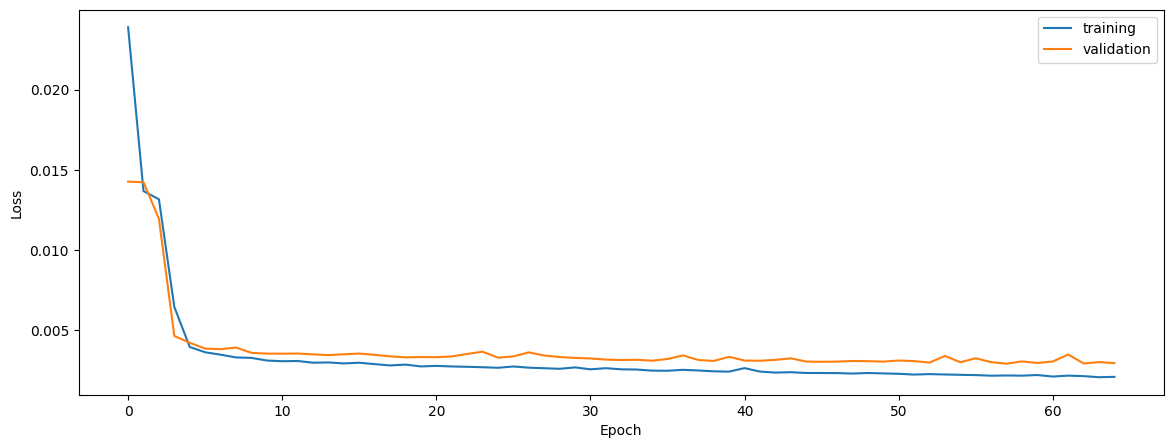

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9198910846212657
0.8922869747856551
0.8692090132527722


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.9198910846212657
0.8922869747856551
0.8692090132527722


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.9274915047814061
0.9032353650844923
0.8948311554880619


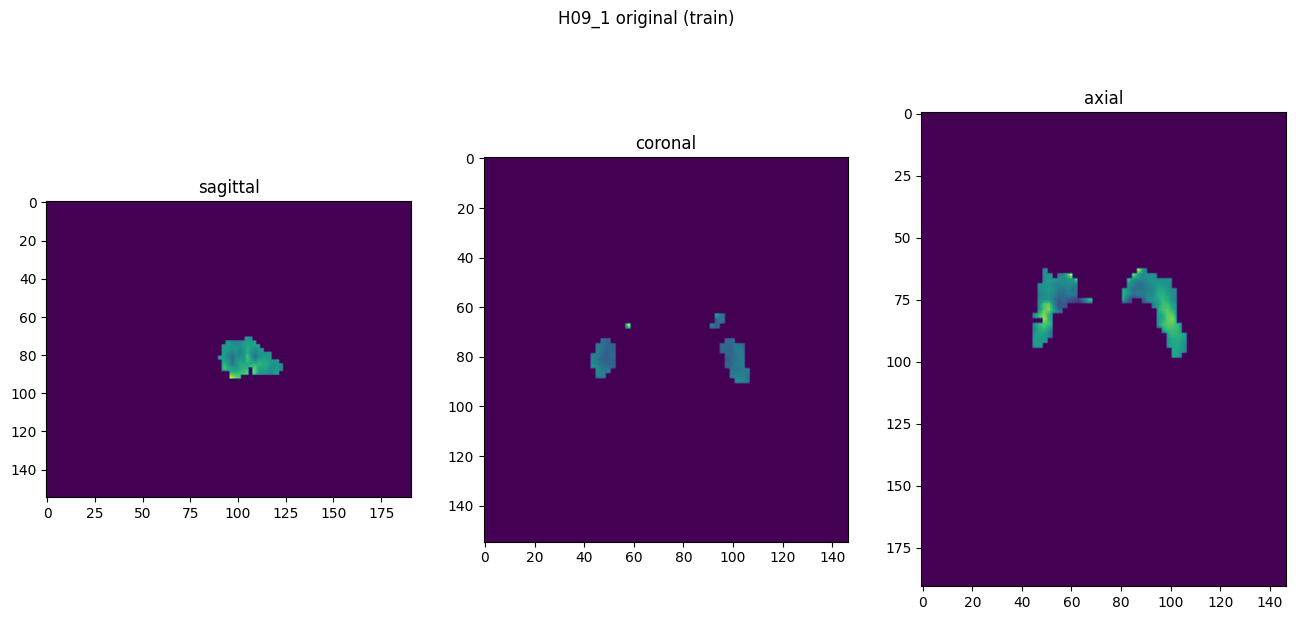

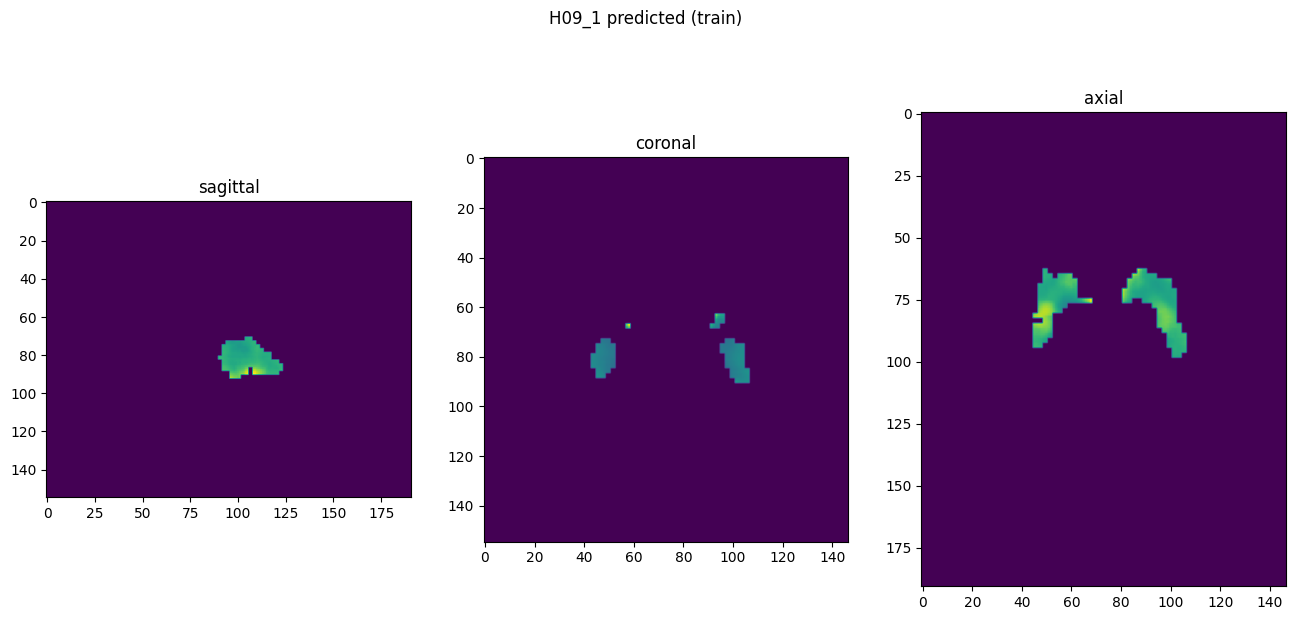

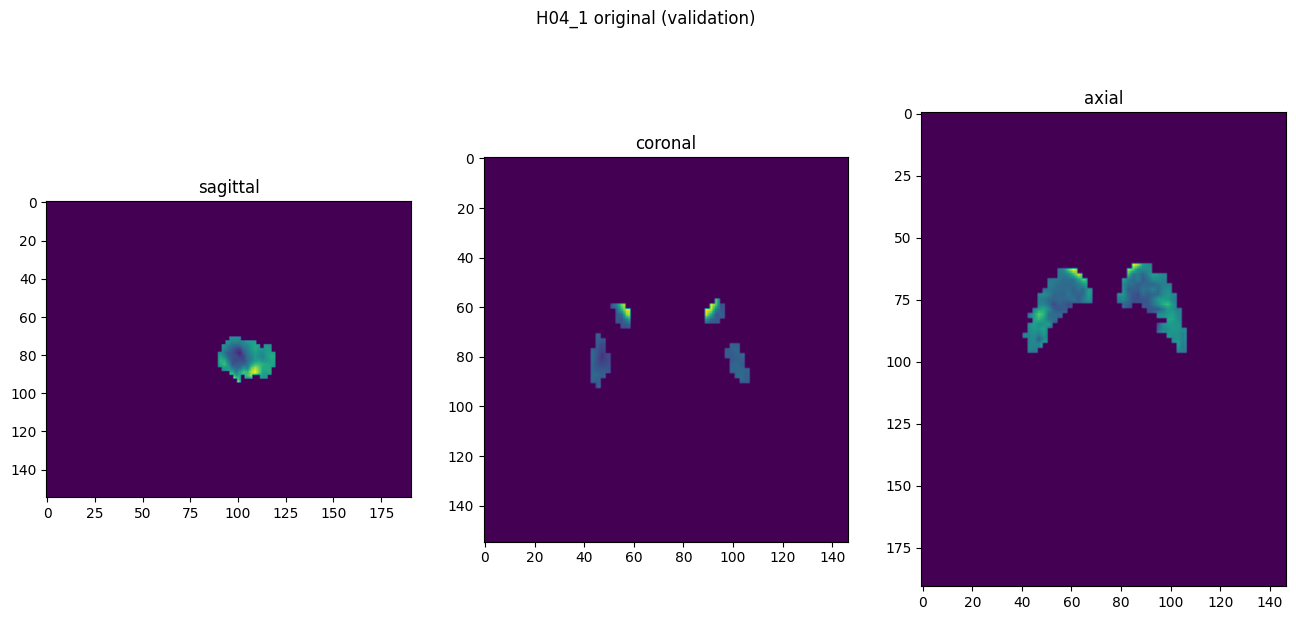

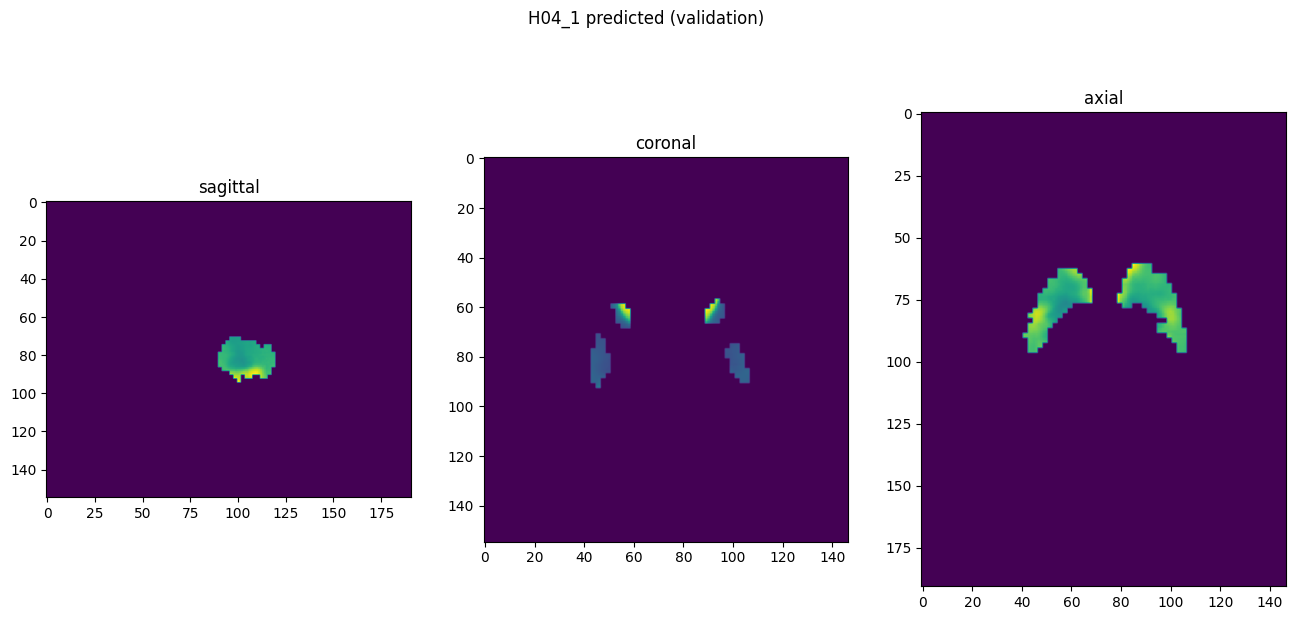

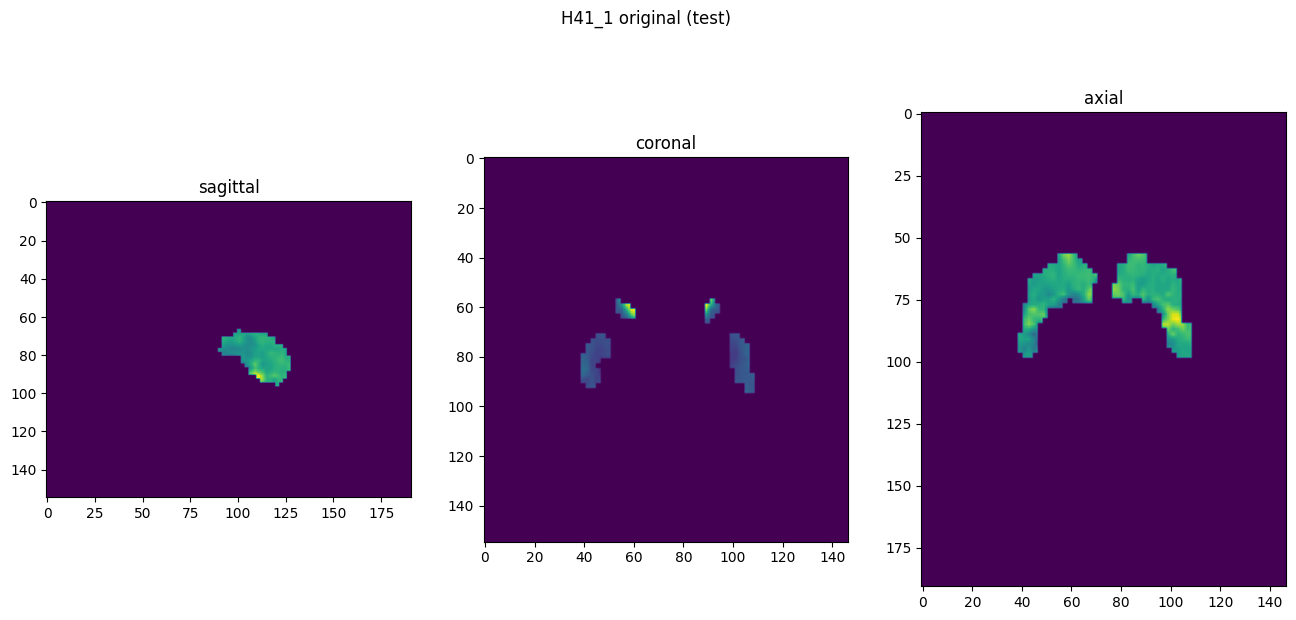

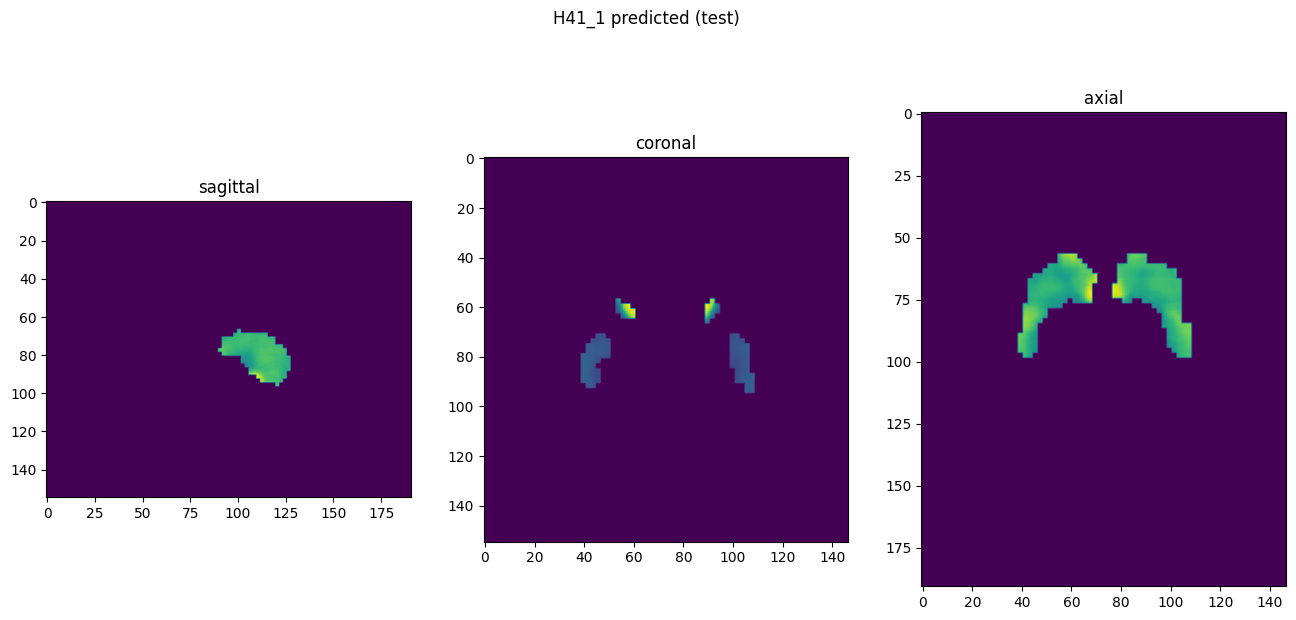

In [10]:
showResults(model, gen, threshold=None, background=False)